In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os

from astropy.io import fits


from scipy import optimize
from scipy.signal import find_peaks
from astropy.stats import LombScargle


import lightkurve as lk

from matplotlib import rcParams
rcParams["figure.dpi"] = 150


from astropy.stats import sigma_clip

#TD
import scipy.special
import math


from lmfit import Model



from scipy.ndimage import gaussian_filter

In [2]:
from matplotlib import rcParams
rcParams["figure.dpi"] = 150

In [3]:
#Amplitude Spectrum Function
def AS(times, flux, oversample):
    timebase = max(times) - min(times)
    tmin = min(times)
    tmax = max(times)
    df = 1.0 / (tmax - tmin)
    dt = np.median(np.diff(times))
    ny = 0.5 / dt
    oversample = oversample

    freq = np.arange(df, 120, df / oversample)
    model = LombScargle(times, flux)
    power = model.power(freq, method = 'fast', normalization = 'psd')
    fct = np.sqrt(4 / len(times))
    amp = np.sqrt(np.abs(power)) * fct
    
    return((freq, amp))

In [4]:
#Fourier Function
def fourier_sum(freqs, amps, phase, y_noise, x):
    y = []
    for j in range(0, len(x)):
        temp = []
        temp.append(y_noise[j])
        for i in range(0, len(freqs)):
            #next line: sum(amplitude_i * sine(freq_i * x + phase_i)) for all pulsations i 
            temp.append(amps[i]*np.sin(2.*np.pi*freqs[i]*x[j]+phase[i]))
        y.append(sum(temp))
    return y

def lc_sim(freqs, amps, phs, time_start, time_end, cadence, precision):
    freqs = np.array(freqs)
    amps = np.array(amps)
    phs = np.array(phs)
    
    time = np.arange(time_start, time_end, cadence)
    noise = np.random.normal(0, precision, len(time))
    
    multisine = np.array(fourier_sum(freqs, amps, phs, noise, time))

    return [freqs, amps, phs, time, multisine]

def lc_model(freqs, amps, phs, time_start, time_end, cadence_model):
    freqs = np.array(freqs)
    amps = np.array(amps)
    phs = np.array(phs)
    
    time_model = np.arange(time_start, time_end, cadence_model)
    noise_model = [0 for i in time_model]    

    multisine_model = np.array(fourier_sum(freqs, amps, phs, noise_model, time_model))

    return [freqs, amps, phs, time_model, multisine_model]

def lc_model_times(freqs, amps, phs, times):
    freqs = np.array(freqs)
    amps = np.array(amps)
    phs = np.array(phs)
    
    time_model = times
    noise_model = [0 for i in time_model]  

    multisine_model = np.array(fourier_sum(freqs, amps, phs, noise_model, time_model))

    return [freqs, amps, phs, time_model, multisine_model]

In [5]:
def dft_phase(x, y, freq):
    """ 
    Discrete fourier transform to calculate the ASTC phase
    given x, y, and an array of frequencies
    
    Parameters
    ----------
        x : `array`
            Array in which to calculate 
        x : `array`
    
    Returns:
    ----------
        phase : `list`
            A list of phases for the given frequencies
    """

    freq = np.asarray(freq)
    x = np.array(x)
    y = np.array(y)
    phase = []
    for f in freq:
        expo = 2.0 * np.pi * f * x
        ft_real = np.sum(y * np.cos(expo))
        ft_imag = np.sum(y * np.sin(expo))
        phase.append(np.arctan2(ft_imag,ft_real))
        
        
    ## my phase wrapping patch
    tmp = []
    for i in phase:
        if i < 0:
            tmp.append(i + 2 * np.pi)
        else:
            tmp.append(i)

    p = np.array(tmp)
    p = (- p + np.pi/2) % (2 * np.pi)

    return p

# TESS

SearchResult containing 4 data products.

target_name                     productFilename                     description  distance
----------- ------------------------------------------------------- ------------ --------
  270577175 tess2018292075959-s0004-0000000270577175-0124-s_lc.fits Light curves      0.0
  270577175 tess2018319095959-s0005-0000000270577175-0125-s_lc.fits Light curves      0.0
  270577175 tess2018349182459-s0006-0000000270577175-0126-s_lc.fits Light curves      0.0
  270577175 tess2019006130736-s0007-0000000270577175-0131-s_lc.fits Light curves      0.0


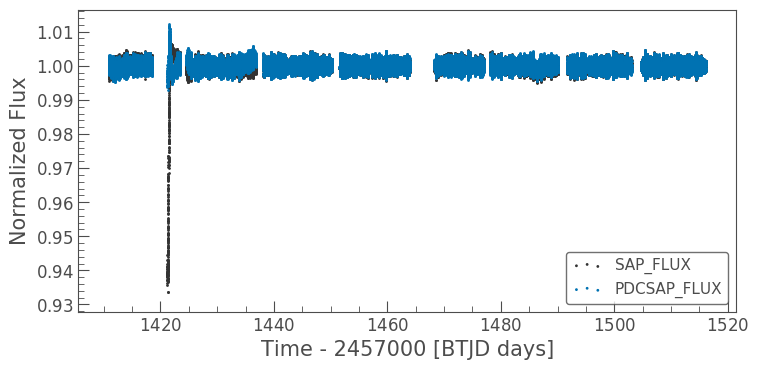

In [34]:
for name in ['beta Pictoris']:
    sr = lk.search_lightcurvefile(name)
    print(sr)

    if len(sr) > 0:

        #Download data
        lcfs = sr.download_all()

        # Use the normalized PDCSAP_FLUX
        lc0 = lcfs[0].SAP_FLUX.normalize()
        lc1 = lcfs[0].PDCSAP_FLUX.normalize()

        # Loop through the rest of the LCFS, appending to the first light curve
        for lcf in lcfs[1:]:
            lc0 = lc0.append(lcf.SAP_FLUX.normalize())
            lc1 = lc1.append(lcf.PDCSAP_FLUX.normalize())

        #Remove bad quality and nans
        q0 = lc0.quality == 0
        lc0 = lc0[q0].remove_nans()
        q1 = lc1.quality == 0
        lc1 = lc1[q1].remove_nans()
        #Plot data
        ax = lc0.scatter(label = 'SAP_FLUX')
        lc1.scatter(ax=ax, label = 'PDCSAP_FLUX')

        
        #Times & Mags
        times = lc1.time + 2457000
        mags = -2.5 * np.log10(lc1.flux)
        mags = mags - np.mean(mags)
        
        x = times
        y = mags

In [ ]:
#AS
freq, amp = AS(times, mags, 15)

#         timebase = max(times) - min(times)
#         tmin = times.min()
#         tmax = times.max()
#         df = 1.0 / (tmax - tmin)
#         dt = np.median(np.diff(times))
#         ny = 0.5 / dt
#         oversample = 25

#         #create ampl spectrum

fig, ax = plt.subplots(1, 1, figsize=(7, 4))

#         freq = np.arange(df, ny/4, df / oversample)
#         model = LombScargle(times, mags)
#         power = model.power(freq, method = 'fast', normalization = 'psd')
#         fct = np.sqrt(4 / len(times))
#         amp = np.sqrt(np.abs(power)) * fct

ax.plot(freq, amp)


freq=freq[5000:]
amp=amp[5000:]
ax.plot(freq, amp)


max_power = amp.max()

peaks, _ = find_peaks(amp, height=max_power*0.05, distance=250)
ax.plot(freq[peaks], amp[peaks], "x")


sort_idx = np.argsort(amp[peaks])[::-1]
f_TESS = freq[peaks][sort_idx]
a_TESS = amp[peaks][sort_idx]

print(f_TESS)
print(a_TESS)
print(len(f_TESS))

In [147]:
t_TESS = x
m_TESS = y

In [148]:
def highpass(flux, order, sigma):
    highpass_lst = []
    highpass_lst.append(flux)
    
    for i in range(0, order):
        lowpass = gaussian_filter(highpass_lst[i], sigma=sigma)
        highpass = highpass_lst[i] - lowpass
        highpass_lst.append(highpass)

    return highpass_lst

/home/sebastian/anaconda3/lib/python3.7/site-packages/lightkurve/periodogram.py:744: LightkurveWarning: Input light curve will be normalized.
  LightkurveWarning)
/home/sebastian/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/sebastian/anaconda3/lib/python3.7/site-packages/lightkurve/periodogram.py:744: LightkurveWarning: Input light curve will be normalized.
  LightkurveWarning)
/home/sebastian/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/sebastian/anaconda3/lib/python3.7/site-packages/lightkurve/periodogram.py:744: LightkurveWarning: Input light curve will be normalized.
  LightkurveWarning)
/home/sebastian/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarni

[47.43903298 53.69160236 50.49211222 54.23794952 39.06318864 46.5428208
 48.91898731 43.52777037 57.45201737 47.27043861 34.76022934 38.12894767
 45.26948964 53.85766147 51.49607267 50.71711598 47.66403674 49.71252171
 44.68384605 53.46659859 42.03577358 65.13510364 50.19295228 41.64978121
 54.06872134 43.82946556 46.84324836 48.13876299 47.06444925 45.90076781]
[1.04274414e-03 9.69447102e-04 9.31640582e-04 5.63751542e-04
 4.39355917e-04 4.10780750e-04 2.32437974e-04 2.07208282e-04
 1.59655131e-04 1.50988907e-04 1.42443344e-04 1.31865613e-04
 1.20970219e-04 1.11899656e-04 1.10789942e-04 9.66584655e-05
 9.02630193e-05 8.99795295e-05 8.48409496e-05 8.38085677e-05
 8.20321804e-05 8.19159196e-05 7.54083691e-05 6.99785943e-05
 6.91080717e-05 6.82808453e-05 6.81903625e-05 6.51467485e-05
 6.41245997e-05 6.03288846e-05]
30


/home/sebastian/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/sebastian/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


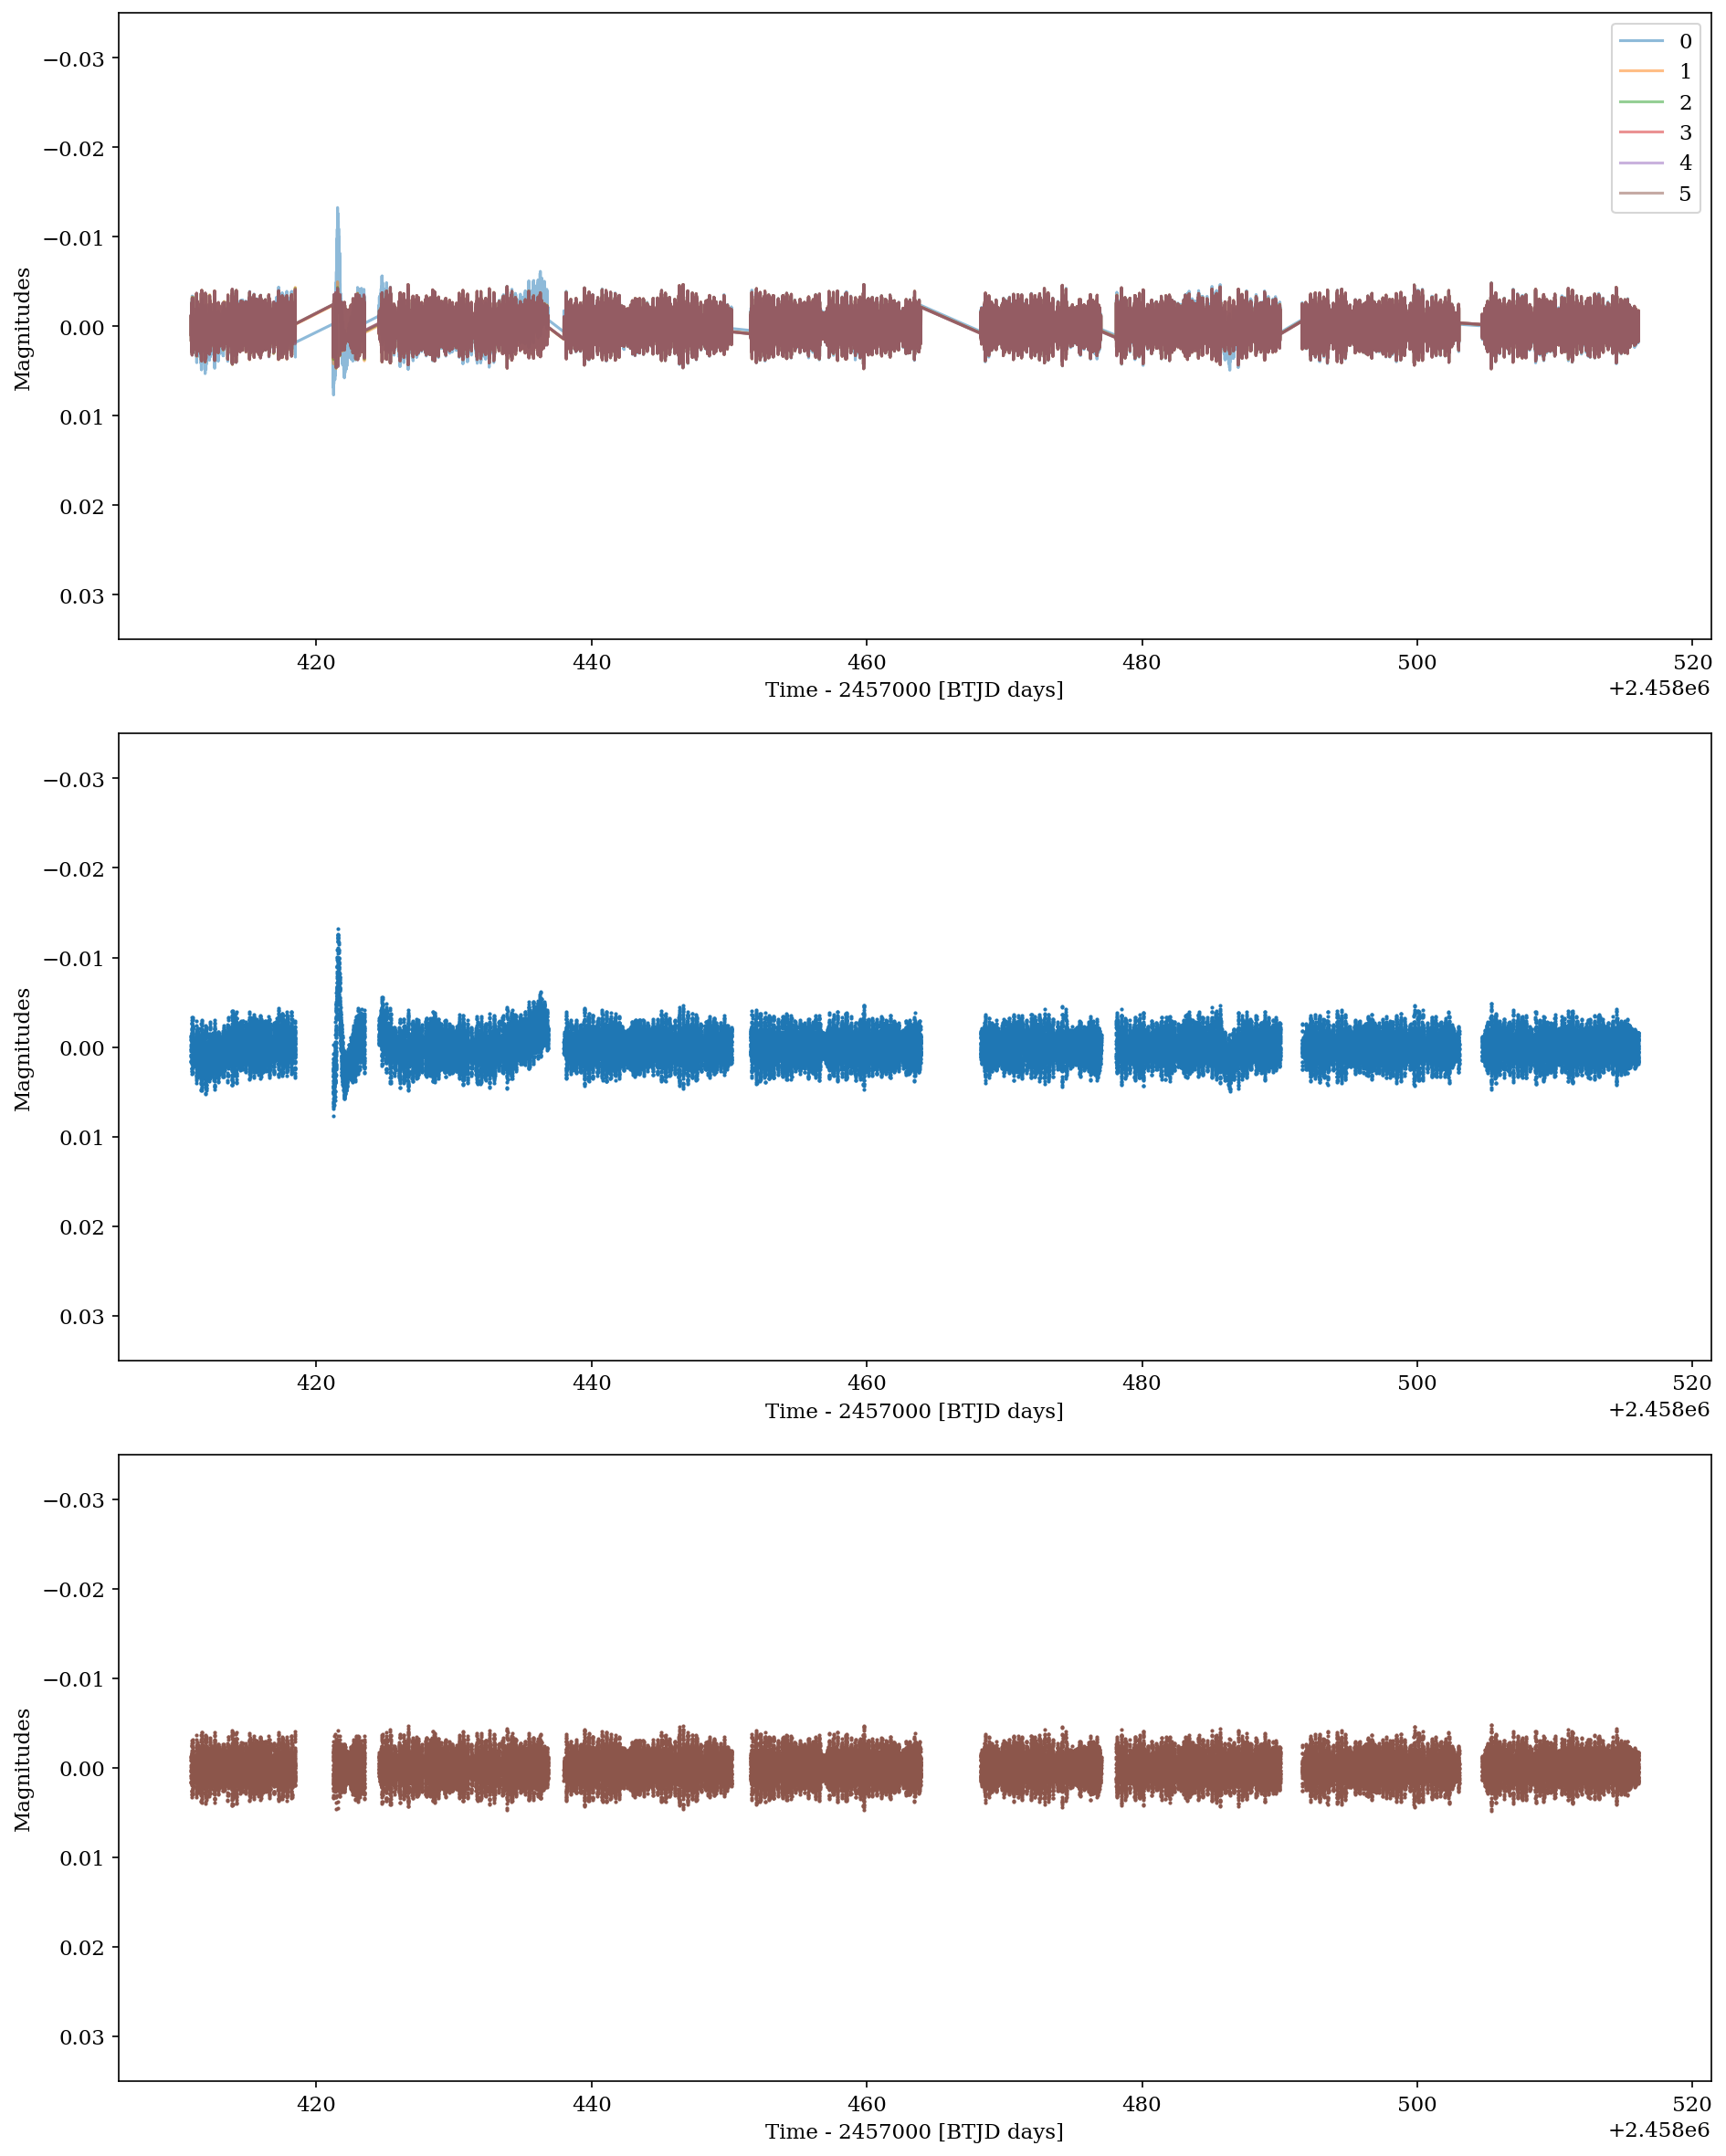

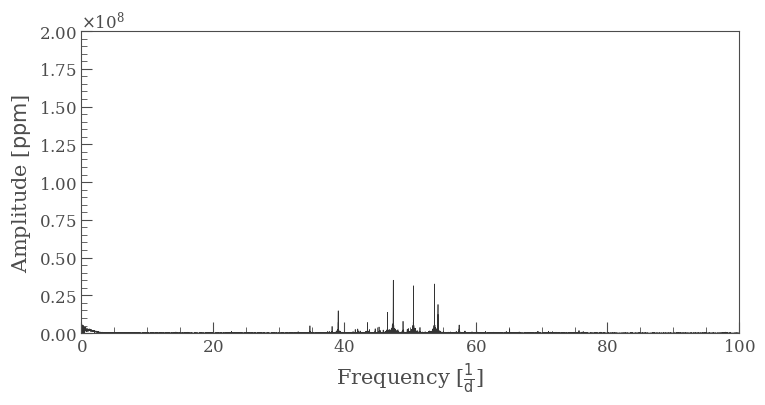

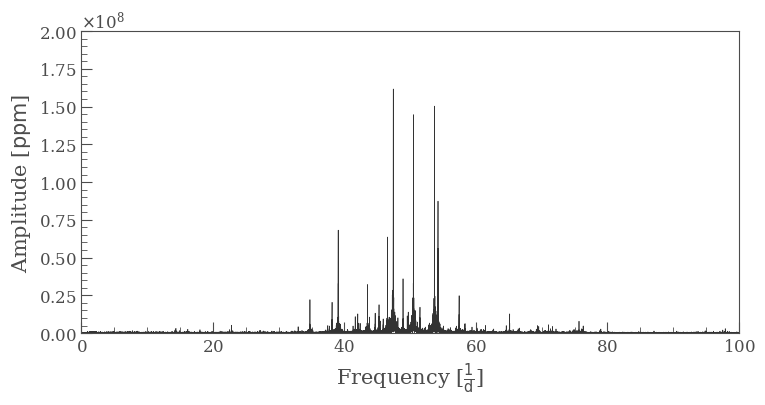

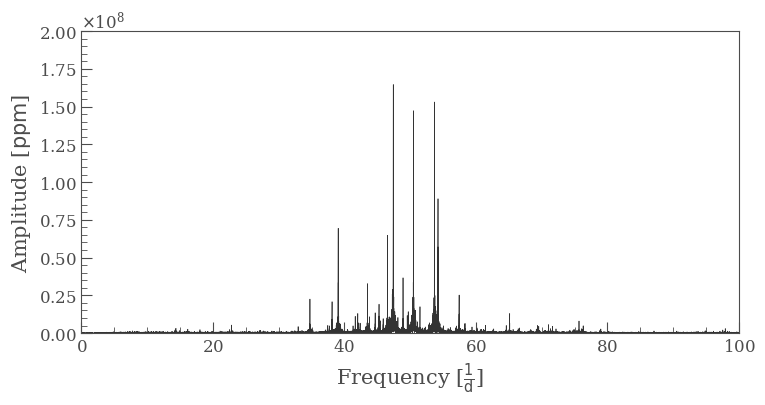

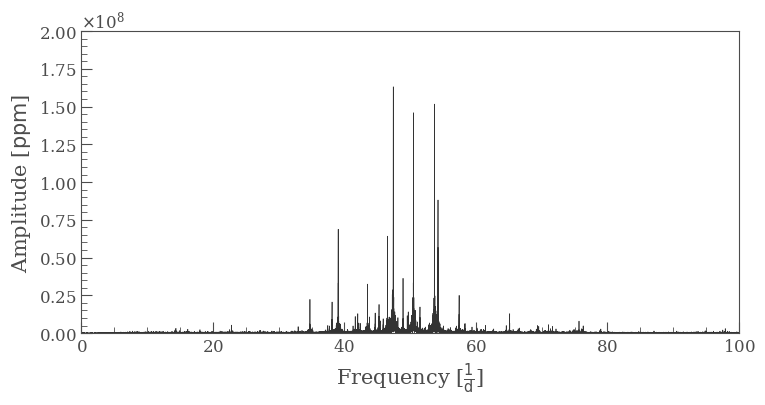

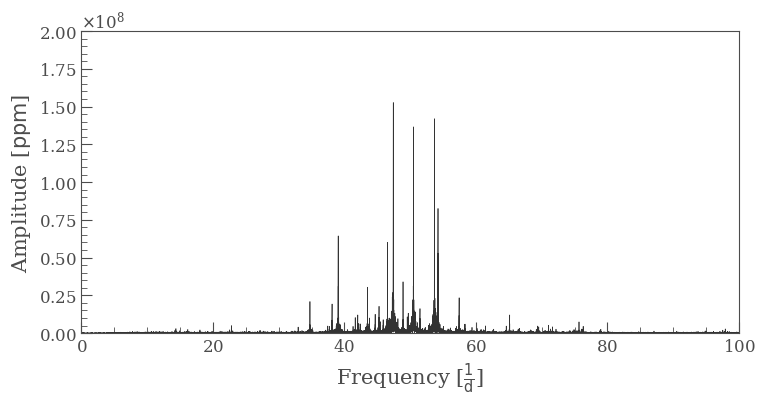

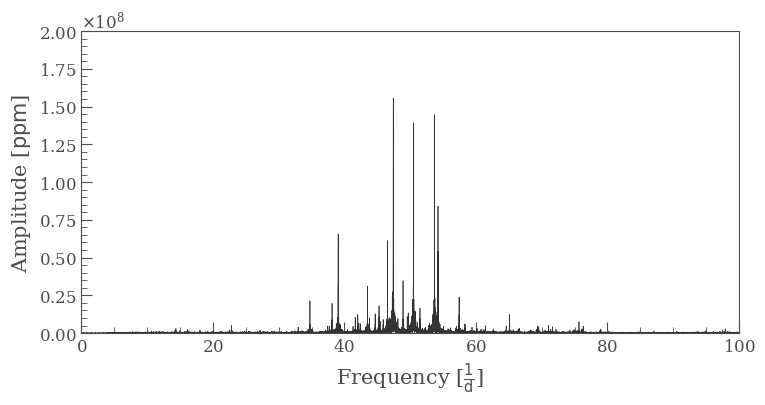

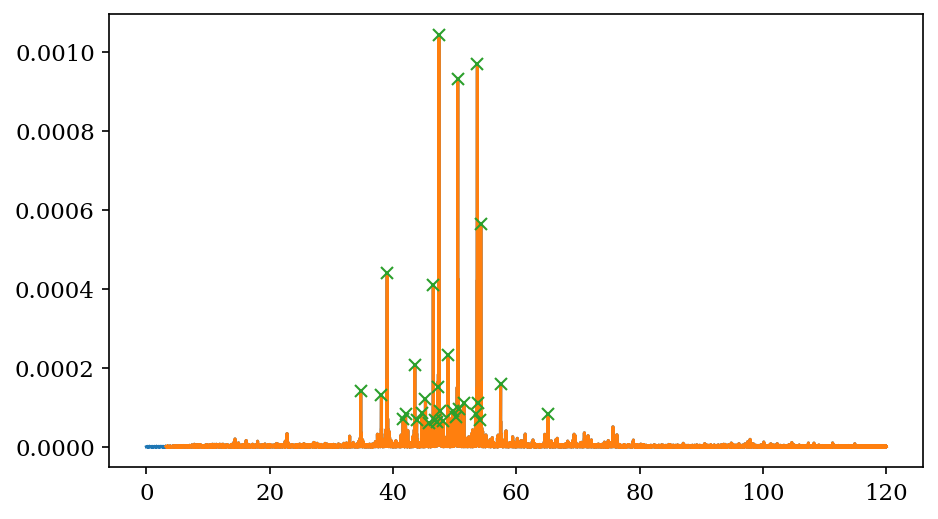

In [149]:
t = x
m = y


highpass_own = highpass(m, 5, 30)

fig, ax = plt.subplots(3, 1, figsize=(15, 20))


hpmax = len(highpass_own)-1

for i in range(0, len(highpass_own)):
    ax[0].plot(t, highpass_own[i], label='{0}'.format(i), alpha=0.5)

ax[1].scatter(t, highpass_own[0], s=1, label='{0}'.format(i), alpha=1, c='C0')
ax[2].scatter(t, highpass_own[hpmax], s=1, label='{0}'.format(i), alpha=1, c='C5')

for i in range(0,3):
    #ax[i].set_xlim(-0.015, 0.015)
    ax[i].set_ylim(-0.035, 0.035)
    ax[i].set_ylabel('Magnitudes')
    ax[i].set_xlabel('Time - 2457000 [BTJD days]')
    ax[i].invert_yaxis()

ax[0].legend()

plt.subplots_adjust(hspace=0.15)


lc_own_0 = lk.LightCurve(t, highpass_own[0])
lc_own_1 = lk.LightCurve(t, highpass_own[1])
lc_own_2 = lk.LightCurve(t, highpass_own[2])
lc_own_3 = lk.LightCurve(t, highpass_own[3])
lc_own_4 = lk.LightCurve(t, highpass_own[4])
lc_own_max = lk.LightCurve(t, highpass_own[hpmax])

lc_own_lst = [lc_own_0,lc_own_1,lc_own_2,lc_own_3,lc_own_4, lc_own_max]

for i in range(0, 6):
    lc_own_lst[i].to_periodogram(method='LombScargle', minimum_frequency=0, maximum_frequency=100, oversample_factor=10).plot()
    plt.ylim(0,2e8)
    plt.xlim(0,100)
    
t_combT_hp = t
m_combT_hp = highpass_own[hpmax]





#AS
freq, amp = AS(t_combT_hp, m_combT_hp, 15)

fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax.plot(freq, amp)

freq=freq[5000:]
amp=amp[5000:]
ax.plot(freq, amp)

max_power = amp.max()

peaks, _ = find_peaks(amp, height=max_power*0.05, distance=250)
ax.plot(freq[peaks], amp[peaks], "x")

sort_idx = np.argsort(amp[peaks])[::-1]
f_TESS = freq[peaks][sort_idx]
a_TESS = amp[peaks][sort_idx]

print(f_TESS)
print(a_TESS)
print(len(f_TESS))

In [150]:
def sin(x: np.ndarray, amp: float, f: float, phase: float) -> np.ndarray:
    """
    Sinus function, used for fitting.

    :param x: Time axis
    :param amp: amplitude
    :param f: frequency
    :param phase: phase, normed to 1
    """
    return amp * np.sin(2. * np.pi * (f * x + phase))

In [151]:
def phases_simon(times, magnitudes, f_fix, a_guess, p_guess):
    
    freqs = []
    amps = []
    phases = []
    phases_err = []
    
    for i in range(len(f_fix)):

        model1 = Model(sin)
        #model1.set_param_hint('amp', value=a_guess[i], vary=False)
        model1.set_param_hint('amp', value=a_guess[i], min=0.9 * a_guess[i], max=1.1 * a_guess[i])
        model1.set_param_hint('f', value=f_fix[i], vary=False)
        model1.set_param_hint('phase', value=p_guess[i], min=0, max=1)
        result1 = model1.fit(magnitudes, x=times, method='least_squares')

        # after first fit, vary only phase
        model2 = Model(sin)
        model2.set_param_hint('amp', value=result1.values['amp'], vary=False)
        model2.set_param_hint('f', value=f_fix[i], vary=False)
        model2.set_param_hint('phase', value=result1.values['phase'], min=0, max=1)
        result2 = model2.fit(magnitudes, x=times, method='least_squares')

        freqs.append(result2.values['f'])
        amps.append(result2.values['amp'])
        phases.append(result2.values['phase'])
        #phases_err.append(np.sqrt(np.diag(result2.covar)[0]))
        
    freqs = np.array(freqs)
    amps = np.array(amps)
    phases = np.array(phases)
   # phases_err = np.array(phases_err)
        
    return(freqs, amps, phases, phases_err)

In [152]:
# datadir = os.getcwd()
# datafilefreqs = '/freqsTESS.per'

# f_TESS, a_TESS, p_TESS = np.loadtxt(datadir + datafilefreqs, usecols=(1, 2, 3)).T

In [153]:
# datadir = os.getcwd()
# datafileTESSres = '/TESSres.dat'

# t04, f04 = np.loadtxt(datadir + datafileTESSres, usecols=(0,1)).T

[47.43886759 53.69182548 50.49182646]


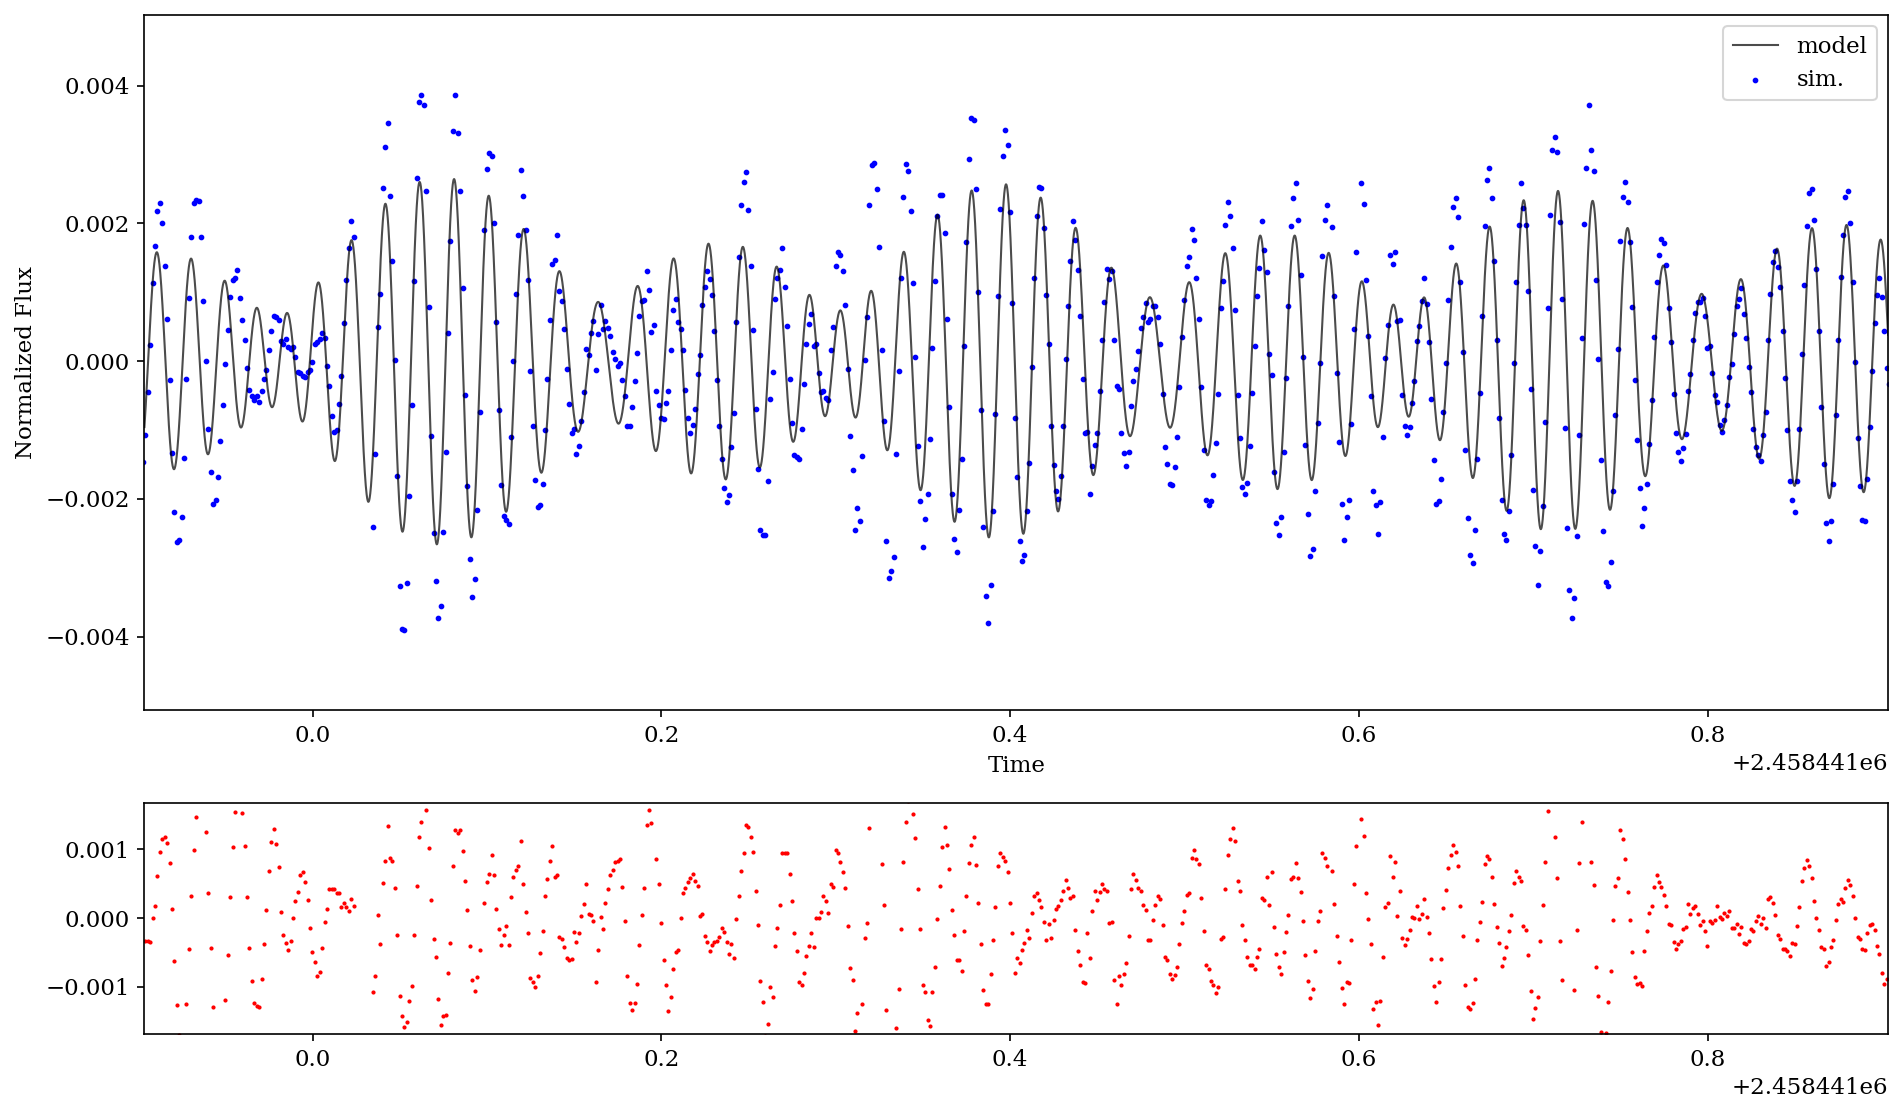

In [154]:
#Phases

f_TESS = f_TESS[:3]
a_TESS = a_TESS[:3]
p_TESS = dft_phase(x, y, f_TESS)/(2*np.pi)

f_TESS_new, a_TESS_new, p_TESS_new,_ = phases_simon(x, y, f_TESS, a_TESS, p_TESS)

def chi2(nu):
    arg = 2*np.pi*nu[None, :]*x[:, None]
    D = np.concatenate([np.cos(arg), np.sin(arg),
                np.ones((len(x), 1))],
                axis=1)

    # Solve for the amplitudes and phases of the oscillations
    DTD = np.matmul(D.T, D)
    DTy = np.matmul(D.T, y[:, None])
    w = np.linalg.solve(DTD, DTy)
    model = np.squeeze(np.matmul(D, w))

    chi2_val = np.sum(np.square(y - model))
    return chi2_val

res = optimize.minimize(chi2, [f_TESS], method="L-BFGS-B")
print(res.x)


model = lc_model(f_TESS_new, a_TESS_new, p_TESS_new*2*np.pi, min(times)+30, min(times)+31, 2/1440/20)


m1 = times < min(times)+31
m2 = times > min(times)+30
m0 = m1 & m2

model_times = lc_model_times(f_TESS_new, a_TESS_new, p_TESS_new*2*np.pi, times[m0])

#Plot
fig, ax = plt.subplots(2, 1, figsize=(15, 9), gridspec_kw = {'height_ratios':[3, 1]})

ax[0].scatter(x, y, s=3, c='b', label = 'sim.')
#ax.scatter(lc_rand[3], lc_rand[5], s=3, c='r')
ax[0].plot(model[3], model[4], c='k', linewidth=1, label = 'model',alpha=0.7)


ax[0].set_xlabel('Time')
ax[0].set_ylabel('Normalized Flux')

ax[1].scatter(x[m0], y[m0]-model_times[4], s=1, c='r')

for i in range(2):
    ax[i].set_xlim(min(times)+30, min(times)+31)
    ax[i].invert_yaxis()

ax[0].set_ylim(min(y[m0])-(max(y[m0])-min(y[m0]))*0.15, max(y[m0])+(max(y[m0])-min(y[m0]))*0.15)
ax[1].set_ylim((min(y[m0])-(max(y[m0])-min(y[m0]))*0.15)/3, (max(y[m0])+(max(y[m0])-min(y[m0]))*0.15)/3)

ax[0].legend()

#plt.savefig('fit04.png')

# segment_size = 4

# times = times
# magnitudes = mags

# time_0 = times[0]
# time_slice, mag_slice, phase = [], [], []
# time_delays, time_midpoints = [], []

# # Iterate over lightcurve
# for t, y in zip(times, magnitudes):
#     time_slice.append(t)
#     mag_slice.append(y)

#     # In each segment
#     if t - time_0 > segment_size:
#         # Append the time midpoint
#         time_midpoints.append(np.mean(time_slice))

#         # And the phases for each frequency
#         phase.append(dft_phase(time_slice, mag_slice, f_TESS))
#         time_0 = t
#         time_slice, mag_slice = [], []

# phase = np.array(phase).T

# # Phase wrapping patch
# for ph, f in zip(phase, f_TESS):
#     td = ph / (2*np.pi*f)
#     time_delays.append(td-np.mean(td))

# fig, ax = plt.subplots(1, 1, figsize=(6.5, 3.5))
# for i in range(4):
#     ax.scatter(time_midpoints, time_delays[i]*86400, s=5)

(47.43903297816253, 53.69160235742387)

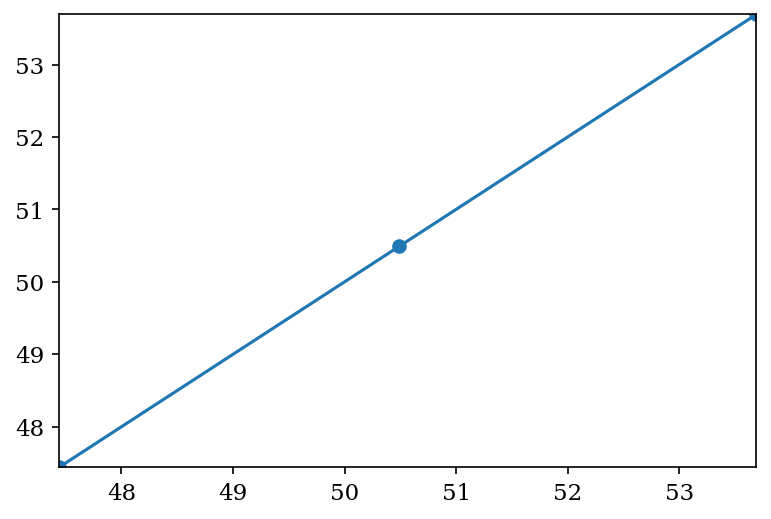

In [155]:
plt.scatter(f_TESS, f_TESS_new)
plt.plot([min(f_TESS), max(f_TESS)], [min(f_TESS), max(f_TESS)])
plt.xlim(min(f_TESS), max(f_TESS))
plt.ylim(min(f_TESS), max(f_TESS))

(0.0009316405821701169, 0.0010427441413436284)

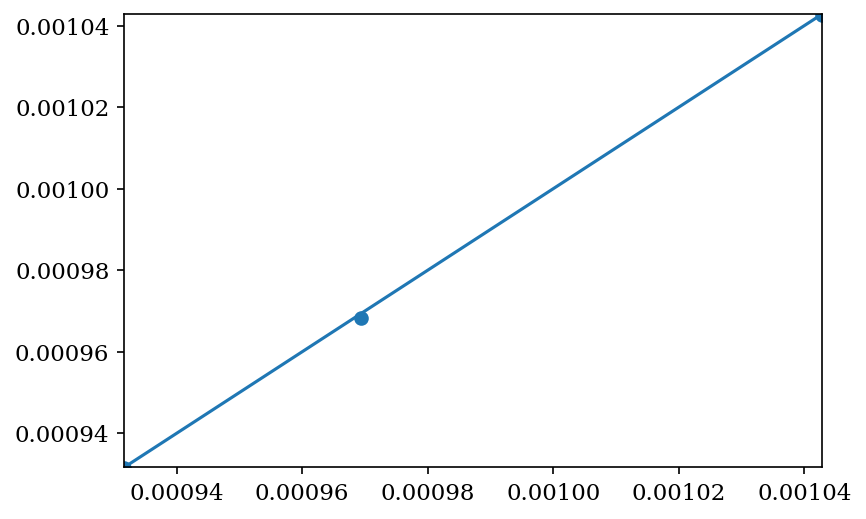

In [156]:
plt.scatter(a_TESS, a_TESS_new)
plt.plot([min(a_TESS), max(a_TESS)], [min(a_TESS), max(a_TESS)])
plt.xlim(min(a_TESS), max(a_TESS))
plt.ylim(min(a_TESS), max(a_TESS))

(0.19596499253206243, 0.7518881551695217)

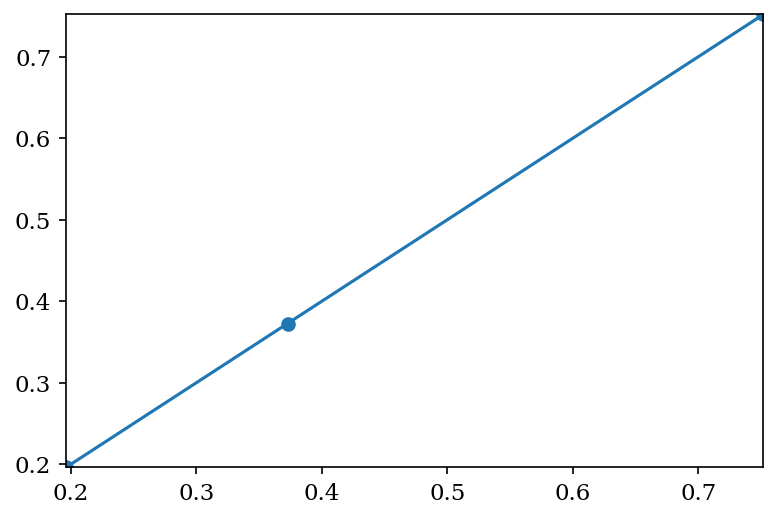

In [157]:
plt.scatter(p_TESS, p_TESS_new)
plt.plot([min(p_TESS), max(p_TESS)], [min(p_TESS), max(p_TESS)])
plt.xlim(min(p_TESS), max(p_TESS))
plt.ylim(min(p_TESS), max(p_TESS))

In [158]:
# datapairs=np.stack((x,y), axis=-1)
# np.savetxt('TESS_BJD.txt', datapairs)

# BRITE

In [6]:
datadir = os.getcwd()
datadir_BRITE = '/BRITE'
datafileB15 = '/betaPic_2015_BHr.dat'
datafileB16 = '/betaPic_2016_BTrBHr.dat'
datafileB17 = '/betaPic_2017_BHr.dat'

tB15, mB15 = np.loadtxt(datadir + datadir_BRITE + datafileB15, usecols=(0, 1)).T
tB16, mB16 = np.loadtxt(datadir + datadir_BRITE + datafileB16, usecols=(0, 1)).T
tB17, mB17 = np.loadtxt(datadir + datadir_BRITE + datafileB17, usecols=(0, 1)).T

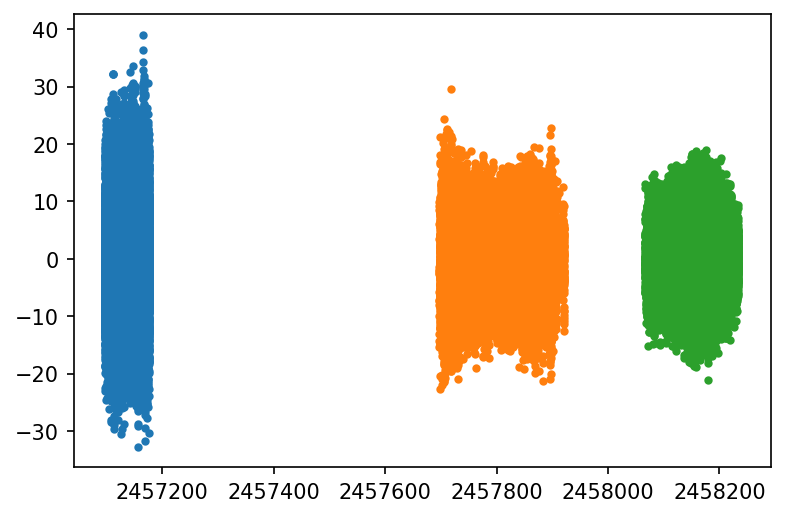

In [7]:
plt.scatter(tB15+2456000, mB15, marker='.')
plt.scatter(tB16+2456000, mB16, marker='.')
plt.scatter(tB17+2456000, mB17, marker='.')

In [8]:
0.5/np.median(np.diff(tB15))*86400

360000000.2267916

In [9]:
0.5/np.median(np.diff(tB16))*60

127659.57448160277

In [10]:
0.5/np.median(np.diff(tB17))*60

127659.57448160277

In [11]:
# datapairs=np.stack((tB15+2456000), axis=-1)
# np.savetxt('times2015.txt', datapairs)
# datapairs=np.stack((tB16+2456000), axis=-1)
# np.savetxt('times2016.txt', datapairs)
# datapairs=np.stack((tB17+2456000), axis=-1)
# np.savetxt('times2017.txt', datapairs)

## BRITE BJD correction

In [12]:
datadir = os.getcwd()
datafileB15 = '/times2015.txt.bjd'
datafileB16 = '/times2016.txt.bjd'
datafileB17 = '/times2017.txt.bjd'

tB15_BJD = np.loadtxt(datadir + datafileB15, usecols=(0)).T
tB16_BJD = np.loadtxt(datadir + datafileB16, usecols=(0)).T
tB17_BJD = np.loadtxt(datadir + datafileB17, usecols=(0)).T

In [13]:
tB15+2456000

array([2457097.988834, 2457097.989011, 2457097.989189, ...,
       2457176.311697, 2457176.311816, 2457176.312055])

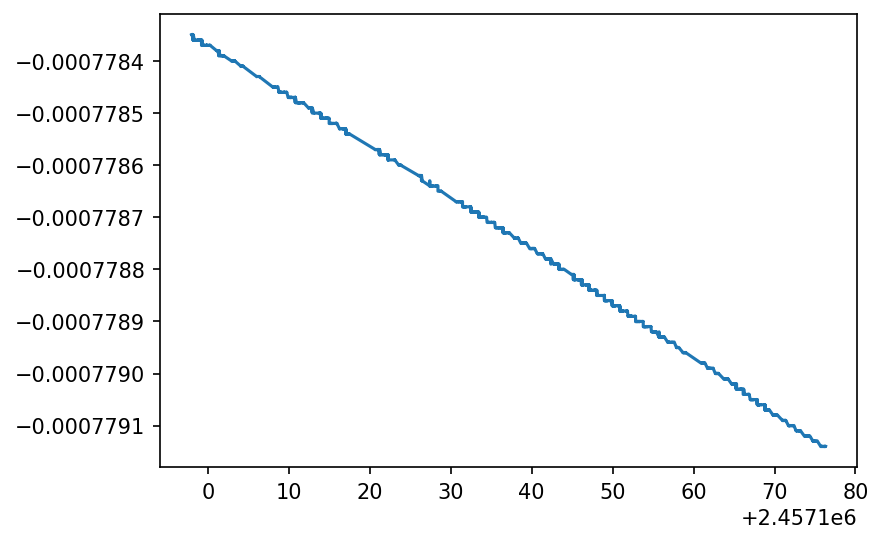

In [14]:
plt.plot(tB15_BJD, tB15+2456000-tB15_BJD)

(2457753, 2457756)

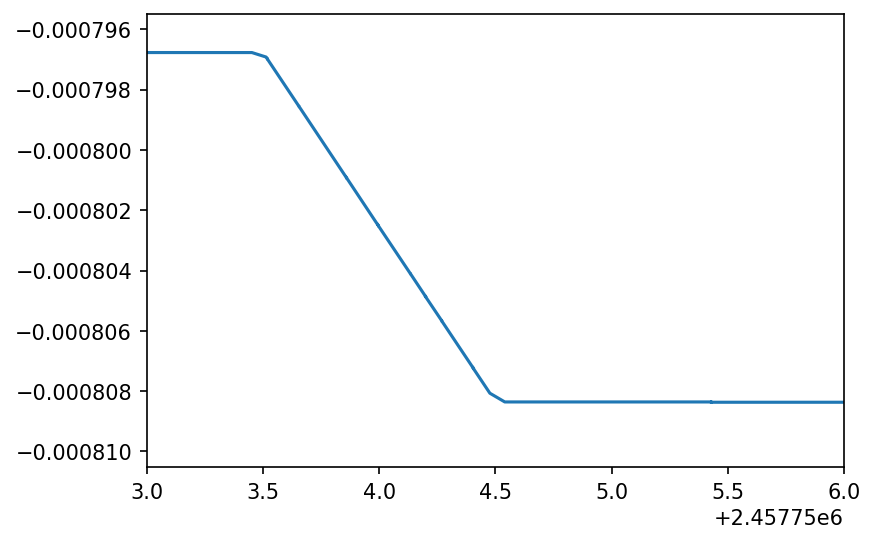

In [15]:
plt.plot(tB16_BJD, tB16+2456000-tB16_BJD)
plt.xlim(2457753,2457756)

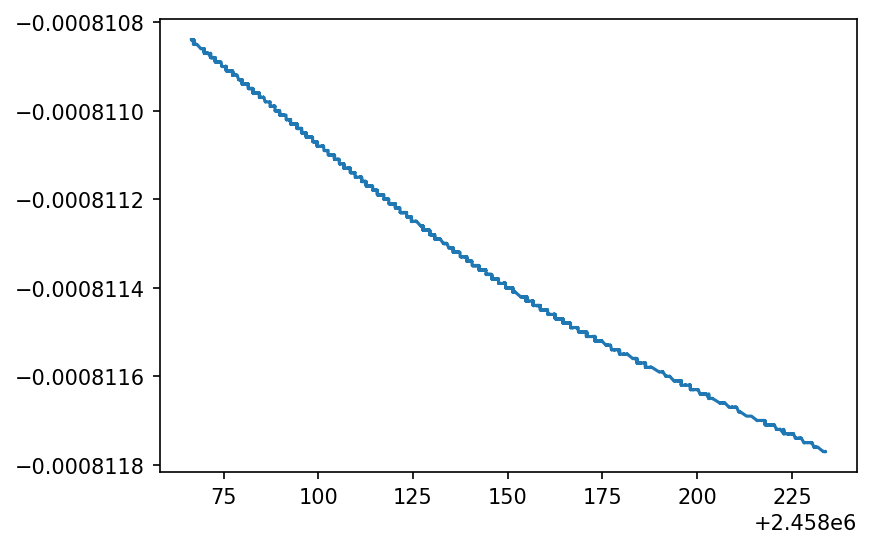

In [16]:
plt.plot(tB17_BJD, tB17+2456000-tB17_BJD)

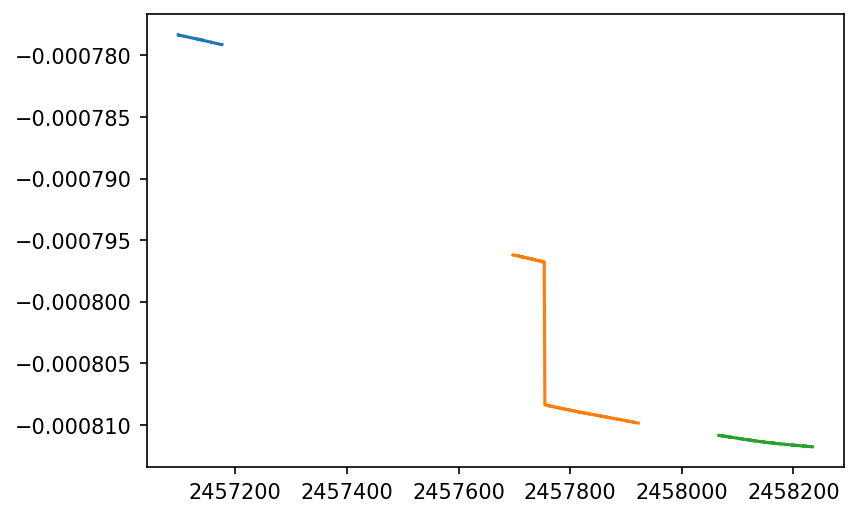

In [17]:
plt.plot(tB15_BJD, tB15+2456000-tB15_BJD)
plt.plot(tB16_BJD, tB16+2456000-tB16_BJD)
plt.plot(tB17_BJD, tB17+2456000-tB17_BJD)

# Compare BRITE with Model'

In [18]:
model = lc_model(f_TESS_new, a_TESS_new, p_TESS_new*2*np.pi, min(tB16_BJD)+30, min(tB16_BJD)+31, 2/1440/20)

NameError: name 'f_TESS_new' is not defined

NameError: name 'model' is not defined

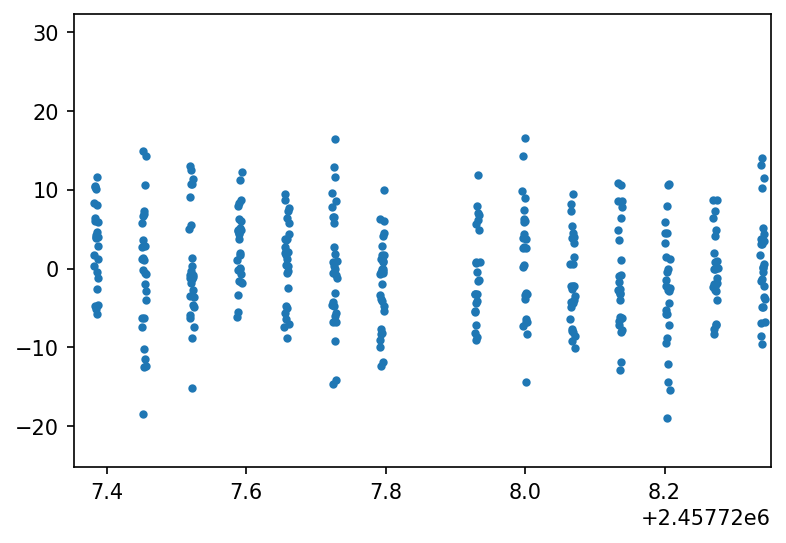

In [19]:
plt.scatter(tB16_BJD, mB16, marker='.')
plt.xlim(min(tB16_BJD)+30, min(tB16_BJD)+31)
plt.plot(model[3], model[4]*1000, c='k', linewidth=1, label = 'model',alpha=0.7)

[ 47.43911323  62.09449606  32.78402726  18.12864444  76.74987889
   3.47326161  91.40496486  50.49202113  11.18212122 106.06034768
  65.14740396  35.83693516  25.83720719  79.80278678  21.18155233
  39.06291242  94.45816961   6.5261695   24.40752959  47.28296489
  53.71829524  54.23720647  46.54289299  40.49259001   9.75214676
   8.12891646   4.90323607 109.11325558  32.62787892  68.37367807
  19.5586189   31.88751017  61.19827582  22.78429929  61.93834772
  68.89258929  76.59373055  17.23212734  39.5821205   62.2773618
  91.24911337  34.21429858  55.1482697   24.92673767  83.54767526
  75.85365865  17.97219923]
[1.45332562 1.11397967 1.1114589  1.01607871 1.00097377 0.90823481
 0.87163092 0.85037948 0.78510772 0.73760263 0.6670653  0.65201765
 0.6259934  0.60223928 0.57707662 0.54475895 0.50849488 0.48505775
 0.48081861 0.45797183 0.45235309 0.45057638 0.44582932 0.44411189
 0.44303842 0.41059969 0.4104953  0.41003233 0.37227411 0.36788726
 0.36244406 0.35178555 0.33891447 0.33093881

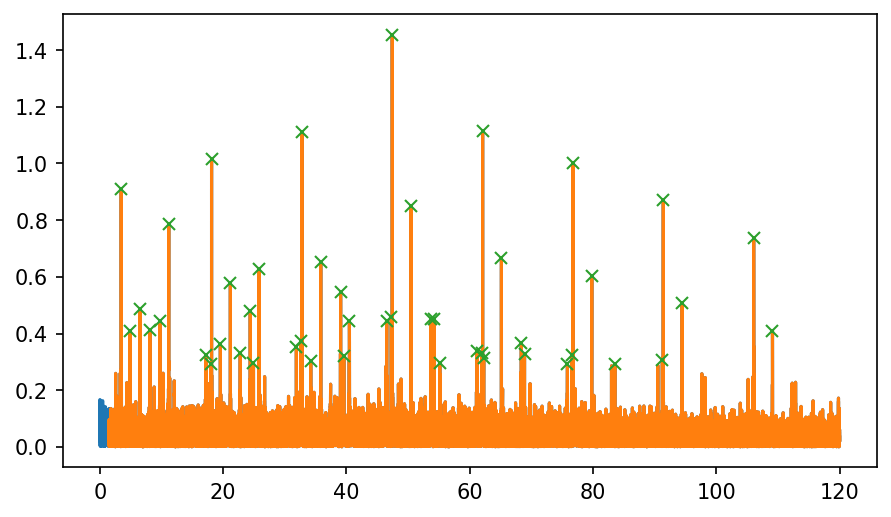

In [20]:
#AS
freq, amp = AS(tB16_BJD, mB16, 15)

#         timebase = max(times) - min(times)
#         tmin = times.min()
#         tmax = times.max()
#         df = 1.0 / (tmax - tmin)
#         dt = np.median(np.diff(times))
#         ny = 0.5 / dt
#         oversample = 25

#         #create ampl spectrum

fig, ax = plt.subplots(1, 1, figsize=(7, 4))

#         freq = np.arange(df, ny/4, df / oversample)
#         model = LombScargle(times, mags)
#         power = model.power(freq, method = 'fast', normalization = 'psd')
#         fct = np.sqrt(4 / len(times))
#         amp = np.sqrt(np.abs(power)) * fct

ax.plot(freq, amp)


freq=freq[5000:]
amp=amp[5000:]
ax.plot(freq, amp)


max_power = amp.max()

peaks, _ = find_peaks(amp, height=max_power*0.2, distance=300)
ax.plot(freq[peaks], amp[peaks], "x")


sort_idx = np.argsort(amp[peaks])[::-1]
f_TESS = freq[peaks][sort_idx]
a_TESS = amp[peaks][sort_idx]

print(f_TESS)
print(a_TESS)
print(len(f_TESS))

# bRing

In [21]:
datadir = os.getcwd()
datadir_bRing = '/bRing'
datafile_bRing = '/Reduced_2110269.fits'

In [22]:
fits_image_filename = datadir+datadir_bRing+datafile_bRing
hdul = fits.open(fits_image_filename)
hdul[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   32 / length of dimension 1                          
NAXIS2  =                42360 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    4 / number of table fields                         
TTYPE1  = 'jd      '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'raw     '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'reduced '        

In [23]:
databring = fits.getdata(datadir+datadir_bRing+datafile_bRing)

In [24]:
bsel = np.where(np.isfinite(databring['reduced']))[0]

In [25]:
jd = databring['jd'][bsel]

In [26]:
reduced = databring['reduced'][bsel]

In [27]:
bsel = np.where(np.isfinite(databring['reduced']))[0]
jd = databring['jd'][bsel]
raw = databring['raw'][bsel]
reduced = databring['reduced'][bsel]
reducedHF = databring['reducedHF'][bsel]

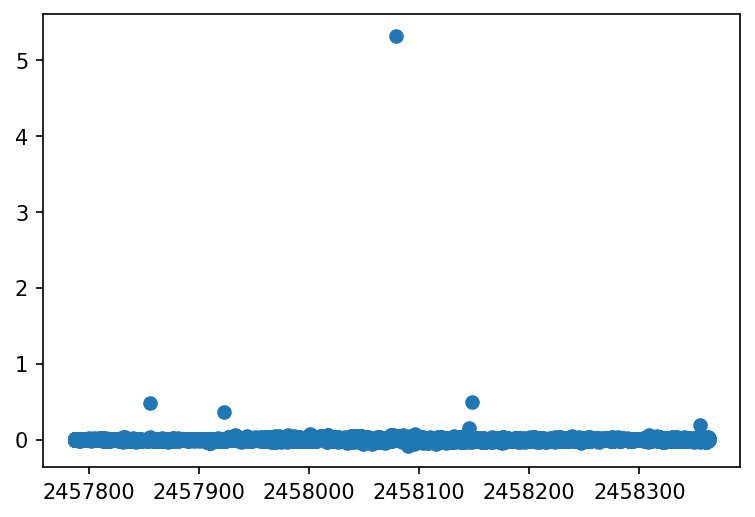

In [28]:
plt.scatter(jd, reduced)

## sigma clip bRing data

In [29]:
clip1 = sigma_clip(reduced, sigma=5, cenfunc=np.median, iters=1)
mags_clip1 = clip1[~clip1.mask].data
times_clip1 = jd[~clip1.mask]

clipN = sigma_clip(reduced, sigma=4, cenfunc=np.median, iters=None)
mags_clipN = clipN[~clipN.mask].data
times_clipN = jd[~clipN.mask]

In [30]:
t_bRing = times_clip1
m_bRing = mags_clip1

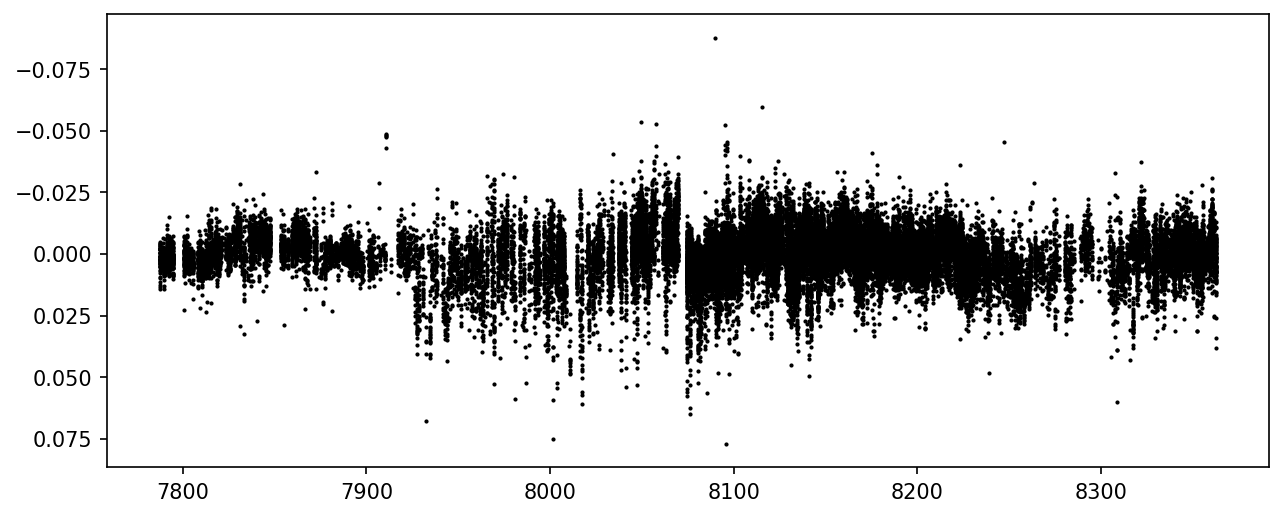

In [31]:
fig, ax = plt.subplots(1,1,figsize=(10,4))

plt.scatter(times_clip1-2450000, mags_clip1, s=1, c='k')
ax.invert_yaxis()
#ax.set_ylim(-125/1000,125/1000)

[47.43891623 53.6913807  50.49187966]
[0.00132126 0.00127501 0.00103584]
3


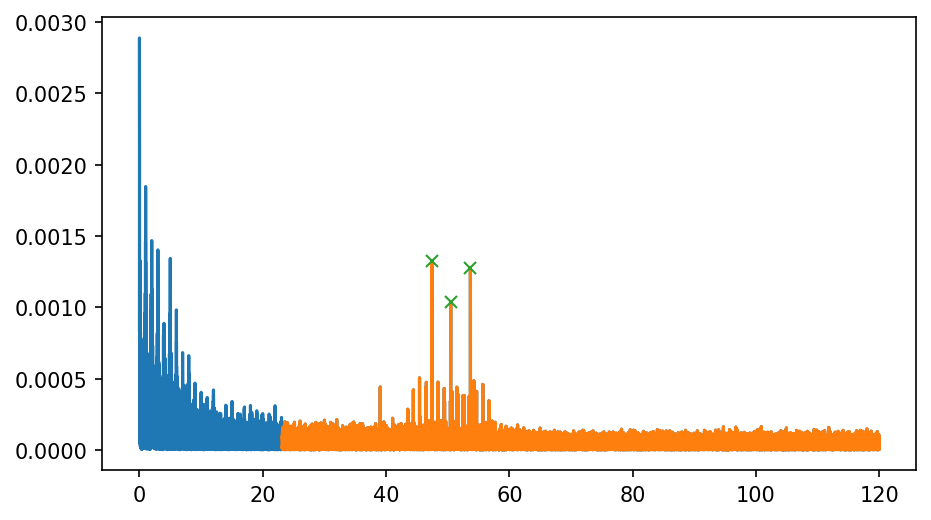

In [32]:
#AS
freq, amp = AS(times_clip1, mags_clip1-np.mean(mags_clip1), 15)

#         timebase = max(times) - min(times)
#         tmin = times.min()
#         tmax = times.max()
#         df = 1.0 / (tmax - tmin)
#         dt = np.median(np.diff(times))
#         ny = 0.5 / dt
#         oversample = 25

#         #create ampl spectrum

fig, ax = plt.subplots(1, 1, figsize=(7, 4))

#         freq = np.arange(df, ny/4, df / oversample)
#         model = LombScargle(times, mags)
#         power = model.power(freq, method = 'fast', normalization = 'psd')
#         fct = np.sqrt(4 / len(times))
#         amp = np.sqrt(np.abs(power)) * fct

ax.plot(freq, amp)


freq=freq[200000:]
amp=amp[200000:]
ax.plot(freq, amp)


max_power = amp.max()

peaks, _ = find_peaks(amp, height=max_power*0.6, distance=300)
ax.plot(freq[peaks], amp[peaks], "x")


sort_idx = np.argsort(amp[peaks])[::-1]
f_TESS = freq[peaks][sort_idx]
a_TESS = amp[peaks][sort_idx]

print(f_TESS)
print(a_TESS)
print(len(f_TESS))

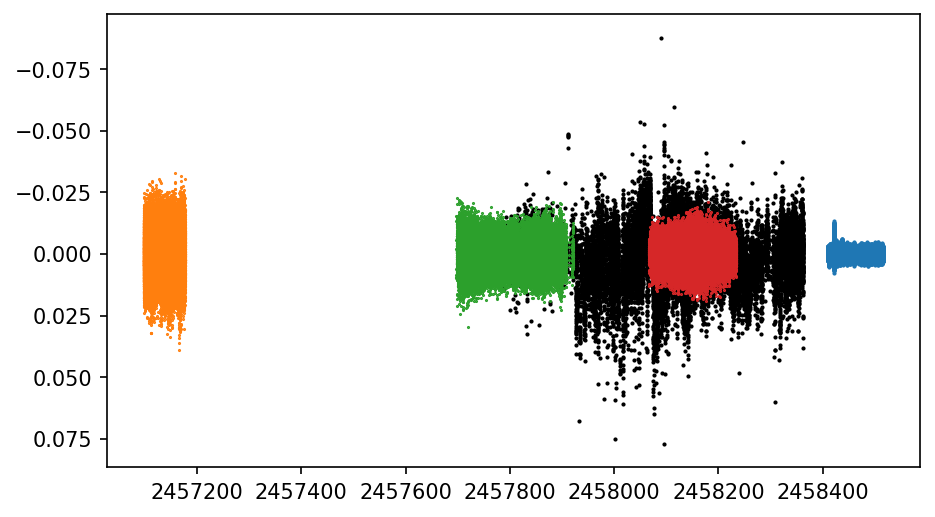

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax.scatter(times_clip1, mags_clip1, s=1, c='k')

ax.scatter(x,y, s=1)

ax.scatter(tB15_BJD, mB15/1000, marker='.', s=1)
ax.scatter(tB16_BJD, mB16/1000, marker='.', s=1)
ax.scatter(tB17_BJD, mB17/1000, marker='.', s=1)

ax.invert_yaxis()

In [36]:
x

array([2458410.90352425, 2458410.90491317, 2458410.90630209, ...,
       2458516.08417223, 2458516.08556108, 2458516.08694993])

In [37]:
y

array([ 0.00092888,  0.00028256, -0.00028116, ...,  0.00150548,
        0.00110792,  0.00023071], dtype=float32)

In [38]:
t_combT = x
m_combT = y

t_combB = np.concatenate((tB15_BJD, tB16_BJD, tB17_BJD), axis=None)
m_combB = np.concatenate((mB15/1000, mB16/1000, mB17/1000), axis=None)

t_combBT = np.concatenate((tB15_BJD, tB16_BJD, tB17_BJD,x), axis=None)
m_combBT = np.concatenate((mB15/1000, mB16/1000, mB17/1000,y), axis=None)

t_combbT = np.concatenate((times_clip1, x), axis=None)
m_combbT = np.concatenate((mags_clip1, y), axis=None)

[3.29319841e-03 4.74388890e+01 5.36913921e+01 5.04917754e+01]
[0.00145426 0.00115128 0.00108778 0.0009715 ]
4


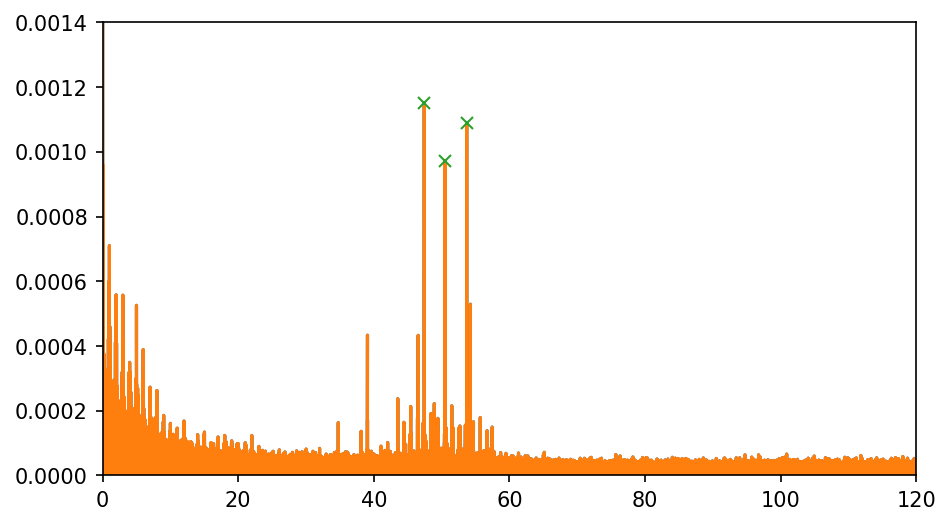

In [39]:
#AS
freq, amp = AS(t_combbT, m_combbT, 15)
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax.plot(freq, amp)


#freq=freq[200000:]
#amp=amp[200000:]
ax.plot(freq, amp)


max_power = amp.max()

peaks, _ = find_peaks(amp, height=max_power*0.6, distance=300)
ax.plot(freq[peaks], amp[peaks], "x")

ax.set_xlim(0,120)
ax.set_ylim(0,1.4/1000)


sort_idx = np.argsort(amp[peaks])[::-1]
f_TESS = freq[peaks][sort_idx]
a_TESS = amp[peaks][sort_idx]

print(f_TESS)
print(a_TESS)
print(len(f_TESS))

#plt.savefig('bRT.png')

# ASTEP

In [40]:
datadir = os.getcwd() 
datadir_ASTEP = '/ASTEP'

astep17 = np.recfromcsv(datadir+datadir_ASTEP+'/bjd_bp_flux_2017.csv')
astep18 = np.recfromcsv(datadir+datadir_ASTEP+'/bjd_bp_flux_2018.csv')

In [41]:
def moving_mean(x, y, yerr=None, window=3.):
    """ Compute a moving mean along the x-axis. """

    # Set the weights.
    if yerr is None:
        weights = np.ones_like(y)
    else:
        weights = 1/yerr**2

    # Sums for computing the mean.
    sum1 = np.append(0, np.cumsum(weights*y))
    sum2 = np.append(0, np.cumsum(weights))

    # Indices at the start and end of the window.
    i = np.searchsorted(x, x - window/2.)
    j = np.searchsorted(x, x + window/2.)

    # Compute the mean.
    mean = (sum1[j] - sum1[i])/(sum2[j] - sum2[i])

    return mean


In [42]:
sum((astep17['xs1'] == 2048))

60894

In [43]:
set((2048,2049))

{2048, 2049}

In [44]:
(astep17['xs1'] == 2047)|(astep17['xs1'] == 2048)|(astep17['xs1'] == 2049)

array([False, False, False, ..., False, False, False])

In [45]:
(astep17['ys1'] == 2047)|(astep17['ys1'] == 2048)|(astep17['ys1'] == 2049)

array([False, False, False, ..., False, False, False])

In [46]:
(astep17['xs1'] == 2047)|(astep17['xs1'] == 2048)|(astep17['xs1'] == 2049) & (astep17['ys1'] == 2047)|(astep17['ys1'] == 2048)|(astep17['ys1'] == 2049)

array([False, False, False, ..., False, False, False])

In [198]:
sum((astep17['xs1'] == 2047)|(astep17['xs1'] == 2048)|(astep17['xs1'] == 2049))

75678

In [49]:
astep17flux = (astep17['flux1']-4*astep17['fsky1'])/(astep17['flux3']-4*astep17['fsky3'])
astep18flux = (astep18['flux1']-4*astep18['fsky1'])/(astep18['flux3']-4*astep18['fsky3'])
astep17nflux = astep17flux/np.nanmedian(astep17flux)
astep18nflux = astep18flux/np.nanmedian(astep18flux)
a17sel = np.where(np.isfinite(astep17nflux) & (astep17['sunelev'] < -18) & (astep17['xs1'] == 2048) & (astep17['ys1'] == 2048))[0]
a18sel = np.where(np.isfinite(astep18nflux) & (astep18['sunelev'] < -18) & (astep18['xs1'] == 2048) & (astep18['ys1'] == 2048))[0]

(0, 2)

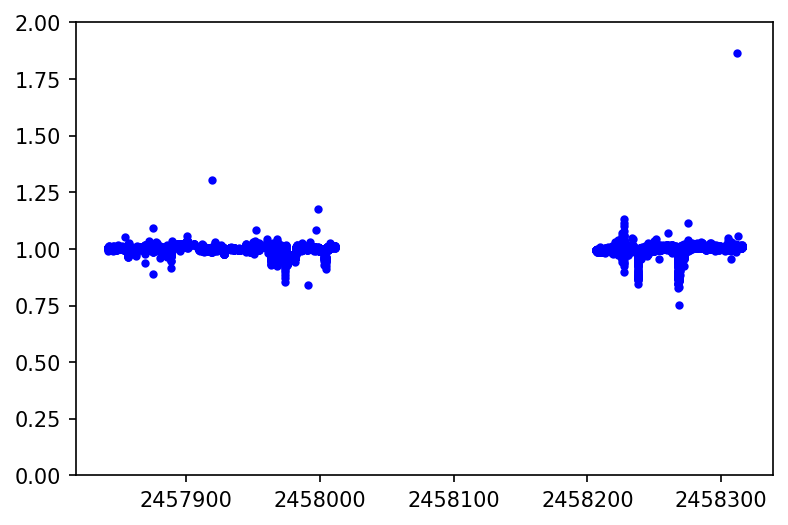

In [50]:
plt.plot(astep17['bjd'][a17sel]+2400000,astep17nflux[a17sel],'.b',label='ASTEP')
plt.plot(astep18['bjd'][a18sel]+2400000,astep18nflux[a18sel],'.b')

plt.ylim(0,2)

In [51]:
t_ASTEP = np.concatenate((astep17['bjd'][a17sel]+2400000, astep18['bjd'][a18sel]+2400000), axis=None)
m_ASTEP = np.concatenate((astep17nflux[a17sel], astep18nflux[a18sel]), axis=None)

[47.43902191 53.69135914 50.49181882 46.43908649 48.43895732 52.69142372
 51.49161367 49.49202397 54.69143511 39.06312209 54.23728958 40.06277639
 14.74363583]
[0.00109401 0.00089191 0.00088441 0.00072201 0.00061438 0.00061062
 0.00057228 0.00052402 0.00049059 0.00044807 0.00038967 0.00037409
 0.00035771]
13


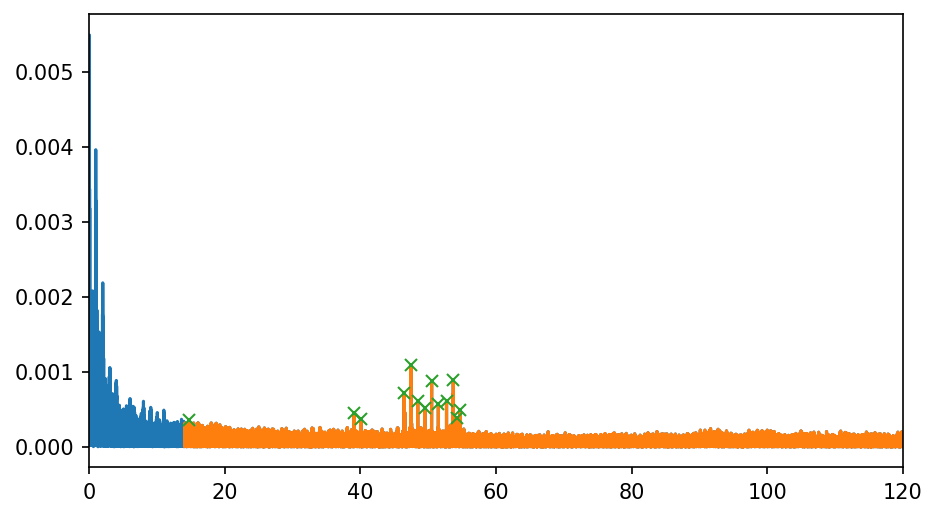

In [52]:
#AS
freq, amp = AS(t_ASTEP, m_ASTEP, 15)
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax.plot(freq, amp)


freq=freq[100000:]
amp=amp[100000:]
ax.plot(freq, amp)


max_power = amp.max()

peaks, _ = find_peaks(amp, height=max_power*0.3, distance=1000)
ax.plot(freq[peaks], amp[peaks], "x")

ax.set_xlim(0,120)
#ax.set_ylim(0,1.4/1000)


sort_idx = np.argsort(amp[peaks])[::-1]
f_TESS = freq[peaks][sort_idx]
a_TESS = amp[peaks][sort_idx]

print(f_TESS)
print(a_TESS)
print(len(f_TESS))
plt.show()
#plt.savefig('bRT.png')

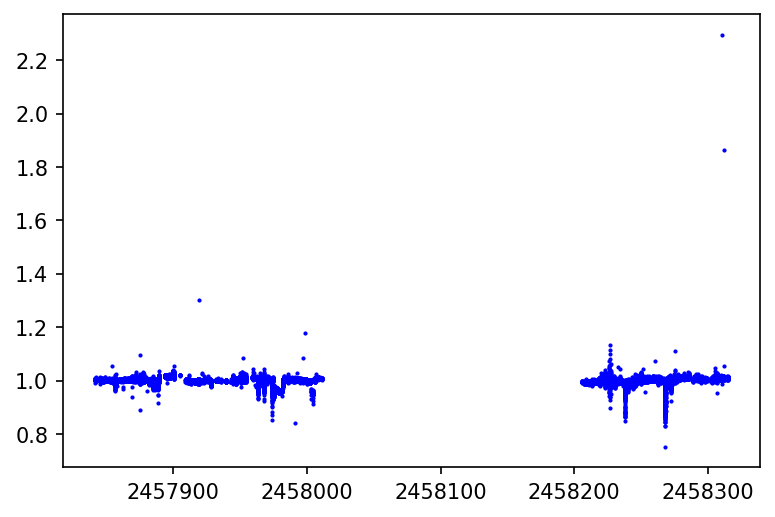

In [53]:
plt.scatter(astep17['bjd'][a17sel]+2400000,astep17nflux[a17sel],c='b',label='ASTEP', s=1)
plt.scatter(astep18['bjd'][a18sel]+2400000,astep18nflux[a18sel],c='b',label='ASTEP', s=1)
plt.show()

In [54]:
clip1 = sigma_clip(m_ASTEP, sigma=5, cenfunc=np.median, iters=1)
mags_clip1 = clip1[~clip1.mask].data
times_clip1 = (t_ASTEP)[~clip1.mask]

In [55]:
len(times_clip1)

64035

In [56]:
len(times_clip1)

64035

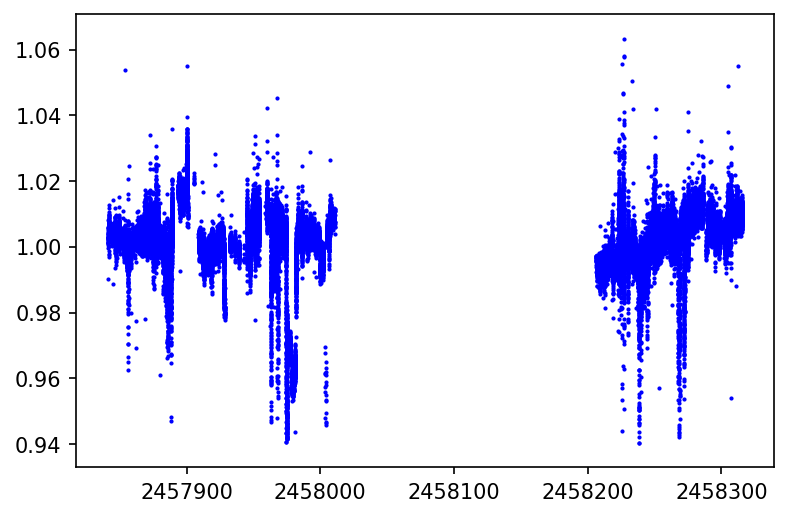

In [57]:
plt.scatter(times_clip1,mags_clip1,c='b',label='ASTEP', s=1)

In [58]:
t_ASTEP = times_clip1
m_ASTEP = -2.5*np.log10(mags_clip1)

[47.43902191 50.49181882 53.69135914 46.43894593 48.43909788 51.49189479
 49.49188341 52.69128316 54.69157567 54.23728958 39.06312209 53.2372136 ]
[0.00111932 0.00093422 0.00092001 0.00074192 0.00067516 0.00061026
 0.00059871 0.00059121 0.0005576  0.00050113 0.00045255 0.00034642]
12


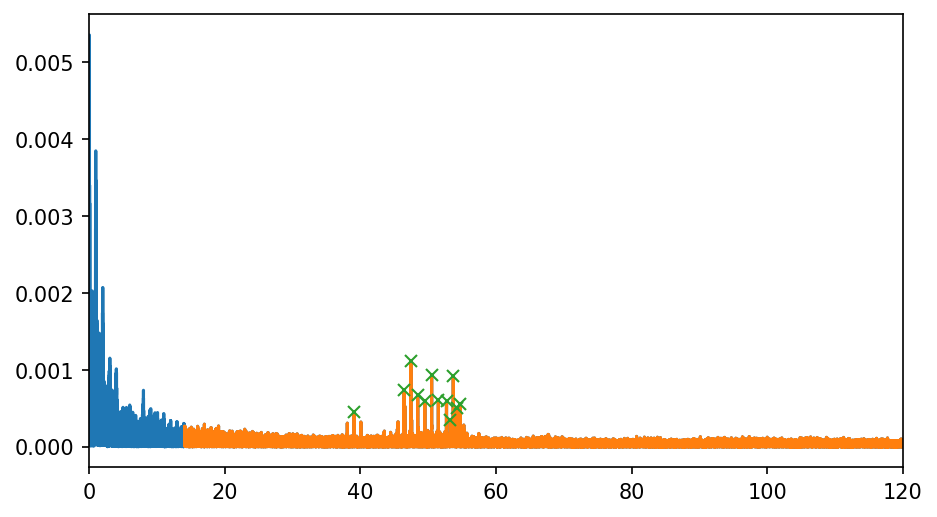

In [59]:
#AS
freq, amp = AS(t_ASTEP, m_ASTEP, 15)
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax.plot(freq, amp)


freq=freq[100000:]
amp=amp[100000:]
ax.plot(freq, amp)


max_power = amp.max()

peaks, _ = find_peaks(amp, height=max_power*0.3, distance=1000)
ax.plot(freq[peaks], amp[peaks], "x")

ax.set_xlim(0,120)
#ax.set_ylim(0,1.4/1000)


sort_idx = np.argsort(amp[peaks])[::-1]
f_TESS = freq[peaks][sort_idx]
a_TESS = amp[peaks][sort_idx]

print(f_TESS)
print(a_TESS)
print(len(f_TESS))
plt.show()
#plt.savefig('bRT.png')

In [60]:
t_2015 = 2457024.0-2457000.0
t_2016 = 2457389.0-2457000.0
t_2017 = 2457755.0-2457000.0
t_2018 = 2458120.0-2457000.0
t_2019 = 2458485.0-2457000.0

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax.scatter(t_bRing-2457000, m_bRing*1000, s=1, c='k', label = 'bRing', marker='.')

ax.scatter(x-2457000, y*1000, s=1, label = 'TESS', marker='.')

t_combB = np.concatenate((tB15_BJD, tB16_BJD, tB17_BJD), axis=None)
m_combB = np.concatenate((mB15/1000, mB16/1000, mB17/1000), axis=None)

ax.scatter(t_combB-2457000, m_combB*1000, marker='.', s=1, c = 'darkgreen', label = 'BRITE')

#ax.scatter(tB16_BJD, mB16/1000, marker='.', s=1)
#ax.scatter(tB17_BJD, mB17/1000, marker='.', s=1)

ax.scatter(t_ASTEP-2457000, m_ASTEP*1000, marker='.', s=1, c='r', label = 'ASTEP')

ax.invert_yaxis()

ax.set_xlim(0, 1600)
ax.set_ylim(100, -100)


ax.set_xlabel('Time [BJD - 2457000]')
ax.set_ylabel('Inst. magnitude [mmag]')



ax2 = ax.twiny()
ax2.tick_params(axis='x', rotation=0)


ax2.set_xticks([t_2015,t_2016,t_2017,t_2018,t_2019])

xmin1, xmax1 = ax.get_xlim()
ax2.set_xlim(xmin1,xmax1)
ax2.set_xticklabels(['2015', '2016', '2017', '2018', '2019'],fontsize=10)
ax2.set_xlabel('Time [year]')


ax.legend(markerscale=10)

#plt.savefig('total_lc.png', dpi = 550)

In [61]:
t_TESS = x
m_TESS = y

t_combBT = np.concatenate((tB15_BJD, tB16_BJD, tB17_BJD, x), axis=None)
m_combBT = np.concatenate((mB15/1000, mB16/1000, mB17/1000, y), axis=None)

t_combRT = np.concatenate((t_bRing, x), axis=None)
m_combRT = np.concatenate((m_bRing, y), axis=None)

t_combAT = np.concatenate((t_ASTEP, x), axis=None)
m_combAT = np.concatenate((m_ASTEP, y), axis=None)

In [62]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import math 
import scipy.special

plt.rc('font', family='serif', size=11)
plt.tight_layout()

from matplotlib import rcParams
rcParams["figure.dpi"] = 150

<Figure size 432x288 with 0 Axes>

In [63]:
#Expected units:
#t ... Time in days
#a1sini ... in seconds
#Porb ... in days
#star_planet_ratio ... how many times heavier is the star?

def tau(t, star_planet_ratio, a2sini , e, varpi, Porb, tp, nobessel):
    
    Omega = 2 * np.pi / Porb
    
    term1 = -a2sini / star_planet_ratio * 499 / 86400
    term2 = (1-e**2)
    
    sum_cosf = sum(scipy.special.jv(n,n*e)*np.cos(n*Omega*(t-tp)) for n in range(1,nobessel))
    sum_sinf = sum(scipy.special.jvp(n,n*e,n=1)*np.sin(n*Omega*(t-tp)) for n in range(1,nobessel))
    
    
    cosf  = - e + 2*(1-e**2)/e * sum_cosf
    sinf  = 2 * math.sqrt(1 - e**2) * sum_sinf
    
    term3 = (sinf * np.cos(varpi) + cosf * np.sin(varpi))/(1. + e*cosf)
    
    sol = term1*term2*term3
    
    return sol

def vrad(t, star_planet_ratio, a2sini , e, varpi, Porb, tp, nobessel):
    
    Omega = 2 * np.pi / Porb
    
    term1 = - Omega * a2sini / star_planet_ratio *1.736*10**6 #num.value is AU/day into m/s
    term2 = math.sqrt(1-e**2)
    
    sum_cosf = sum(scipy.special.jv(n,n*e)*np.cos(n*Omega*(t-tp)) for n in range(1,nobessel))
    sum_sinf = sum(scipy.special.jvp(n,n*e,n=1)*np.sin(n*Omega*(t-tp)) for n in range(1,nobessel))
    
    
    cosf  = - e + 2*(1-e**2)/e * sum_cosf
    sinf  = 2 * math.sqrt(1 - e**2) * sum_sinf
    
    term3 = (cosf * np.cos(varpi) - sinf * np.sin(varpi)) + e * np.cos(varpi)
    
    sol = term1*term2*term3
    
    return sol

In [64]:
from astropy.time import Time
jds = []
for i in np.arange(2012, 2024, 2):
    times = ['{0}-01-01T12:00:00'.format(i)]
    t = Time(times, format='isot', scale='utc')
    print(t)
    print(t.jd)
    jds.append(t.jd[0])

['2012-01-01T12:00:00.000']
[2455928.]
['2014-01-01T12:00:00.000']
[2456659.]
['2016-01-01T12:00:00.000']
[2457389.]
['2018-01-01T12:00:00.000']
[2458120.]
['2020-01-01T12:00:00.000']
[2458850.]
['2022-01-01T12:00:00.000']
[2459581.]


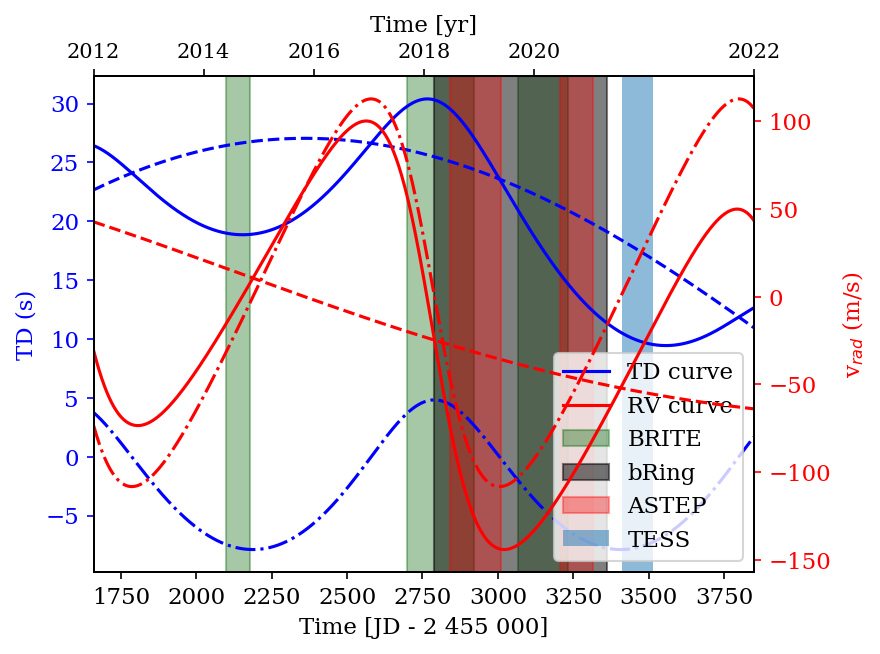

In [196]:
from matplotlib.patches import Patch

time_offset =  2455000

x = np.arange(jds[0], jds[-1], 1)

#_b
star_planet_ratio_b = 1.8 / 11 * 1048
a2sini_b = 9.66 * np.sin(np.deg2rad(88.81))
e_b = 0.08
varpi_b = np.deg2rad(205.8)
Porb_b = 22.47*365.25
tp_b = 2455992

#_c
star_planet_ratio_c = 1.8 / 8.9 * 1048
a2sini_c = 2.7 * np.sin(np.deg2rad(88.81))
e_c = 0.24
varpi_c = np.deg2rad(-95)
Porb_c = 1220
tp_c = 2454117

y_tau_b = tau(x, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 1000)
y_vrad_b = vrad(x, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 1000)

y_tau_c = tau(x, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 1000)
y_vrad_c = vrad(x, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 1000)





fig, ax1 = plt.subplots(1,1, figsize=(6, 4.5))

ax1.set_xlim(jds[0] - time_offset, jds[-1] - time_offset)

lns1 = ax1.plot(x - time_offset, (y_tau_b + y_tau_c) *86400, 'b', label = "TD curve")
ax1.plot(x - time_offset, (y_tau_b) *86400, 'b', label = "TD curve", ls = '--')
ax1.plot(x - time_offset, (y_tau_c) *86400, 'b', label = "TD curve", ls = '-.')
ax1.set_xlabel('Time [JD - 2 455 000]')

ax1.set_ylabel('TD (s)', color='b')
ax1.tick_params('y', colors='b')


ax2 = ax1.twinx()

lns2 = ax2.plot(x - time_offset, y_vrad_b + y_vrad_c, 'r', label = "RV curve")
ax2.plot(x - time_offset, y_vrad_b , 'r', label = "RV curve", ls = '--')
ax2.plot(x - time_offset, y_vrad_c, 'r', label = "RV curve", ls = '-.')
ax2.set_ylabel('v$_{rad}$ (m/s)', color='r')
ax2.tick_params('y', colors='r')

#lns = lns1+lns2
#labs = [l.get_label() for l in lns]


ax2 = ax1.twiny()
ax2.tick_params(axis='x', rotation=0)

t_2012 = jds[0] - time_offset
t_2014 = jds[1] - time_offset
t_2016 = jds[2] - time_offset
t_2018 = jds[3] - time_offset
t_2020 = jds[4] - time_offset
t_2022 = jds[-1] - time_offset


ax2.set_xticks([t_2012,t_2014,t_2016,t_2018,t_2020, t_2022])

#ax1.set_xlim(1070,1090)
#ax1.set_ylim(-120,70)


xmin1, xmax1 = ax1.get_xlim()
ax2.set_xlim(xmin1,xmax1)
ax2.set_xticklabels(['2012', '2014', '2016', '2018', '2020', '2022'], fontsize=10)


ax2.set_xlabel('Time [yr]', labelpad=-200)
ax2.xaxis.set_label_coords(0.5,1.09)


#ax1.set_xlabel('BJD - 2457000.0 [d]')
#ax1.set_ylabel('magnitudes [mmag]')

#ttl = ax1.title
#ttl.set_position([.5, 1.05])

#ax1.set_title('bRing+BLb')


lns3 = ax1.axvspan(min(t_TESS) - time_offset, max(t_TESS) - time_offset, alpha=0.5,  label='TESS')
lns4 = ax1.axvspan(min(tB15_BJD) - time_offset, max(tB15_BJD) - time_offset, alpha=0.35, color='darkgreen', label='BRITE')
ax1.axvspan(min(tB16_BJD) - time_offset, max(tB16_BJD) - time_offset, alpha=0.35, color='darkgreen')
ax1.axvspan(min(tB17_BJD) - time_offset, max(tB17_BJD) - time_offset, alpha=0.35, color='darkgreen')
lns5 = ax1.axvspan(min(t_bRing) - time_offset, max(t_bRing) - time_offset, alpha=0.5, color='k', label='bRing')
lns6 = ax1.axvspan(min(t_ASTEP) - time_offset, 2458011.168025- time_offset, alpha=0.35, color='red', label='ASTEP')
ax1.axvspan(2458206.1510377- time_offset, max(t_ASTEP) - time_offset, alpha=0.35, color='red')


lns = [lns1[0], lns2[0], lns4, lns5, lns6, lns3]
labs = [l.get_label() for l in lns]

#ax1.legend()
ax1.legend(lns, labs, loc=4)

fig.tight_layout()
plt.show()

#fig.savefig("TDRV.png", dpi=400)

In [198]:
jds = []
for i in np.arange(2005, 2030, 5):
    times_utc = ['{0}-01-01T12:00:00'.format(i)]
    t = Time(times_utc, format='isot', scale='utc')
    print(t)
    print(t.jd)
    jds.append(t.jd[0])

['2005-01-01T12:00:00.000']
[2453372.]
['2010-01-01T12:00:00.000']
[2455198.]
['2015-01-01T12:00:00.000']
[2457024.]
['2020-01-01T12:00:00.000']
[2458850.]
['2025-01-01T12:00:00.000']
[2460677.]


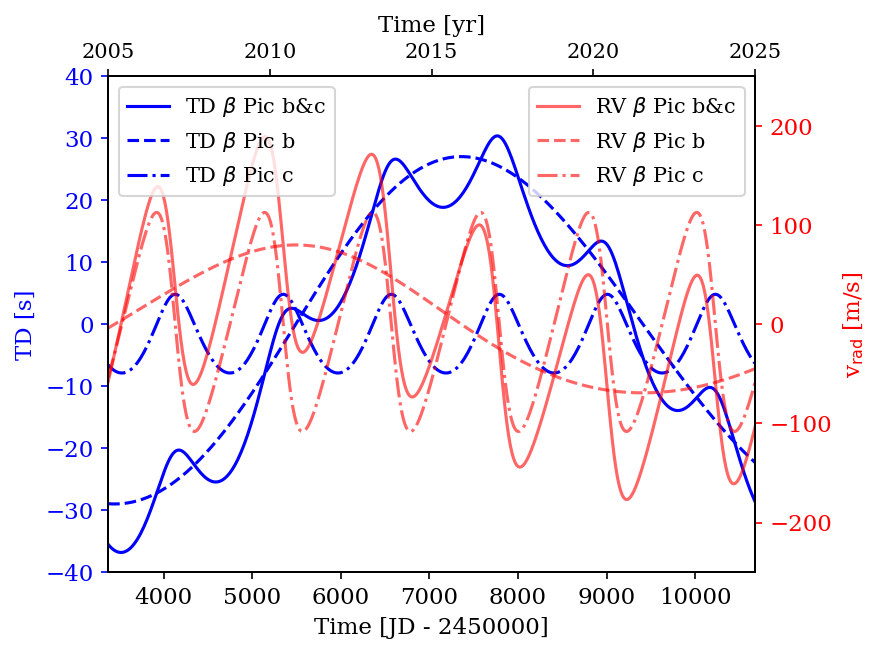

In [199]:
times_sim = np.linspace(jds[0], jds[-1], 400)

y_tau_b_sim = tau(times_sim, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_vrad_b_sim = vrad(times_sim, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)

y_tau_c_sim = tau(times_sim, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)
y_vrad_c_sim = vrad(times_sim, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)

fig, ax1 = plt.subplots(1,1, figsize=(6, 4.5))

time_offset = 2450000

ax1.set_xlim(jds[0] - time_offset, jds[-1] - time_offset)



ax2 = ax1.twinx()

lns21 = ax2.plot(times_sim - time_offset, y_vrad_b_sim + y_vrad_c_sim, 'r', label = r"RV $\beta$ Pic b&c", alpha = 0.6)
lns22 = ax2.plot(times_sim - time_offset, y_vrad_b_sim, 'r', label = r"RV $\beta$ Pic b", ls = '--', alpha = 0.6)
lns23 = ax2.plot(times_sim - time_offset, y_vrad_c_sim, 'r', label = r"RV $\beta$ Pic c", ls = '-.', alpha = 0.6)
ax2.set_ylabel('v$_\mathrm{rad}$ [m/s]', color='r')
ax2.tick_params('y', colors='r')
ax2.set_ylim(-250,250)


ax2 = ax1.twiny()
ax2.tick_params(axis='x', rotation=0)











lns11 = ax1.plot(times_sim - time_offset, (y_tau_b_sim + y_tau_c_sim) *86400, 'b', label = r"TD $\beta$ Pic b&c", zorder = 0)
lns12 = ax1.plot(times_sim - time_offset, (y_tau_b_sim) *86400, 'b', ls = '--', label = r"TD $\beta$ Pic b")
lns13 = ax1.plot(times_sim - time_offset, (y_tau_c_sim) *86400, 'b', ls = '-.', label = r"TD $\beta$ Pic c")
ax1.set_xlabel('Time [JD - 2450000]')
ax1.set_ylabel('TD [s]', color='b')
ax1.tick_params('y', colors='b')
ax1.set_ylim(-40,40)






t_2005 = jds[0] - time_offset
t_2010 = jds[1] - time_offset
t_2015 = jds[2] - time_offset
t_2020 = jds[3] - time_offset
t_2025 = jds[4] - time_offset


ax2.set_xticks([t_2005,t_2010,t_2015,t_2020,t_2025])


xmin1, xmax1 = ax1.get_xlim()
ax2.set_xlim(xmin1,xmax1)
ax2.set_xticklabels(['2005', '2010', '2015', '2020', '2025'], fontsize=10)

ax2.set_xlabel('Time [yr]', labelpad=-200)
ax2.xaxis.set_label_coords(0.5,1.09)

# ax1.scatter(tB15_BJD - time_offset, [38]*len(tB15_BJD), marker = "s", s=10, color='darkgreen')
# ax1.scatter(tB16_BJD - time_offset, [38]*len(tB16_BJD), marker = "s", s=10, color='darkgreen')
# ax1.scatter(tB17_BJD - time_offset, [38]*len(tB17_BJD), marker = "s", s=10, color='darkgreen')
# ax1.scatter(t_bRing - time_offset, [36]*len(t_bRing), marker = "s", color='k', s=2)
# ax1.scatter(t_ASTEP - time_offset, [32]*len(t_ASTEP), marker = "s", color='red', s=2)
# ax1.scatter(t_TESS - time_offset, [34]*len(t_TESS), marker = "s", s=2)


# lns4 = ax1.axvspan(min(tB15_BJD) - time_offset, max(tB15_BJD) - time_offset, alpha=0.35, color='darkgreen', label='BRITE')
# ax1.axvspan(min(tB16_BJD) - time_offset, max(tB16_BJD) - time_offset, alpha=0.35, color='darkgreen')
# ax1.axvspan(min(tB17_BJD) - time_offset, max(tB17_BJD) - time_offset, alpha=0.35, color='darkgreen')
# lns5 = ax1.axvspan(min(t_bRing) - time_offset, max(t_bRing) - time_offset, alpha=0.5, color='k', label='bRing')
# lns6 = ax1.axvspan(min(t_ASTEP) - time_offset, 2458011.168025- time_offset, alpha=0.35, color='red', label='ASTEP')
# ax1.axvspan(2458206.1510377- time_offset, max(t_ASTEP) - time_offset, alpha=0.35, color='red')

ax2.set_zorder(100)
#ax1.set_zorder(100)



lns1 = [lns11[0], lns12[0], lns13[0]]
lns2 = [lns21[0], lns22[0], lns23[0]]

#, lns3]#lns2[0], lns4, lns5, lns6, lns3]
#lns = [lns1[0], lns2[0], lns3]#lns2[0], lns4, lns5, lns6, lns3]
labs1 = [l.get_label() for l in lns1]
labs2 = [l.get_label() for l in lns2]


ax1.legend(lns2, labs2, loc=1, prop={'size': 10})
ax2.legend(lns1, labs1, loc=2, prop={'size': 10})

fig.tight_layout()
plt.show()

fig.savefig("TDRV_all1.png", dpi=400)
fig.savefig("TDRV_all1.pdf")

In [122]:
min(tB15_BJD)

2457097.98961235

In [123]:
max(t_TESS)

2458516.0869499347

In [200]:
jds = []
for i in np.arange(2014, 2021, 1):
    times_utc = ['{0}-01-01T12:00:00'.format(i)]
    t = Time(times_utc, format='isot', scale='utc')
    print(t)
    print(t.jd)
    jds.append(t.jd[0])

['2014-01-01T12:00:00.000']
[2456659.]
['2015-01-01T12:00:00.000']
[2457024.]
['2016-01-01T12:00:00.000']
[2457389.]
['2017-01-01T12:00:00.000']
[2457755.]
['2018-01-01T12:00:00.000']
[2458120.]
['2019-01-01T12:00:00.000']
[2458485.]
['2020-01-01T12:00:00.000']
[2458850.]


In [148]:
(max(t_TESS)-min(t_TESS))/2+min(t_TESS)

2458463.4952370906

In [157]:
2458463.495 - time_offset

8463.495000000112

In [169]:
times_sim[328:] - time_offset

array([8460.12280702, 8465.61403509, 8471.10526316, 8476.59649123,
       8482.0877193 , 8487.57894737, 8493.07017544, 8498.56140351,
       8504.05263158, 8509.54385965, 8515.03508772, 8520.52631579,
       8526.01754386, 8531.50877193, 8537.        , 8542.49122807,
       8547.98245614, 8553.47368421, 8558.96491228, 8564.45614035,
       8569.94736842, 8575.43859649, 8580.92982456, 8586.42105263,
       8591.9122807 , 8597.40350877, 8602.89473684, 8608.38596491,
       8613.87719298, 8619.36842105, 8624.85964912, 8630.35087719,
       8635.84210526, 8641.33333333, 8646.8245614 , 8652.31578947,
       8657.80701754, 8663.29824561, 8668.78947368, 8674.28070175,
       8679.77192982, 8685.26315789, 8690.75438596, 8696.24561404,
       8701.73684211, 8707.22807018, 8712.71929825, 8718.21052632,
       8723.70175439, 8729.19298246, 8734.68421053, 8740.1754386 ,
       8745.66666667, 8751.15789474, 8756.64912281, 8762.14035088,
       8767.63157895, 8773.12280702, 8778.61403509, 8784.10526

In [170]:
y_tau_b_sim[328:]
#0.000233

array([0.00023346, 0.0002329 , 0.00023234, 0.00023177, 0.0002312 ,
       0.00023063, 0.00023005, 0.00022946, 0.00022887, 0.00022828,
       0.00022768, 0.00022707, 0.00022646, 0.00022585, 0.00022523,
       0.00022461, 0.00022398, 0.00022335, 0.00022272, 0.00022208,
       0.00022143, 0.00022079, 0.00022013, 0.00021947, 0.00021881,
       0.00021815, 0.00021748, 0.0002168 , 0.00021612, 0.00021544,
       0.00021475, 0.00021406, 0.00021336, 0.00021266, 0.00021196,
       0.00021125, 0.00021054, 0.00020982, 0.0002091 , 0.00020838,
       0.00020765, 0.00020691, 0.00020618, 0.00020544, 0.00020469,
       0.00020394, 0.00020319, 0.00020243, 0.00020167, 0.00020091,
       0.00020014, 0.00019937, 0.00019859, 0.00019781, 0.00019703,
       0.00019624, 0.00019545, 0.00019466, 0.00019386, 0.00019306,
       0.00019225, 0.00019144, 0.00019063, 0.00018981, 0.00018899,
       0.00018817, 0.00018734, 0.00018651, 0.00018567, 0.00018484,
       0.00018399, 0.00018315])

In [171]:
y_tau_c_sim[328:]
#-8.885e-5

array([-8.91765501e-05, -8.88180011e-05, -8.84236261e-05, -8.79934151e-05,
       -8.75273618e-05, -8.70254639e-05, -8.64877230e-05, -8.59141449e-05,
       -8.53047399e-05, -8.46595233e-05, -8.39785151e-05, -8.32617407e-05,
       -8.25092315e-05, -8.17210244e-05, -8.08971630e-05, -8.00376976e-05,
       -7.91426857e-05, -7.82121926e-05, -7.72462915e-05, -7.62450645e-05,
       -7.52086030e-05, -7.41370082e-05, -7.30303916e-05, -7.18888763e-05,
       -7.07125969e-05, -6.95017011e-05, -6.82563498e-05, -6.69767185e-05,
       -6.56629979e-05, -6.43153953e-05, -6.29341353e-05, -6.15194608e-05,
       -6.00716350e-05, -5.85909417e-05, -5.70776872e-05, -5.55322019e-05,
       -5.39548412e-05, -5.23459878e-05, -5.07060531e-05, -4.90354789e-05,
       -4.73347397e-05, -4.56043445e-05, -4.38448390e-05, -4.20568080e-05,
       -4.02408777e-05, -3.83977182e-05, -3.65280463e-05, -3.46326286e-05,
       -3.27122837e-05, -3.07678861e-05, -2.88003691e-05, -2.68107282e-05,
       -2.48000245e-05, -

In [203]:
y_tau_b_sim = tau(np.array([2458463.4952370906]), star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
#y_vrad_b_sim = vrad(times_sim, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)

y_tau_c_sim = tau(np.array([2458463.4952370906]), star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)
#y_vrad_c_sim = vrad(times_sim, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)


In [205]:
y_tau_c_sim

array([-8.91205561e-05])

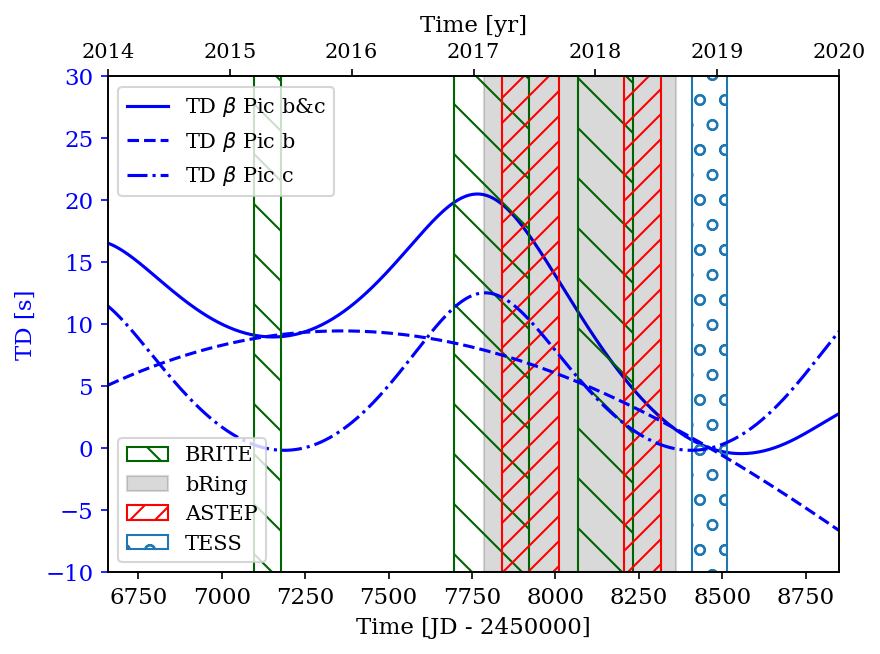

In [247]:
times_sim = np.linspace(jds[0], jds[-1], 400)

y_tau_b_sim = tau(times_sim, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_vrad_b_sim = vrad(times_sim, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)

y_tau_c_sim = tau(times_sim, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)
y_vrad_c_sim = vrad(times_sim, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)

fig, ax1 = plt.subplots(1,1, figsize=(6, 4.5))

time_offset = 2450000

ax1.set_xlim(jds[0] - time_offset, jds[-1] - time_offset)



#ax2 = ax1.twinx()

# lns21 = ax2.plot(times_sim - time_offset, y_vrad_b_sim + y_vrad_c_sim, 'r', label = r"RV $\beta$ Pic b&c", alpha = 0.6)
# lns22 = ax2.plot(times_sim - time_offset, y_vrad_b_sim, 'r', label = r"RV $\beta$ Pic b", ls = '--', alpha = 0.6)
# lns23 = ax2.plot(times_sim - time_offset, y_vrad_c_sim, 'r', label = r"RV $\beta$ Pic c", ls = '-.', alpha = 0.6)
# ax2.set_ylabel('v$_\mathrm{rad}$ [m/s]', color='r')
# ax2.tick_params('y', colors='r')
# ax2.set_ylim(-250,250)


ax2 = ax1.twiny()
ax2.tick_params(axis='x', rotation=0)











lns11 = ax1.plot(times_sim - time_offset, (y_tau_b_sim + y_tau_c_sim-0.00020359+8.91205561e-05) *86400, 'b', label = r"TD $\beta$ Pic b&c", zorder = 0)
lns12 = ax1.plot(times_sim - time_offset, (y_tau_b_sim-0.00020359) *86400, 'b', ls = '--', label = r"TD $\beta$ Pic b")
lns13 = ax1.plot(times_sim - time_offset, (y_tau_c_sim+8.91205561e-05) *86400, 'b', ls = '-.', label = r"TD $\beta$ Pic c")
ax1.set_xlabel('Time [JD - 2450000]')
ax1.set_ylabel('TD [s]', color='b')
ax1.tick_params('y', colors='b')
ax1.set_ylim(-10,30)






t_2014 = jds[0] - time_offset
t_2015 = jds[1] - time_offset
t_2016 = jds[2] - time_offset
t_2017 = jds[3] - time_offset
t_2018 = jds[4] - time_offset
t_2019 = jds[5] - time_offset
t_2020 = jds[6] - time_offset


ax2.set_xticks([t_2014, t_2015,t_2016,t_2017,t_2018,t_2019,t_2020])


xmin1, xmax1 = ax1.get_xlim()
ax2.set_xlim(xmin1,xmax1)
ax2.set_xticklabels(['2014', '2015', '2016', '2017', '2018', '2019', '2020'], fontsize=10)

ax2.set_xlabel('Time [yr]', labelpad=-200)
ax2.xaxis.set_label_coords(0.5,1.09)

# ax1.scatter(tB15_BJD - time_offset, [38]*len(tB15_BJD), marker = "s", s=10, color='darkgreen')
# ax1.scatter(tB16_BJD - time_offset, [38]*len(tB16_BJD), marker = "s", s=10, color='darkgreen')
# ax1.scatter(tB17_BJD - time_offset, [38]*len(tB17_BJD), marker = "s", s=10, color='darkgreen')
# ax1.scatter(t_bRing - time_offset, [36]*len(t_bRing), marker = "s", color='k', s=2)
# ax1.scatter(t_ASTEP - time_offset, [32]*len(t_ASTEP), marker = "s", color='red', s=2)
# ax1.scatter(t_TESS - time_offset, [34]*len(t_TESS), marker = "s", s=2)

#lns3 = ax1.axvspan(min(t_TESS) - time_offset, max(t_TESS) - time_offset, alpha=0.35, label='TESS')
# lns4 = ax1.axvspan(min(tB15_BJD) - time_offset, max(tB15_BJD) - time_offset, alpha=0.35, color='darkgreen', label='BRITE')
# ax1.axvspan(min(tB16_BJD) - time_offset, max(tB16_BJD) - time_offset, alpha=0.35, color='darkgreen')
# ax1.axvspan(min(tB17_BJD) - time_offset, max(tB17_BJD) - time_offset, alpha=0.35, color='darkgreen')
lns5 = ax1.axvspan(min(t_bRing) - time_offset, max(t_bRing) - time_offset, alpha=0.15, color='k', label='bRing')
# lns6 = ax1.axvspan(min(t_ASTEP) - time_offset, 2458011.168025- time_offset, alpha=0.35, color='red', label='ASTEP')
# ax1.axvspan(2458206.1510377- time_offset, max(t_ASTEP) - time_offset, alpha=0.35, color='red')

ax2.set_zorder(100)
#ax1.set_zorder(100)

#ax1.set_xlim(8463.495-0.1,8463.495+0.1)




lns31 = ax1.fill([min(tB15_BJD)- time_offset, max(tB15_BJD)- time_offset, max(tB15_BJD)- time_offset, min(tB15_BJD)- time_offset], [-40, -40, 40, 40], fill=False, hatch='\\', c = 'darkgreen', label='BRITE')
ax1.fill([min(tB16_BJD)- time_offset, max(tB16_BJD)- time_offset, max(tB16_BJD)- time_offset, min(tB16_BJD)- time_offset], [-40, -40, 40, 40], fill=False, hatch='\\', c = 'darkgreen')
ax1.fill([min(tB17_BJD)- time_offset, max(tB17_BJD)- time_offset, max(tB17_BJD)- time_offset, min(tB17_BJD)- time_offset], [-40, -40, 40, 40], fill=False, hatch='\\', c = 'darkgreen')

lns32 = ax1.fill([min(t_ASTEP)- time_offset, 2458011.168025- time_offset, 2458011.168025- time_offset, min(t_ASTEP)- time_offset], [-40, -40, 40, 40], fill=False, hatch='//', c = 'r', label='ASTEP')
ax1.fill([2458206.1510377- time_offset, max(t_ASTEP)- time_offset, max(t_ASTEP)- time_offset, 2458206.1510377- time_offset], [-40, -40, 40, 40], fill=False, hatch='//', c = 'r')

#ax1.fill([min(t_bRing)- time_offset, max(t_bRing)- time_offset, max(t_bRing)- time_offset, min(t_bRing)- time_offset], [-40, -40, 40, 40], fill=False, hatch='*', c = 'k')

lns34 = ax1.fill([min(t_TESS)- time_offset, max(t_TESS)- time_offset, max(t_TESS)- time_offset, min(t_TESS)- time_offset], [-40, -40, 40, 40], fill=False, hatch='o', c='C0', label='TESS')







lns1 = [lns11[0], lns12[0], lns13[0]]#, lns4, lns5, lns6, lns3]
lns2 = [lns31[0], lns5, lns32[0], lns34[0]]

#, 
#lns = [lns1[0], lns2[0], lns3]#lns2[0], lns4, lns5, lns6, lns3]
labs1 = [l.get_label() for l in lns1]
labs2 = [l.get_label() for l in lns2]



ax1.legend(lns2, labs2, loc=3, prop={'size': 10})
ax2.legend(lns1, labs1, loc=2, prop={'size': 10})

fig.tight_layout()
plt.show()



fig.savefig("TDRV_all_zoom.png", dpi=400)
fig.savefig("TDRV_all_zoom.pdf")

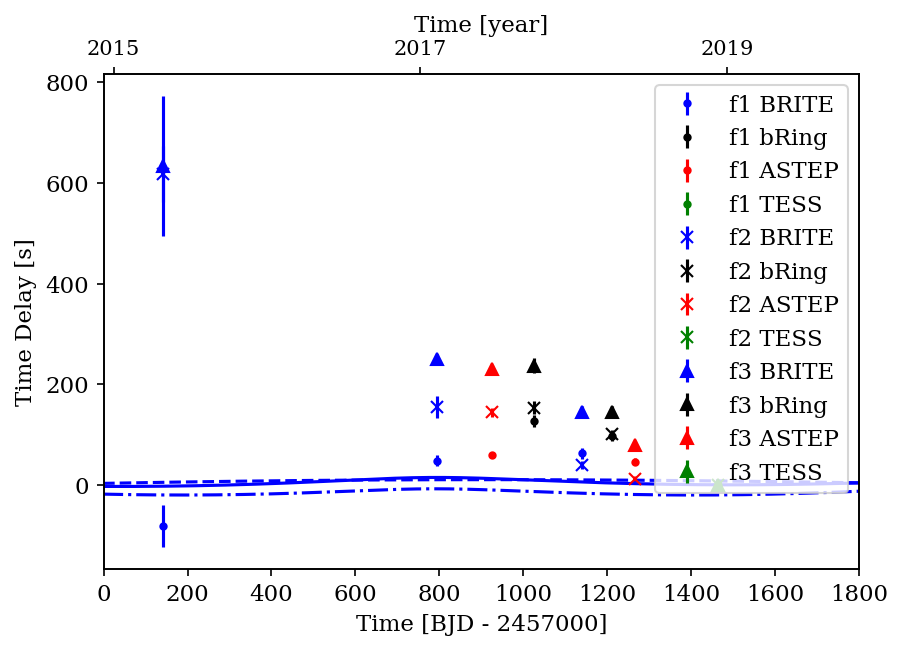

In [262]:
fig, ax = plt.subplots(1, 1, figsize=(6.5, 3.5*2.5/2))

i=0
ax.errorbar(np.array(t_td_BT)[:-1]-2457000, tau_td_BT[i][:-1], yerr = tau_err_td_BT[i][:-1]*86400, fmt='.', c='b', label='f1 BRITE')
ax.errorbar(np.array(t_td_RT)[:-1]-2457000, tau_td_RT[i][:-1], yerr = tau_err_td_RT[i][:-1]*86400, fmt='.', c='k', label='f1 bRing')
ax.errorbar(np.array(t_td_AT)[:-1]-2457000, tau_td_AT[i][:-1], yerr = tau_err_td_AT[i][:-1]*86400, fmt='.', c='r', label='f1 ASTEP')
ax.errorbar(np.array(t_td_AT)[-1]-2457000, tau_td_AT[i][-1], yerr = tau_err_td_AT[i][-1]*86400, fmt='.', c='g', label='f1 TESS')

i=1
ax.errorbar(np.array(t_td_BT)[:-1]-2457000, tau_td_BT[i][:-1], yerr = tau_err_td_BT[i][:-1]*86400, fmt='x', c='b', label='f2 BRITE')
ax.errorbar(np.array(t_td_RT)[:-1]-2457000, tau_td_RT[i][:-1], yerr = tau_err_td_RT[i][:-1]*86400, fmt='x', c='k', label='f2 bRing')
ax.errorbar(np.array(t_td_AT)[:-1]-2457000, tau_td_AT[i][:-1], yerr = tau_err_td_AT[i][:-1]*86400, fmt='x', c='r', label='f2 ASTEP')
ax.errorbar(np.array(t_td_AT)[-1]-2457000, tau_td_AT[i][-1], yerr = tau_err_td_AT[i][-1]*86400, fmt='x', c='g', label='f2 TESS')


i=2
ax.errorbar(np.array(t_td_BT)[:-1]-2457000, tau_td_BT[i][:-1], yerr = tau_err_td_BT[i][:-1]*86400, fmt='^', c='b', label='f3 BRITE')
ax.errorbar(np.array(t_td_RT)[:-1]-2457000, tau_td_RT[i][:-1], yerr = tau_err_td_RT[i][:-1]*86400, fmt='^', c='k', label='f3 bRing')
ax.errorbar(np.array(t_td_AT)[:-1]-2457000, tau_td_AT[i][:-1], yerr = tau_err_td_AT[i][:-1]*86400, fmt='^', c='r', label='f3 ASTEP')
ax.errorbar(np.array(t_td_AT)[-1]-2457000, tau_td_AT[i][-1], yerr = tau_err_td_AT[i][-1]*86400, fmt='^', c='g', label='f3 TESS')
    
    
ax.set_xlim(0, 1800)
#ax.set_ylim(100, -100)


ax.set_xlabel('Time [BJD - 2457000]')
ax.set_ylabel('Time Delay [s]')



ax2 = ax.twiny()
ax2.tick_params(axis='x', rotation=0)


ax2.set_xticks([t_2015,t_2016,t_2017,t_2018,t_2019])

xmin1, xmax1 = ax.get_xlim()
ax2.set_xlim(xmin1,xmax1)
ax2.set_xticklabels(['2015', '2016', '2017', '2018', '2019'],fontsize=10)
ax2.set_xlabel('Time [year]')

ax.legend(loc=1)

time_offset =  2457000

ax.plot(x - time_offset, (y_tau_b + y_tau_c) *86400-12, 'b', label = "TD curve")
ax.plot(x - time_offset, (y_tau_b) *86400-12, 'b', label = "TD curve", ls = '--')
ax.plot(x - time_offset, (y_tau_c) *86400-12, 'b', label = "TD curve", ls = '-.')

#ax.set_ylim(-80, 80)

#plt.savefig('final.png', dpi=300)

In [218]:
2450000.5 + 22.47*0.73*365.25

2455991.732275

In [219]:
for i in range(len(t_ASTEP)-1):
    if t_ASTEP[i+1] - t_ASTEP[i] > 6:
        print(t_ASTEP[i])
        print(t_ASTEP[i+1])

2458011.168025
2458206.1510377


# High pass

In [220]:
def highpass(flux, order, sigma):
    highpass_lst = []
    highpass_lst.append(flux)
    
    for i in range(0, order):
        lowpass = gaussian_filter(highpass_lst[i], sigma=sigma)
        highpass = highpass_lst[i] - lowpass
        highpass_lst.append(highpass)

    return highpass_lst

In [221]:
## TESS + BRITE

/home/sebastian/anaconda3/lib/python3.7/site-packages/lightkurve/periodogram.py:744: LightkurveWarning: Input light curve will be normalized.
  LightkurveWarning)
/home/sebastian/anaconda3/lib/python3.7/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:122: RuntimeWarning: divide by zero encountered in true_divide
  power = (YC * YC / CC + YS * YS / SS)
/home/sebastian/anaconda3/lib/python3.7/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:122: RuntimeWarning: invalid value encountered in true_divide
  power = (YC * YC / CC + YS * YS / SS)
/home/sebastian/anaconda3/lib/python3.7/site-packages/lightkurve/periodogram.py:744: LightkurveWarning: Input light curve will be normalized.
  LightkurveWarning)
/home/sebastian/anaconda3/lib/python3.7/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:122: RuntimeWarning: divide by zero encountered in true_divide
  power = (YC * YC / CC +

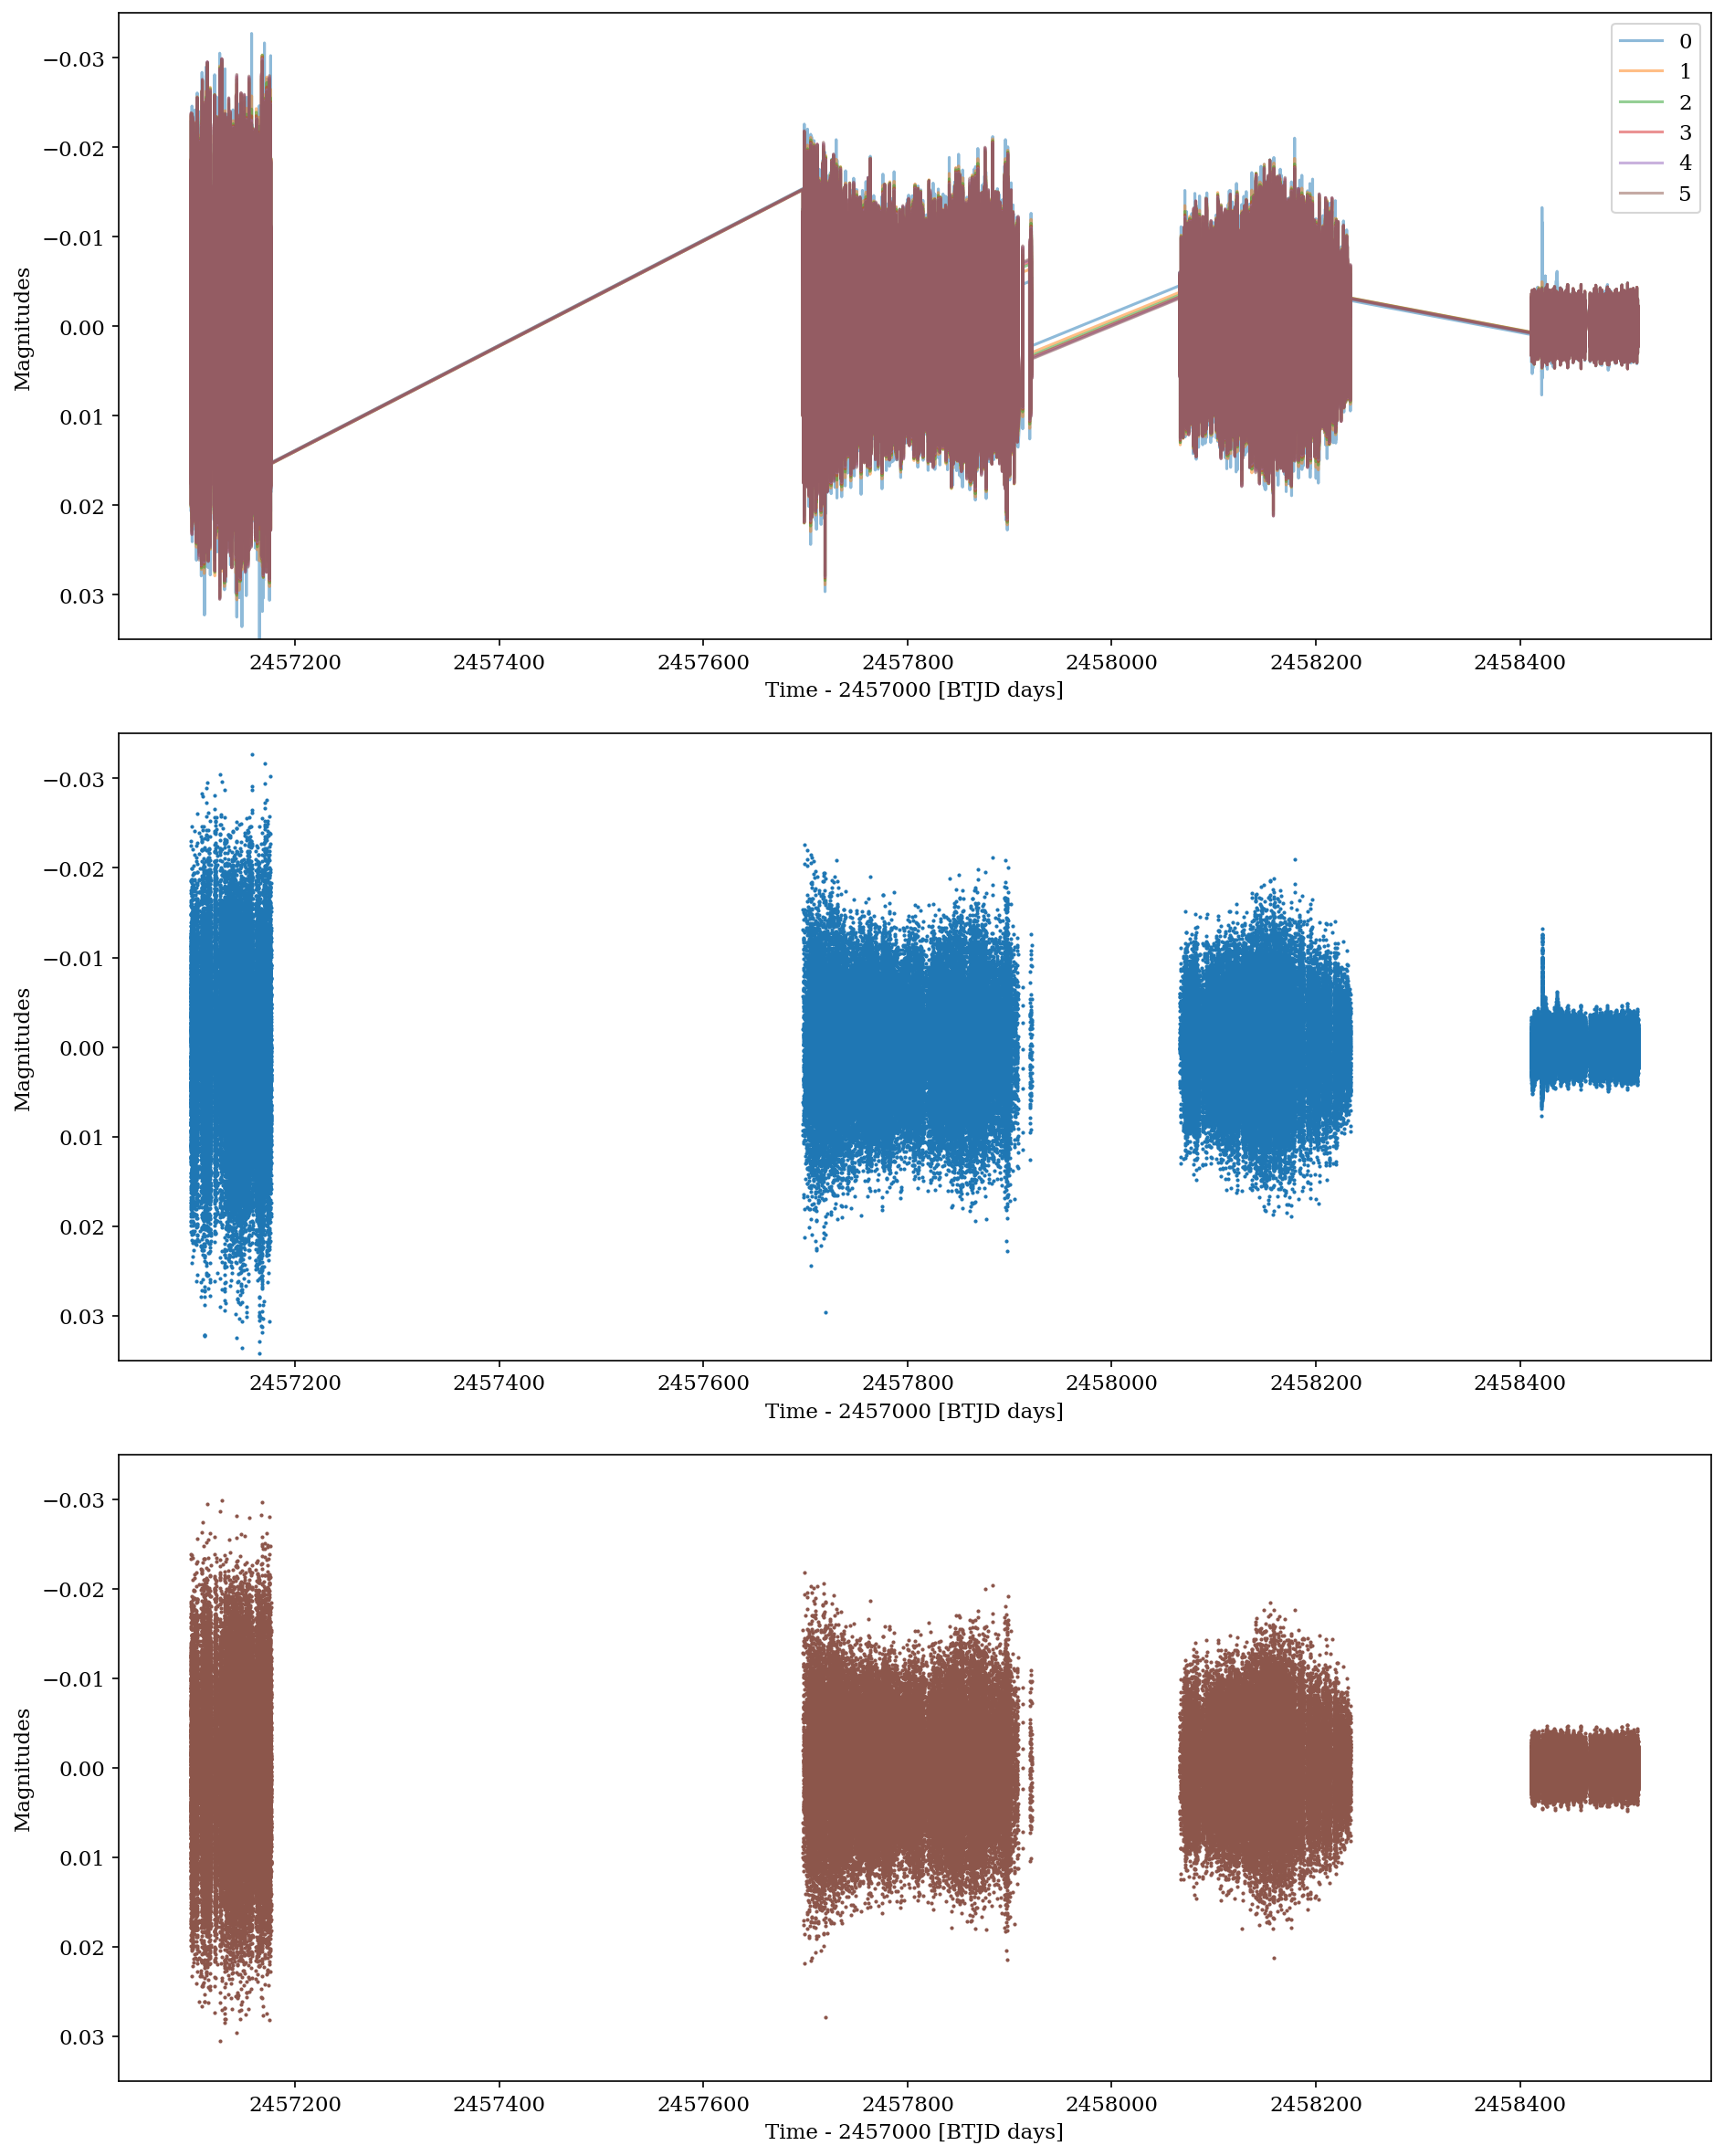

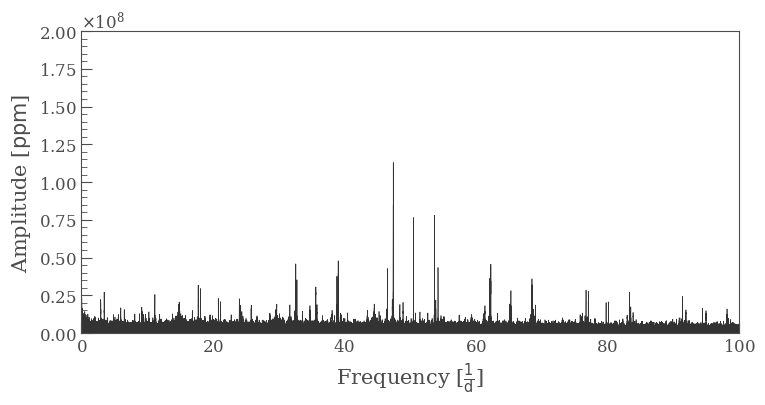

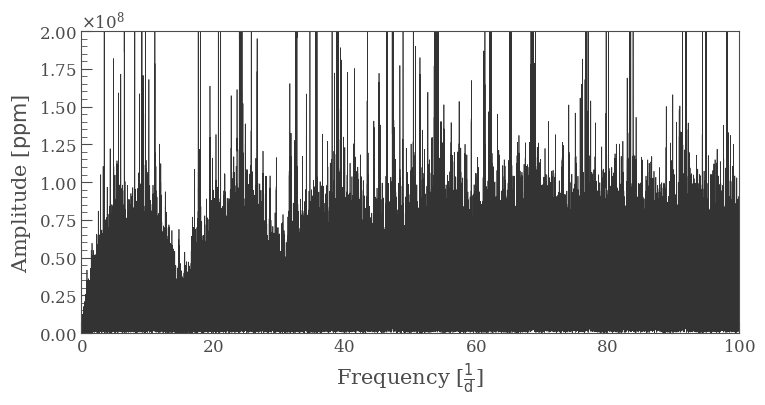

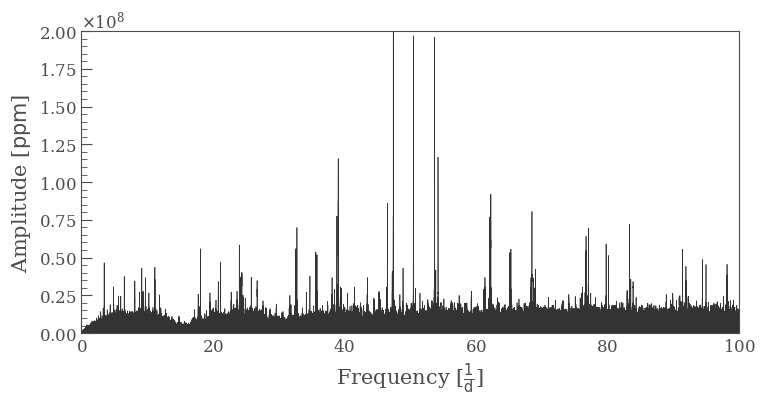

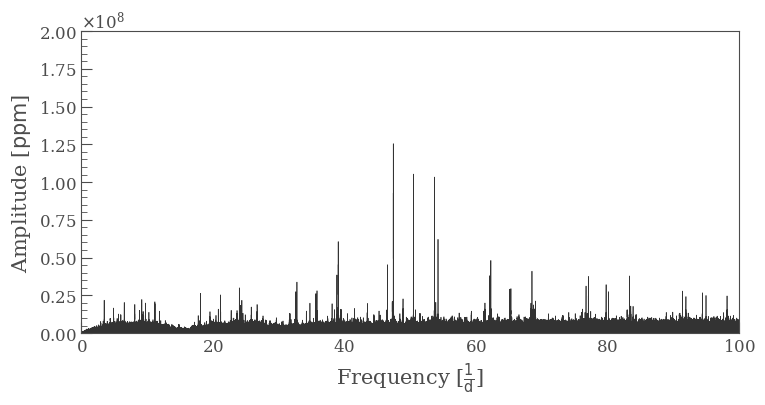

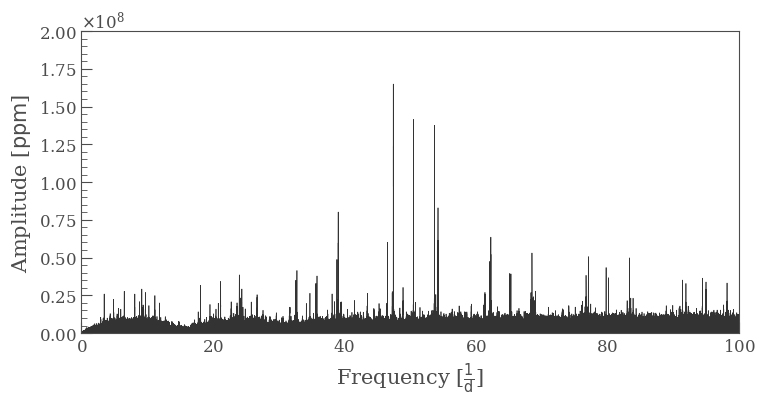

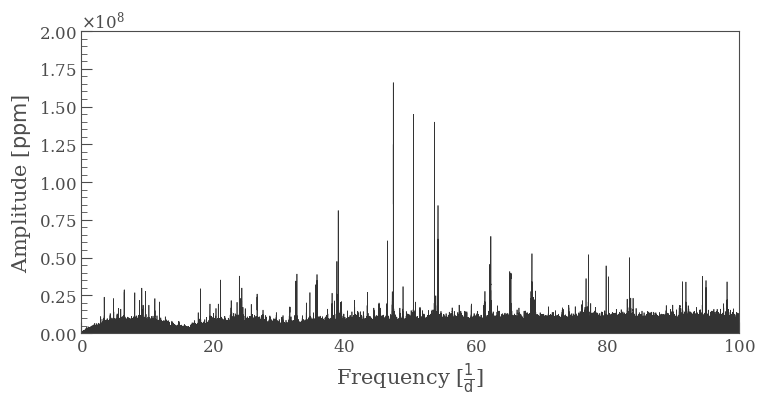

In [222]:
t = t_combBT
m = m_combBT


highpass_own = highpass(m, 5, 30)

fig, ax = plt.subplots(3, 1, figsize=(15, 20))


hpmax = len(highpass_own)-1

for i in range(0, len(highpass_own)):
    ax[0].plot(t, highpass_own[i], label='{0}'.format(i), alpha=0.5)

ax[1].scatter(t, highpass_own[0], s=1, label='{0}'.format(i), alpha=1, c='C0')
ax[2].scatter(t, highpass_own[hpmax], s=1, label='{0}'.format(i), alpha=1, c='C5')

for i in range(0,3):
    #ax[i].set_xlim(-0.015, 0.015)
    ax[i].set_ylim(-0.035, 0.035)
    ax[i].set_ylabel('Magnitudes')
    ax[i].set_xlabel('Time - 2457000 [BTJD days]')
    ax[i].invert_yaxis()

ax[0].legend()

plt.subplots_adjust(hspace=0.15)


lc_own_0 = lk.LightCurve(t, highpass_own[0])
lc_own_1 = lk.LightCurve(t, highpass_own[1])
lc_own_2 = lk.LightCurve(t, highpass_own[2])
lc_own_3 = lk.LightCurve(t, highpass_own[3])
lc_own_4 = lk.LightCurve(t, highpass_own[4])
lc_own_max = lk.LightCurve(t, highpass_own[hpmax])

lc_own_lst = [lc_own_0,lc_own_1,lc_own_2,lc_own_3,lc_own_4, lc_own_max]

for i in range(0, 6):
    lc_own_lst[i].to_periodogram(method='LombScargle', minimum_frequency=0, maximum_frequency=100, oversample_factor=10).plot()
    plt.ylim(0,2e8)
    plt.xlim(0,100)
    
t_combBT_hp = t
m_combBT_hp = highpass_own[hpmax]

In [223]:
## TESS + bRing

/home/sebastian/anaconda3/lib/python3.7/site-packages/lightkurve/periodogram.py:744: LightkurveWarning: Input light curve will be normalized.
  LightkurveWarning)
/home/sebastian/anaconda3/lib/python3.7/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:93: RuntimeWarning: invalid value encountered in true_divide
  tan_2omega_tau = (S2 - 2 * S * C) / (C2 - (C * C - S * S))
/home/sebastian/anaconda3/lib/python3.7/site-packages/lightkurve/periodogram.py:744: LightkurveWarning: Input light curve will be normalized.
  LightkurveWarning)
/home/sebastian/anaconda3/lib/python3.7/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:93: RuntimeWarning: invalid value encountered in true_divide
  tan_2omega_tau = (S2 - 2 * S * C) / (C2 - (C * C - S * S))
/home/sebastian/anaconda3/lib/python3.7/site-packages/lightkurve/periodogram.py:744: LightkurveWarning: Input light curve will be normalized.
  LightkurveWarning)
/home/sebasti

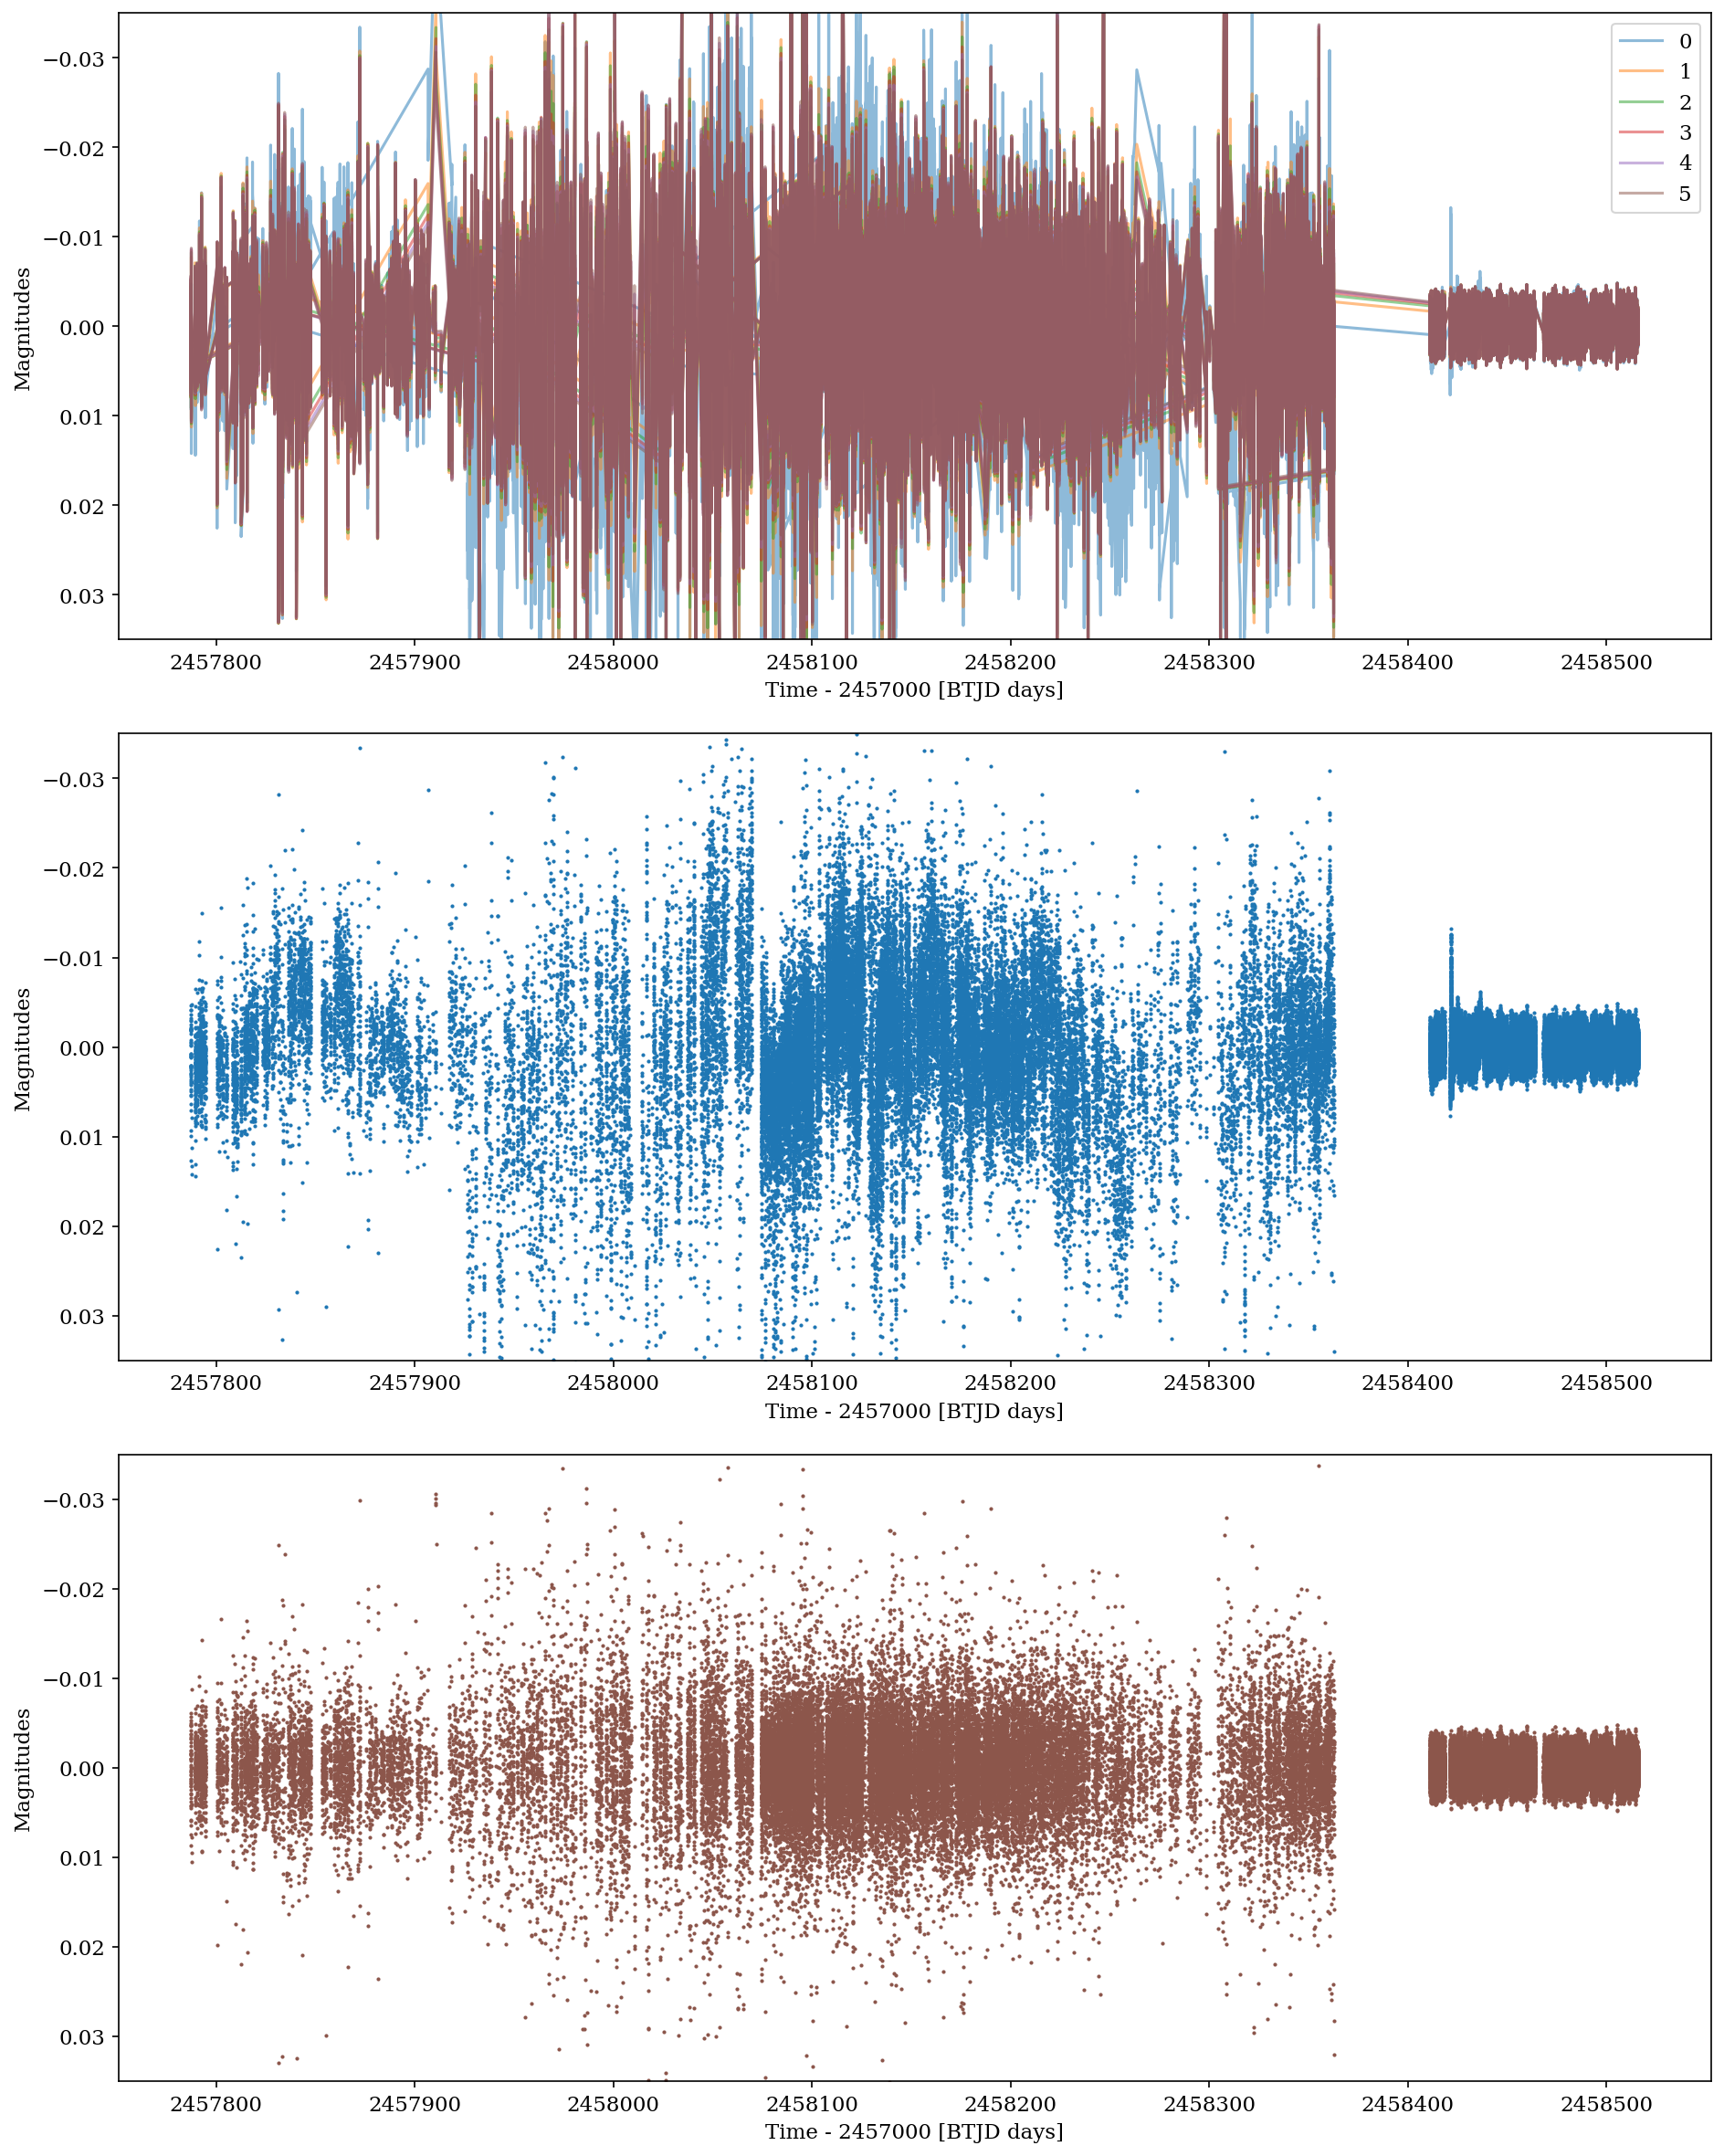

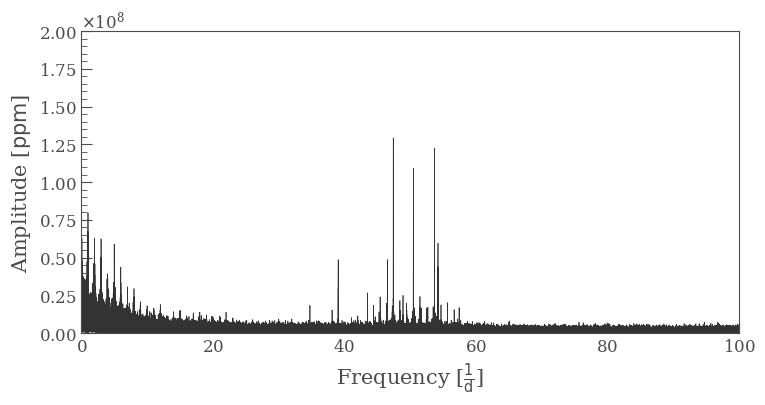

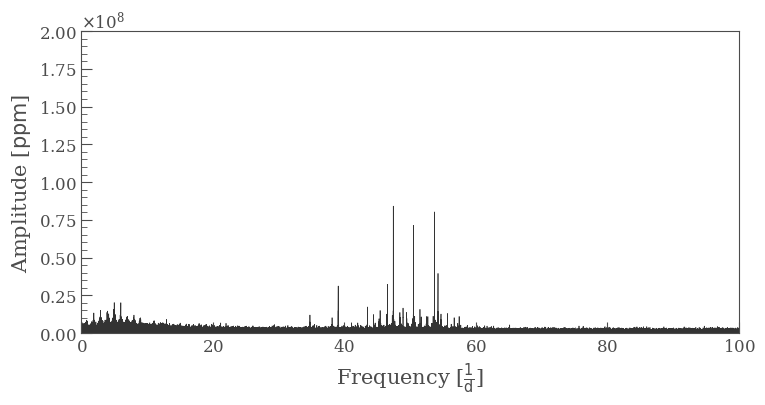

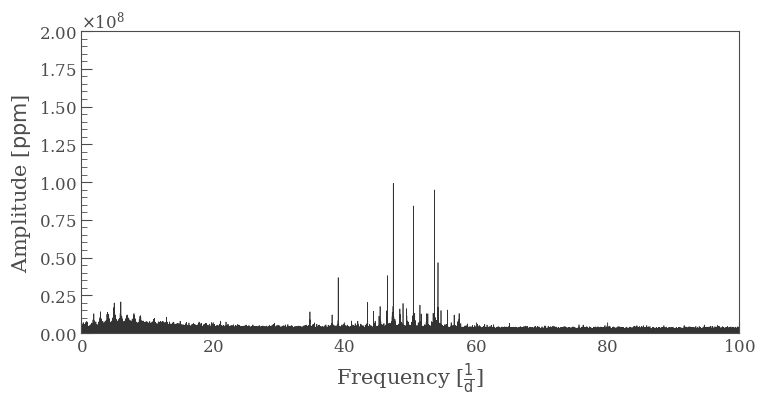

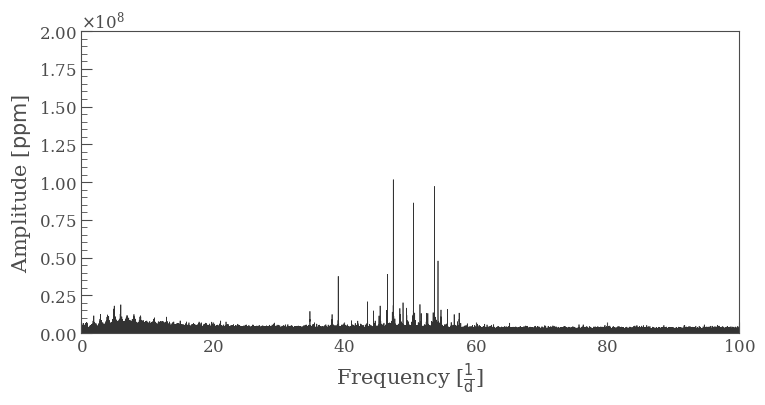

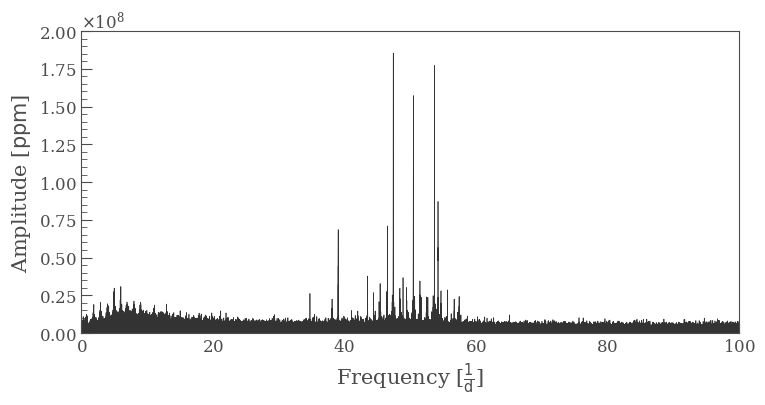

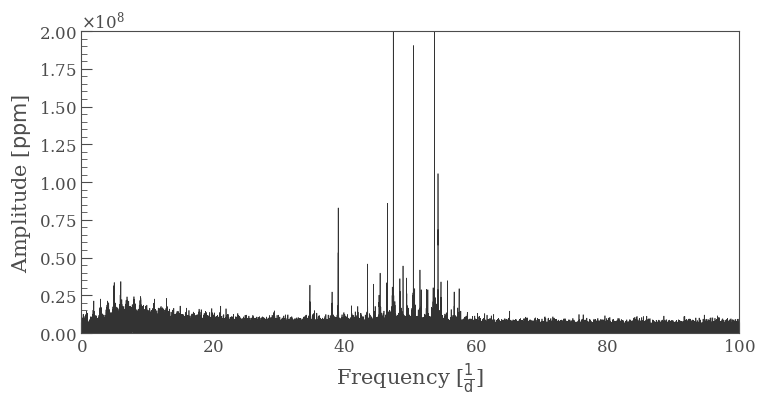

In [224]:
t = t_combRT
m = m_combRT


highpass_own = highpass(m, 5, 15)

fig, ax = plt.subplots(3, 1, figsize=(15, 20))


hpmax = len(highpass_own)-1

for i in range(0, len(highpass_own)):
    ax[0].plot(t, highpass_own[i], label='{0}'.format(i), alpha=0.5)

ax[1].scatter(t, highpass_own[0], s=1, label='{0}'.format(i), alpha=1, c='C0')
ax[2].scatter(t, highpass_own[hpmax], s=1, label='{0}'.format(i), alpha=1, c='C5')

for i in range(0,3):
    #ax[i].set_xlim(-0.015, 0.015)
    ax[i].set_ylim(-0.035, 0.035)
    ax[i].set_ylabel('Magnitudes')
    ax[i].set_xlabel('Time - 2457000 [BTJD days]')
    ax[i].invert_yaxis()

ax[0].legend()

plt.subplots_adjust(hspace=0.15)


lc_own_0 = lk.LightCurve(t, highpass_own[0])
lc_own_1 = lk.LightCurve(t, highpass_own[1])
lc_own_2 = lk.LightCurve(t, highpass_own[2])
lc_own_3 = lk.LightCurve(t, highpass_own[3])
lc_own_4 = lk.LightCurve(t, highpass_own[4])
lc_own_max = lk.LightCurve(t, highpass_own[hpmax])

lc_own_lst = [lc_own_0,lc_own_1,lc_own_2,lc_own_3,lc_own_4, lc_own_max]

for i in range(0, 6):
    lc_own_lst[i].to_periodogram(method='LombScargle', minimum_frequency=0, maximum_frequency=100, oversample_factor=10).plot()
    plt.ylim(0,2e8)
    plt.xlim(0,100)
    
t_combRT_hp = t
m_combRT_hp = highpass_own[hpmax]

In [225]:
## TESS + ASTEP

/home/sebastian/anaconda3/lib/python3.7/site-packages/lightkurve/periodogram.py:744: LightkurveWarning: Input light curve will be normalized.
  LightkurveWarning)
/home/sebastian/anaconda3/lib/python3.7/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:93: RuntimeWarning: invalid value encountered in true_divide
  tan_2omega_tau = (S2 - 2 * S * C) / (C2 - (C * C - S * S))
/home/sebastian/anaconda3/lib/python3.7/site-packages/lightkurve/periodogram.py:744: LightkurveWarning: Input light curve will be normalized.
  LightkurveWarning)
/home/sebastian/anaconda3/lib/python3.7/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:93: RuntimeWarning: invalid value encountered in true_divide
  tan_2omega_tau = (S2 - 2 * S * C) / (C2 - (C * C - S * S))
/home/sebastian/anaconda3/lib/python3.7/site-packages/lightkurve/periodogram.py:744: LightkurveWarning: Input light curve will be normalized.
  LightkurveWarning)
/home/sebasti

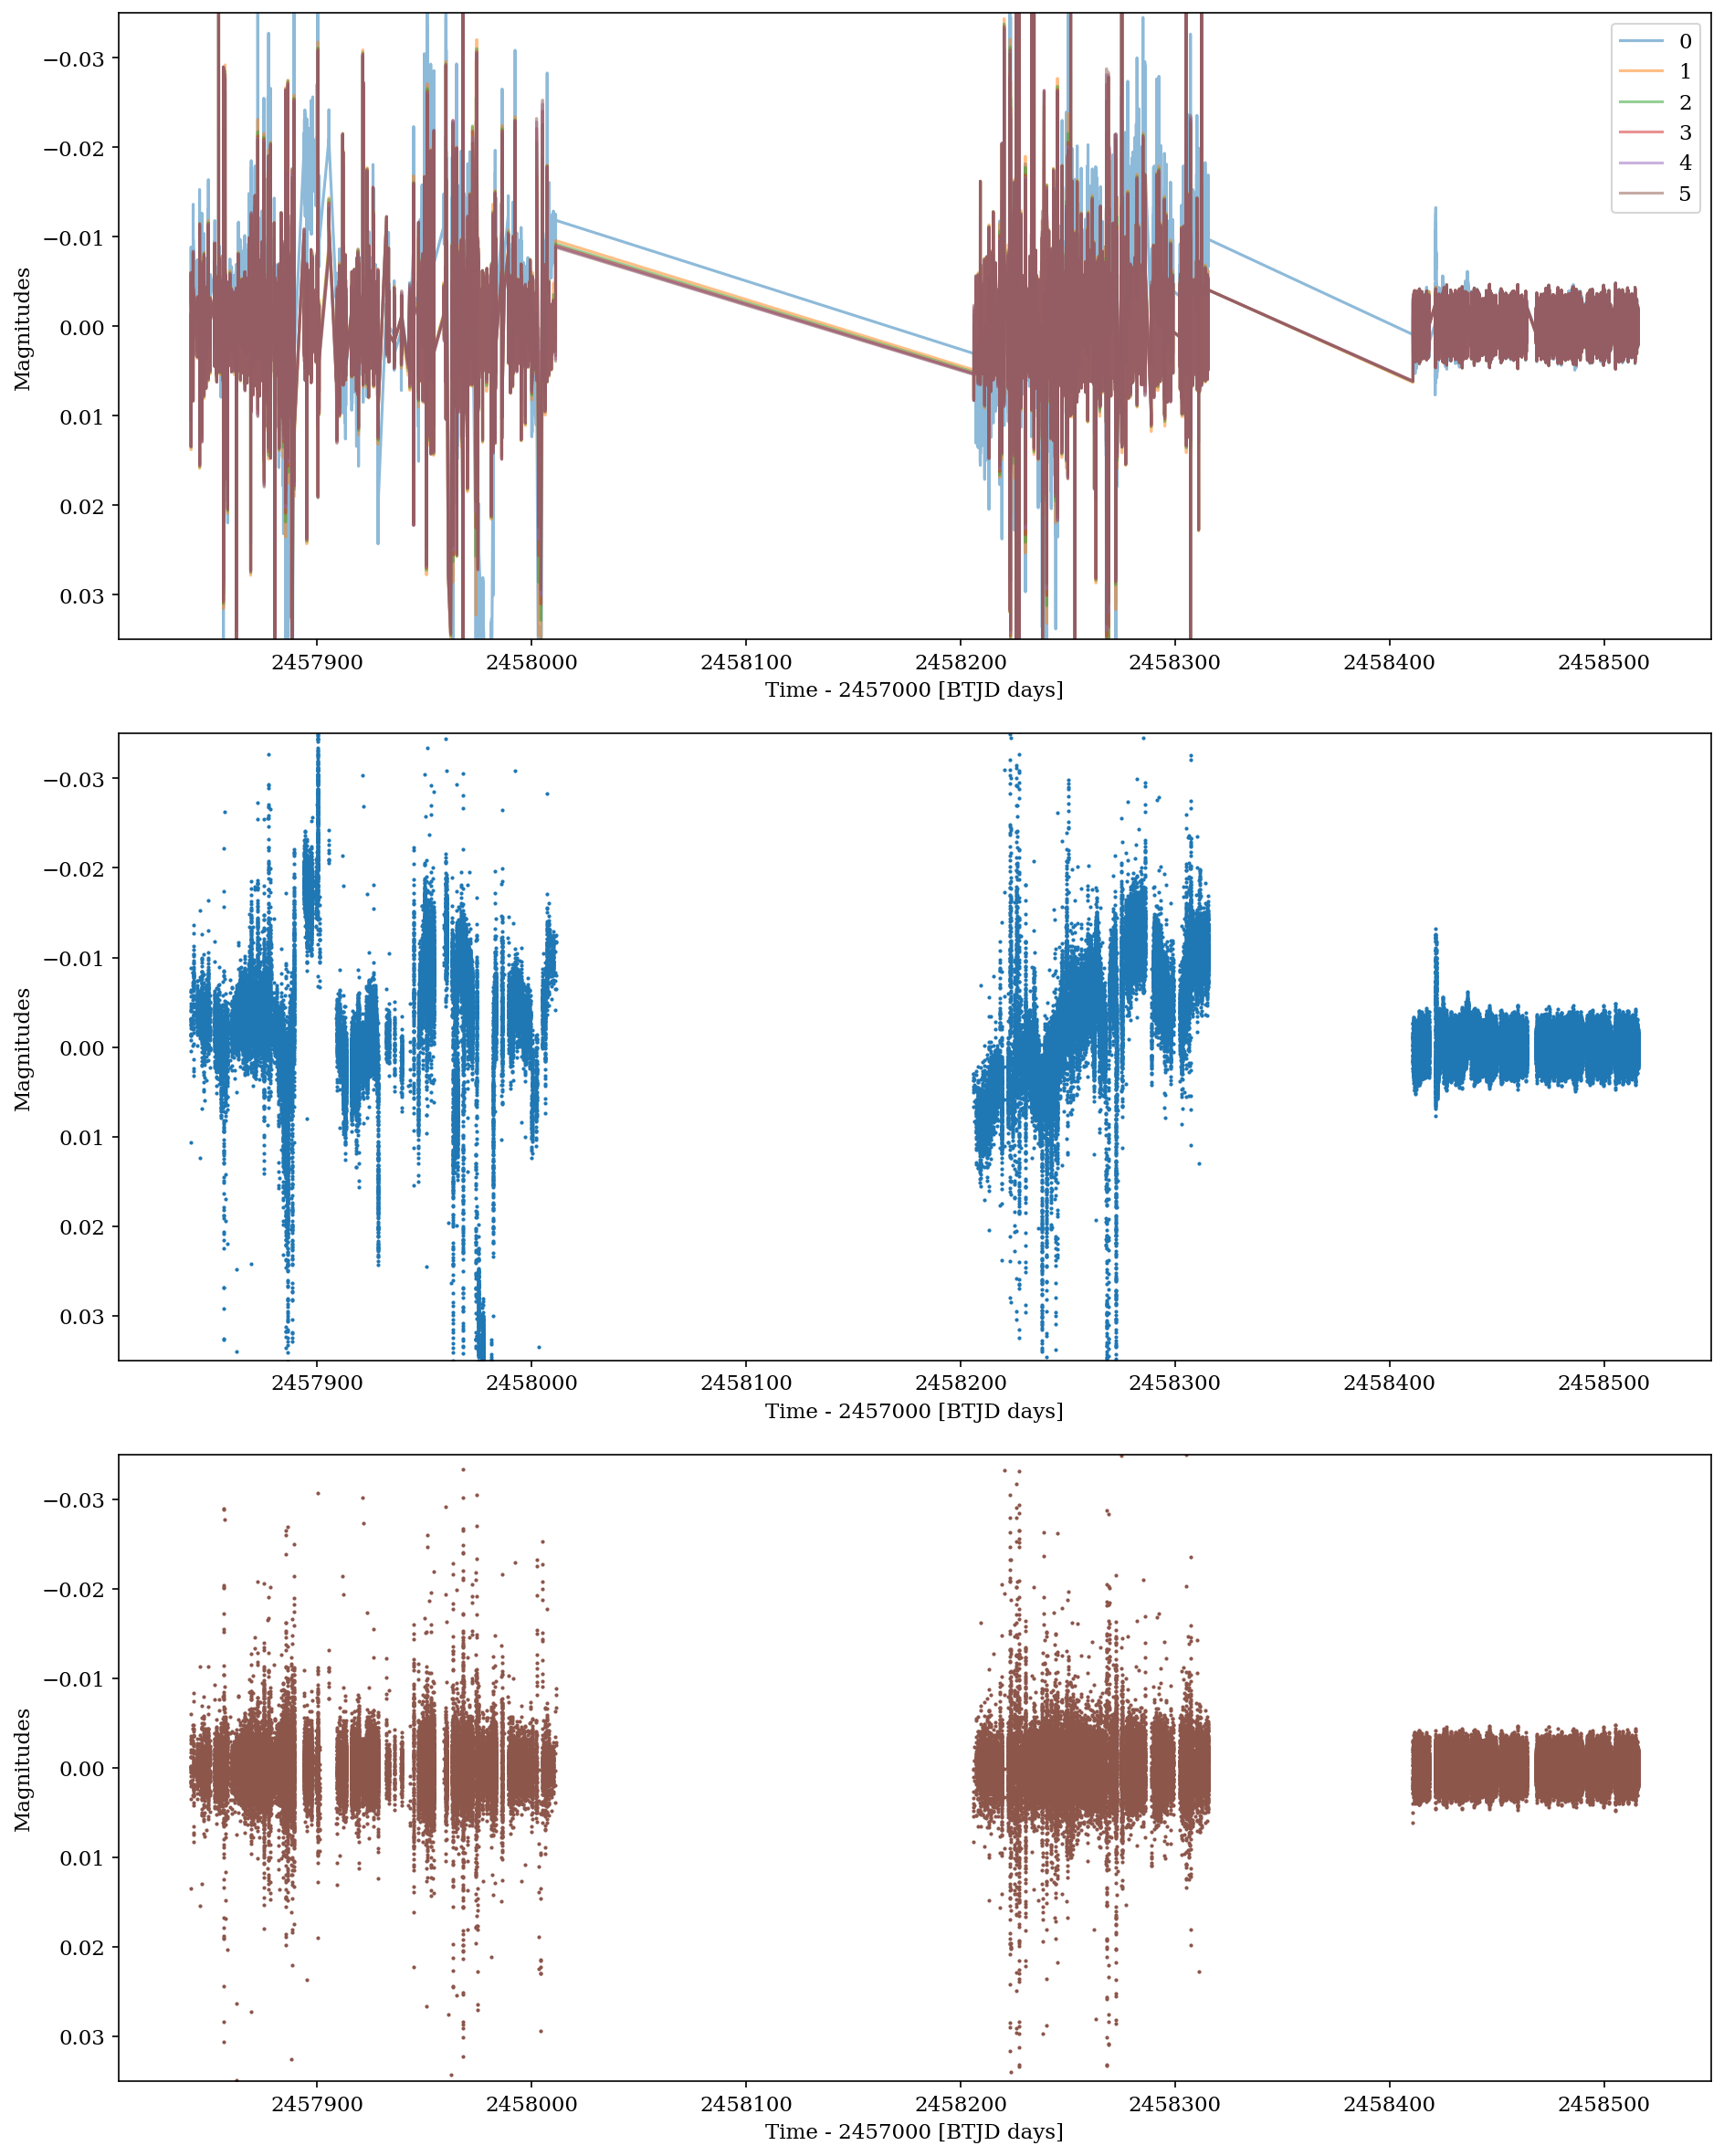

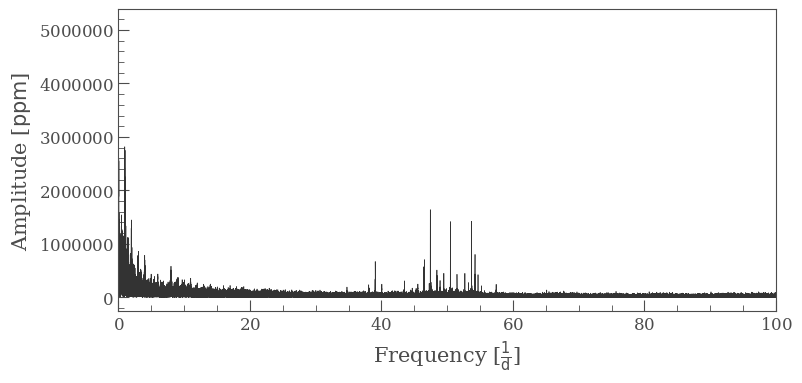

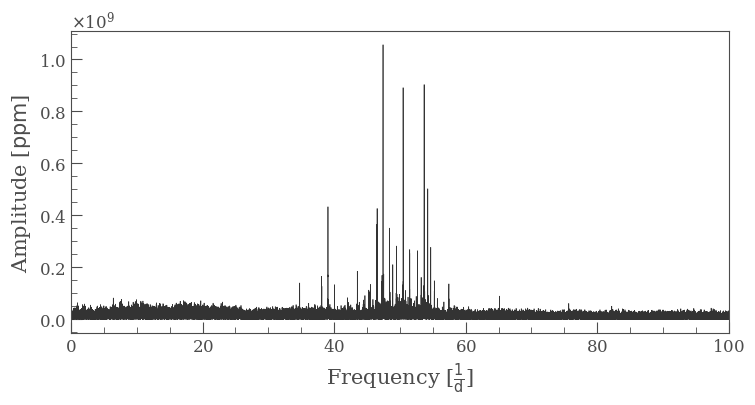

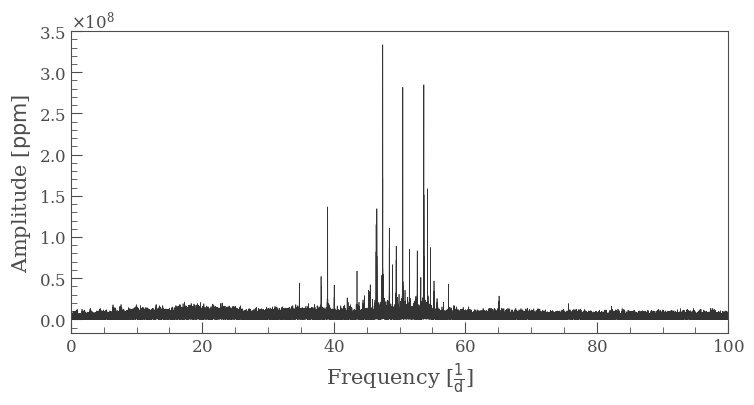

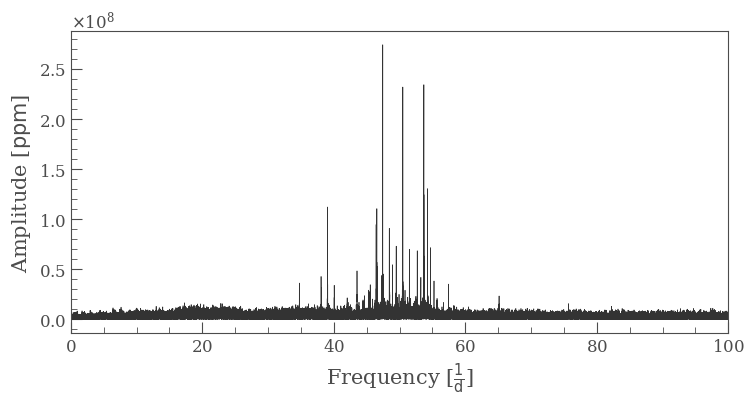

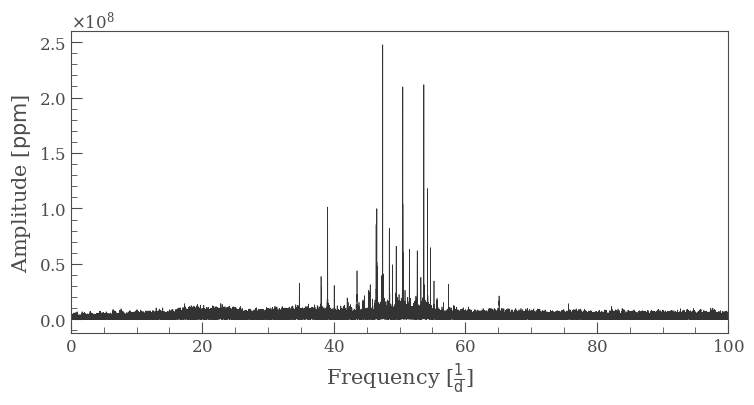

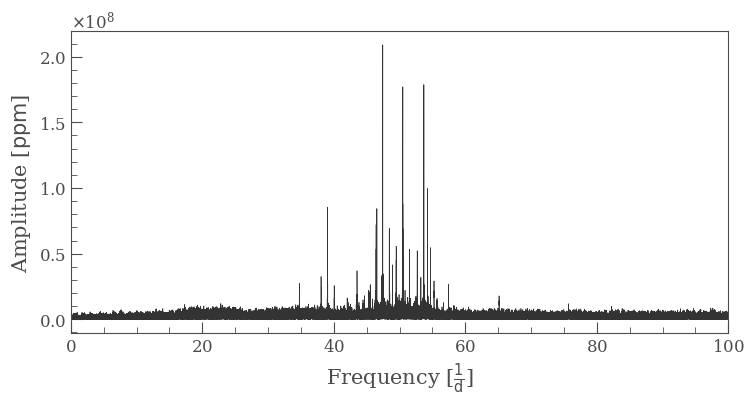

In [226]:
t = t_combAT
m = m_combAT


highpass_own = highpass(m, 5, 15)

fig, ax = plt.subplots(3, 1, figsize=(15, 20))


hpmax = len(highpass_own)-1

for i in range(0, len(highpass_own)):
    ax[0].plot(t, highpass_own[i], label='{0}'.format(i), alpha=0.5)

ax[1].scatter(t, highpass_own[0], s=1, label='{0}'.format(i), alpha=1, c='C0')
ax[2].scatter(t, highpass_own[hpmax], s=1, label='{0}'.format(i), alpha=1, c='C5')

for i in range(0,3):
    #ax[i].set_xlim(-0.015, 0.015)
    ax[i].set_ylim(-0.035, 0.035)
    ax[i].set_ylabel('Magnitudes')
    ax[i].set_xlabel('Time - 2457000 [BTJD days]')
    ax[i].invert_yaxis()

ax[0].legend()

plt.subplots_adjust(hspace=0.15)


lc_own_0 = lk.LightCurve(t, highpass_own[0])
lc_own_1 = lk.LightCurve(t, highpass_own[1])
lc_own_2 = lk.LightCurve(t, highpass_own[2])
lc_own_3 = lk.LightCurve(t, highpass_own[3])
lc_own_4 = lk.LightCurve(t, highpass_own[4])
lc_own_max = lk.LightCurve(t, highpass_own[hpmax])

lc_own_lst = [lc_own_0,lc_own_1,lc_own_2,lc_own_3,lc_own_4, lc_own_max]

for i in range(0, 6):
    lc_own_lst[i].to_periodogram(method='LombScargle', minimum_frequency=0, maximum_frequency=100, oversample_factor=10).plot()
    #plt.ylim(0,2e8)
    plt.xlim(0,100)
    
t_combAT_hp = t
m_combAT_hp = highpass_own[hpmax]

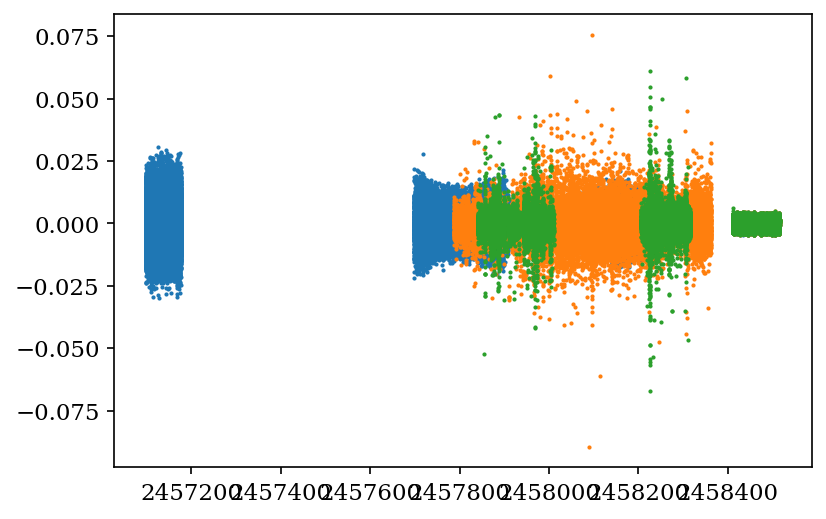

In [227]:
plt.scatter(t_combBT_hp, m_combBT_hp, s=1)
plt.scatter(t_combRT_hp, m_combRT_hp, s=1)
plt.scatter(t_combAT_hp, m_combAT_hp, s=1)

# Subtraction of Freqs

# TD

In [228]:
f_gold = [47.43903298, 53.69160236, 50.49211222]
f_gold3 = [47.43903298, 53.69160236, 50.49211222, 54.23794952, 39.06318864, 46.5428208]
a_gold = [0.00125113, 0.00085937, 0.00084356]
a_gold3 = [1.04274414e-03, 9.69447102e-04, 9.31640582e-04, 5.63751542e-04,
 4.39355917e-04, 4.10780750e-04]

In [229]:
def phases_simon(times, magnitudes, f_fix, a_guess, p_guess):
    
    freqs = []
    amps = []
    phases = []
    phases_err = []
    
    for i in range(len(f_fix)):

        model1 = Model(sin)
        #model1.set_param_hint('amp', value=a_guess[i], vary=False)
        model1.set_param_hint('amp', value=a_guess[i], min=0.1 * a_guess[i], max=1.9 * a_guess[i])
        model1.set_param_hint('f', value=f_fix[i], vary=False)
        model1.set_param_hint('phase', value=p_guess[i], min=0, max=1)
        result1 = model1.fit(magnitudes, x=times, method='least_squares')

        # after first fit, vary only phase
        model2 = Model(sin)
        model2.set_param_hint('amp', value=result1.values['amp'], vary=False)
        model2.set_param_hint('f', value=f_fix[i], vary=False)
        model2.set_param_hint('phase', value=result1.values['phase'], min=0, max=1)
        result2 = model2.fit(magnitudes, x=times, method='least_squares')

        freqs.append(result2.values['f'])
        amps.append(result2.values['amp'])
        phases.append(result2.values['phase'])
        phases_err.append(np.sqrt(np.diag(result2.covar)[0]))
        
    freqs = np.array(freqs)
    amps = np.array(amps)
    phases = np.array(phases)
    phases_err = np.array(phases_err)
        
    return(freqs, amps, phases, phases_err)

In [230]:
# def phases_simon(times, magnitudes, f_fix, a_guess, p_guess):
    
#     freqs = []
#     amps = []
#     phases = []
#     phases_err = []
    
#     for i in range(len(f_fix)):

#         model1 = Model(sin)
#         #model1.set_param_hint('amp', value=a_guess[i], vary=False)
#         model1.set_param_hint('amp', value=a_guess[i], min=0.1 * a_guess[i], max=1.9 * a_guess[i])
#         model1.set_param_hint('f', value=f_fix[i], min=0.9 * f_fix[i], max=1.1 * f_fix[i])
#         model1.set_param_hint('phase', value=p_guess[i], min=0, max=1)
#         result1 = model1.fit(magnitudes, x=times, method='least_squares')

#         # after first fit, vary only phase
#         model2 = Model(sin)
#         model2.set_param_hint('amp', value=result1.values['amp'], vary=False)
#         model2.set_param_hint('f', value=result1.values['f'], vary=False)
#         model2.set_param_hint('phase', value=result1.values['phase'], min=0, max=1)
#         result2 = model2.fit(magnitudes, x=times, method='least_squares')

#         freqs.append(result2.values['f'])
#         amps.append(result2.values['amp'])
#         phases.append(result2.values['phase'])
#         phases_err.append(np.sqrt(np.diag(result2.covar)[0]))
        
#     freqs = np.array(freqs)
#     amps = np.array(amps)
#     phases = np.array(phases)
#     phases_err = np.array(phases_err)
        
#     return(freqs, amps, phases, phases_err)

# BRITE + TESS

In [231]:
segment_size = [len(tB15_BJD), len(tB16_BJD), len(tB17_BJD), len(t_TESS)]
segment_borders = [0, segment_size[0], segment_size[0]+segment_size[1], 
                   segment_size[0]+segment_size[1]+segment_size[2],
                   segment_size[0]+segment_size[1]+segment_size[2]+segment_size[3]]

0
1
2
3


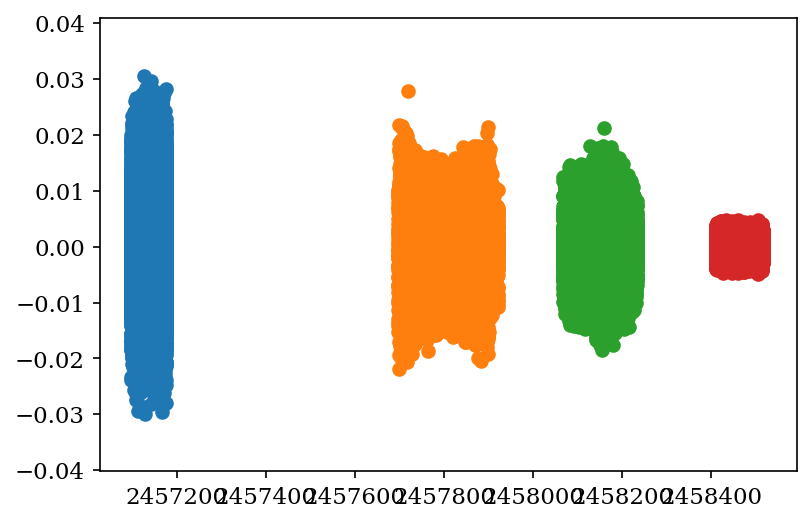

In [232]:
iterr = 0
for i in range(0,4):
    print(iterr)
    plt.scatter(t_combBT_hp[segment_borders[i]:segment_borders[i+1]], m_combBT_hp[segment_borders[i]:segment_borders[i+1]])
    iterr += 1

0
44235
Calc LS fit
(array([47.43903298, 53.69160236, 50.49211222, 54.23794952, 39.06318864,
       46.5428208 ]), array([3.33698854e-04, 2.22688057e-04, 9.32450383e-05, 1.00377276e-04,
       8.64519795e-05, 1.64007664e-04]), array([0.70301007, 0.75024701, 0.561108  , 0.49824615, 0.4630338 ,
       0.26460037]), array([0.02279789, 0.03413882, 0.08146697, 0.07587549, 0.08839648,
       0.04658426]))
1
111813
Calc LS fit
(array([47.43903298, 53.69160236, 50.49211222, 54.23794952, 39.06318864,
       46.5428208 ]), array([0.00072096, 0.00029968, 0.00071322, 0.00034078, 0.00040622,
       0.00017553]), array([0.77402936, 0.46257233, 0.33783358, 0.1768672 , 0.27972654,
       0.34641194]), array([0.00558783, 0.013453  , 0.00565439, 0.01185176, 0.00993224,
       0.02298798]))
2
165075
Calc LS fit
(array([47.43903298, 53.69160236, 50.49211222, 54.23794952, 39.06318864,
       46.5428208 ]), array([0.00063237, 0.00090519, 0.00057643, 0.00034673, 0.00038117,
       0.0002757 ]), array([0.7818

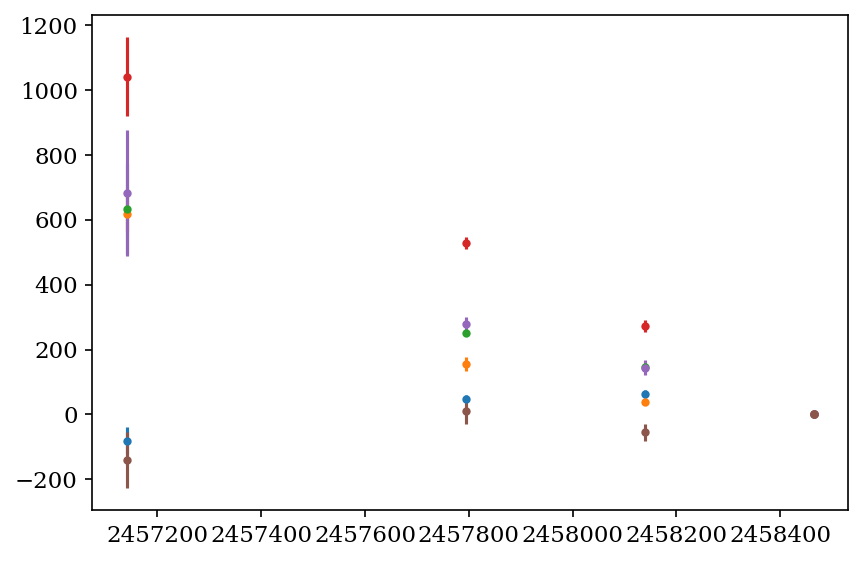

In [233]:
segment_size = [len(tB15_BJD), len(tB16_BJD), len(tB17_BJD), len(t_TESS)]
segment_borders = [0, segment_size[0], segment_size[0]+segment_size[1], 
                   segment_size[0]+segment_size[1]+segment_size[2],
                   segment_size[0]+segment_size[1]+segment_size[2]+segment_size[3]]


times = t_combBT_hp
magnitudes = m_combBT_hp

time_slice, mag_slice, phase, phase_err = [], [], [], []
time_delays, time_delays_err, time_midpoints = [], [], []

iteration = 0

# Iterate over lightcurve
for t, y, idx in zip(times, magnitudes, range(len(times))):
    time_slice.append(t)
    mag_slice.append(y)

    # In each segment
    if idx == segment_borders[iteration+1]-1:
        print(iteration)
        print(idx)
        
#         fig, ax = plt.subplots(1, 1, figsize=(6.5, 3.5*2.5/2))
#         ax.scatter(time_slice, mag_slice)
        
        
#         print('Calc AS')
#         #AS################
#         freq, amp = AS(time_slice, mag_slice, 5)

#         fig, ax = plt.subplots(1, 1, figsize=(7, 4))

#         ax.plot(freq, amp)

#         freq=freq[5000:]
#         amp=amp[5000:]
#         ax.plot(freq, amp)

#         max_power = amp.max()

#         peaks, _ = find_peaks(amp, height=max_power*0.3, distance=300)
#         ax.plot(freq[peaks], amp[peaks], "x")


#         sort_idx = np.argsort(amp[peaks])[::-1]
#         f_TESS = freq[peaks][sort_idx]
#         a_TESS = amp[peaks][sort_idx]

#         print(f_TESS)
#         print(a_TESS)
#         print(len(f_TESS))
#         #####################
        
        # Append the time midpoint
        time_midpoints.append(np.mean(time_slice))

        # And the phases for each frequency
        
        print('Calc LS fit')
        sol = phases_simon(time_slice, mag_slice, f_gold3, a_gold3, [0.5]*6)
        
        print(sol)
        
        phase_i = sol[2]*2*np.pi
        phase.append(phase_i)
        phase_err_i = sol[3]*2*np.pi
        phase_err.append(phase_err_i)
        
        time_slice, mag_slice = [], []
        
        iteration += 1 

phase = np.array(phase).T
print(phase)
phase = np.unwrap(phase)
phase -= np.mean(phase)
print(phase)

phase_err = np.array(phase_err).T

print('Calc TD')
# Phase wrapping patch
for ph, ph_err, f in zip(phase, phase_err, f_gold3):
    td = ph / (2*np.pi*f)
    time_delays.append(td-np.mean(td))
    time_delays_err.append(ph_err / (2*np.pi*f))

print('Plot TD')
fig, ax = plt.subplots(1, 1, figsize=(6.5, 3.5*2.5/2))
for i in range(len(f_gold3)):
    #ax[0].scatter(time_midpoints, time_delays[i]*86400, s=5)
    ax.errorbar(time_midpoints, (time_delays[i]-time_delays[i][-1])*86400, yerr = time_delays_err[i]*86400, fmt='.')    
    #ax[0].set_ylim(-800, 800)
    #ax[1].set_ylim(-800, 800)
    
#plt.tight_layout()
#fig.savefig('f_TESS1.png', tight_layout=True)

t_td_BT = time_midpoints
tau_td_BT = []
for j in range(6):
    tau_td_BT.append(np.array([i*86400 for i in time_delays][j]-[i*86400 for i in time_delays][j][-1]))
tau_err_td_BT = time_delays_err

In [234]:
time_delays

[array([-1.02359076e-03,  4.73473719e-04,  6.39200290e-04, -8.90832546e-05]),
 array([ 0.00480036, -0.00055755, -0.00189135, -0.00235147]),
 array([ 4.35016025e-03, -7.18061608e-05, -1.29858888e-03, -2.97976521e-03]),
 array([ 0.00671983,  0.00079448, -0.00217733, -0.00533698]),
 array([ 4.70985271e-03,  1.72695634e-05, -1.53267872e-03, -3.19444356e-03]),
 array([-0.00108931,  0.00066846, -0.00011091,  0.00053176])]

In [235]:
tau_td_BT

[array([-80.74144804,  48.60492253,  62.92369829,   0.        ]),
 array([617.9180973 , 154.99482474,  39.75434109,   0.        ]),
 array([633.30555927, 251.24766161, 145.25363474,   0.        ]),
 array([1041.70810353,  529.7576739 ,  272.99324941,    0.        ]),
 array([682.93119757, 277.49201353, 143.57648191,   0.        ]),
 array([-140.06092098,   11.81039844,  -55.52658524,    0.        ])]

In [236]:
tau_td_BT = []
for j in range(6):
    tau_td_BT.append(np.array([i*86400 for i in time_delays][j]-[i*86400 for i in time_delays][j][-1]))

In [237]:
tau_td_BT

[array([-80.74144804,  48.60492253,  62.92369829,   0.        ]),
 array([617.9180973 , 154.99482474,  39.75434109,   0.        ]),
 array([633.30555927, 251.24766161, 145.25363474,   0.        ]),
 array([1041.70810353,  529.7576739 ,  272.99324941,    0.        ]),
 array([682.93119757, 277.49201353, 143.57648191,   0.        ]),
 array([-140.06092098,   11.81039844,  -55.52658524,    0.        ])]

In [238]:
[i*86400 for i in tau_td_BT[0]]

[-6976061.110752799, 4199465.306760853, 5436607.532644817, 0.0]

In [239]:
tau_td_BT[0][0]

-80.74144804112035

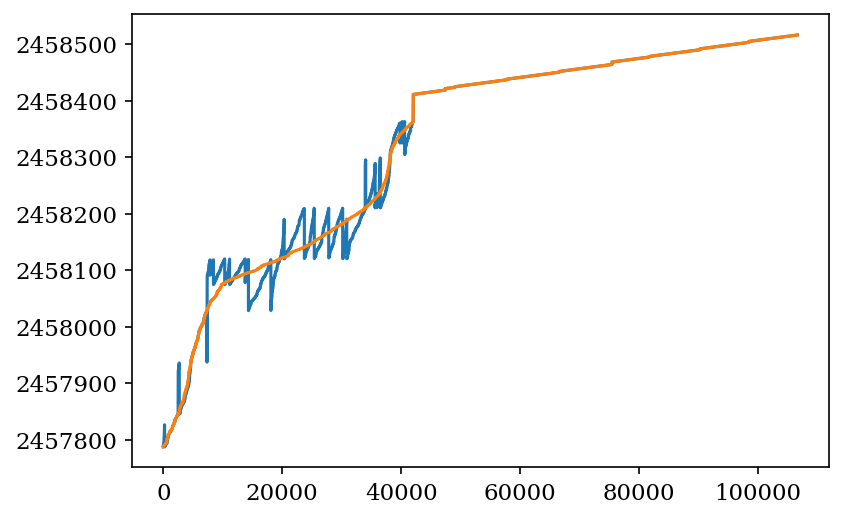

In [240]:
plt.plot(range(len(t_combRT)), t_combRT)

sort_idx = np.argsort(t_combRT)

plt.plot(range(len(t_combRT)), t_combRT[sort_idx])

In [241]:
np.argsort(np.diff(t_combRT[sort_idx]))[::-1]

array([42020,   564,  2670, ..., 20967, 15917, 25283])

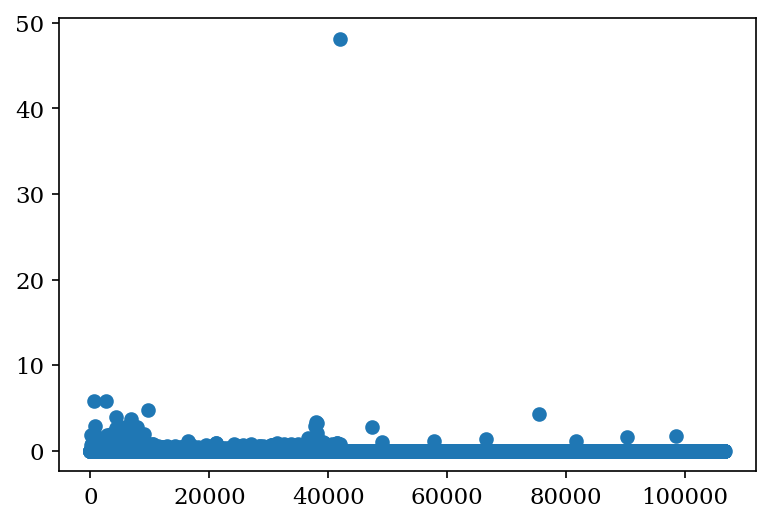

In [242]:
plt.scatter(range(len(t_combRT)-1), np.diff(t_combRT[sort_idx]))

0


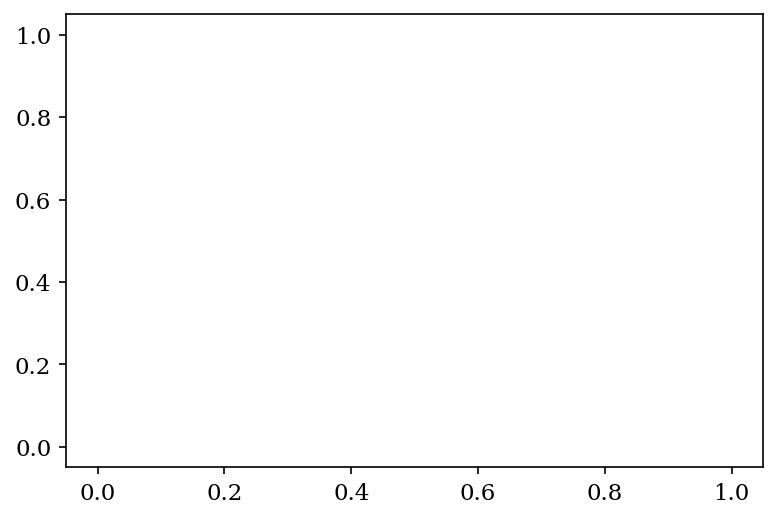

In [243]:
iterr = 0
sort_idx = np.argsort(t_combRT)
for i in range(2,3):
    print(iterr)
    plt.scatter(t_combRT_hp[sort_idx][segment_borders[i]:segment_borders[i+1]], m_combRT_hp[sort_idx][segment_borders[i]:segment_borders[i+1]], s=1)
    iterr += 1

0
21009
Calc LS fit
(array([47.43903298, 53.69160236, 50.49211222, 54.23794952, 39.06318864,
       46.5428208 ]), array([0.00121463, 0.00108937, 0.0009672 , 0.00040287, 0.00039771,
       0.00046672]), array([0.81728621, 0.46174941, 0.32896134, 0.10596384, 0.30189191,
       0.33698657]), array([0.00686577, 0.00768823, 0.00863941, 0.02093992, 0.02118229,
       0.01816219]))
1
42020
Calc LS fit
(array([47.43903298, 53.69160236, 50.49211222, 54.23794952, 39.06318864,
       46.5428208 ]), array([0.00138603, 0.00145664, 0.0010868 , 0.0005677 , 0.00040321,
       0.00051933]), array([0.80093635, 0.4289499 , 0.2749206 , 0.03429799, 0.18408544,
       0.41313113]), array([0.0054909 , 0.00520474, 0.00706281, 0.01360267, 0.01922381,
       0.01488698]))
2
106629
Calc LS fit
(array([47.43903298, 53.69160236, 50.49211222, 54.23794952, 39.06318864,
       46.5428208 ]), array([0.00104177, 0.00096729, 0.00093033, 0.00056278, 0.00043852,
       0.00041061]), array([0.74730373, 0.36614291, 0.19056

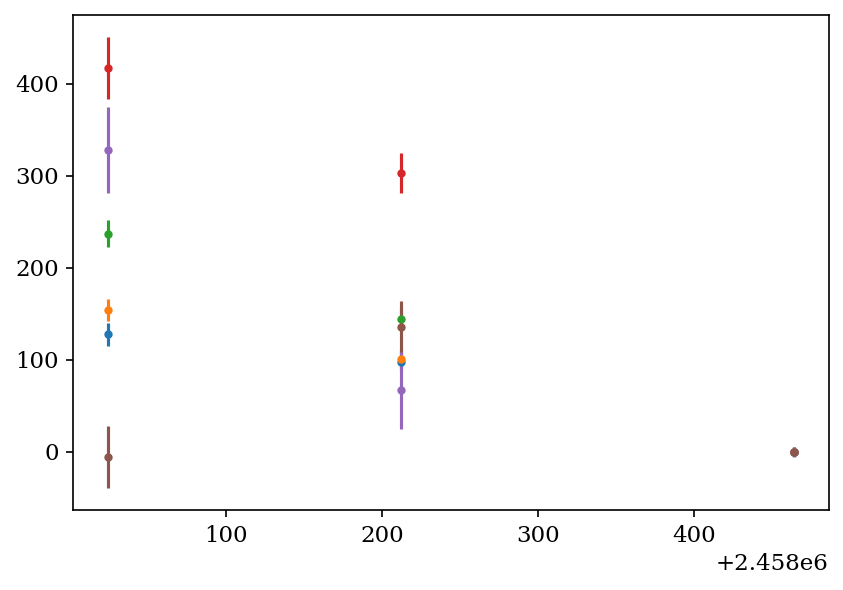

In [244]:
segment_size = [int(42021/2), 42021, len(t_combRT_hp)]
segment_borders = [0, segment_size[0], segment_size[1], segment_size[2]]

sort_idx = np.argsort(t_combRT)
times = t_combRT_hp[sort_idx]
magnitudes = m_combRT_hp[sort_idx]

time_slice, mag_slice, phase, phase_err = [], [], [], []
time_delays, time_delays_err, time_midpoints = [], [], []

iteration = 0

# Iterate over lightcurve
for t, y, idx in zip(times, magnitudes, range(len(times))):
    time_slice.append(t)
    mag_slice.append(y)

    # In each segment
    if idx == segment_borders[iteration+1]-1:
        print(iteration)
        print(idx)
        #print(time_slice)
        
#         fig1, ax1 = plt.subplots(1, 1, figsize=(6.5, 3.5*2.5/2))
#         ax1.scatter(time_slice, mag_slice)
#         ax1.axvline(min(time_slice))
#         ax1.axvline(max(time_slice))
        
#         print('Calc AS')
#         #AS################
#         freq, amp = AS(time_slice, mag_slice, 5)

#         fig, ax = plt.subplots(1, 1, figsize=(7, 4))
#         ax.plot(freq, amp)

#         freq=freq[5000:]
#         amp=amp[5000:]
#         ax.plot(freq, amp)

#         max_power = amp.max()

#         peaks, _ = find_peaks(amp, height=max_power*0.3, distance=300)
#         ax.plot(freq[peaks], amp[peaks], "x")


#         sort_idx = np.argsort(amp[peaks])[::-1]
#         f_TESS = freq[peaks][sort_idx]
#         a_TESS = amp[peaks][sort_idx]

#         print(f_TESS)
#         print(a_TESS)
#         print(len(f_TESS))
#         #####################
        
        # Append the time midpoint
        time_midpoints.append(np.mean(time_slice))

        # And the phases for each frequency
        
        print('Calc LS fit')
        sol = phases_simon(time_slice, mag_slice, f_gold3, a_gold3, [0.5]*6)
        
        print(sol)
        
        phase_i = sol[2]*2*np.pi
        phase.append(phase_i)
        phase_err_i = sol[3]*2*np.pi
        phase_err.append(phase_err_i)
        
        time_slice, mag_slice = [], []
        
        iteration += 1 

phase = np.array(phase).T
print(phase)
phase = np.unwrap(phase)
phase -= np.mean(phase)
print(phase)

phase_err = np.array(phase_err).T

print('Calc TD')
# Phase wrapping patch
for ph, ph_err, f in zip(phase, phase_err, f_gold3):
    td = ph / (2*np.pi*f)
    time_delays.append(td-np.mean(td))
    time_delays_err.append(ph_err / (2*np.pi*f))

print('Plot TD')
fig, ax = plt.subplots(1, 1, figsize=(6.5, 3.5*2.5/2))
for i in range(len(f_gold3)):
    #ax[0].scatter(time_midpoints, time_delays[i]*86400, s=5)
    ax.errorbar(time_midpoints, (time_delays[i]-time_delays[i][-1])*86400, yerr = time_delays_err[i]*86400, fmt='.')    
    #ax[0].set_ylim(-800, 800)
    #ax[1].set_ylim(-800, 800)
    
#plt.tight_layout()
#fig.savefig('f_TESS1.png', tight_layout=True)


t_td_RT = time_midpoints
tau_td_RT = []
for j in range(6):
    tau_td_RT.append(np.array([i*86400 for i in time_delays][j]-[i*86400 for i in time_delays][j][-1]))
tau_err_td_RT = time_delays_err

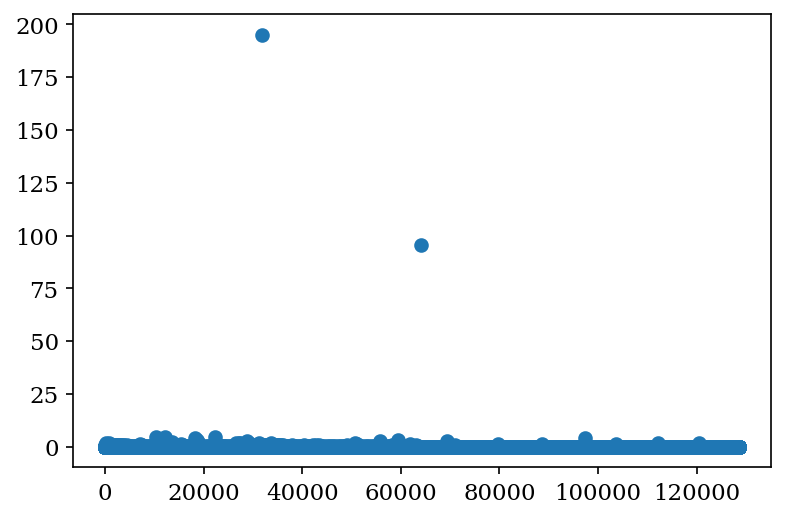

In [245]:
plt.scatter(range(len(t_combAT)-1), np.diff(t_combAT))

In [246]:
sort_idx = np.argsort(t_combAT)
np.argsort(np.diff(t_combAT[sort_idx]))[::-1]

array([31943, 64034, 22279, ...,  7407,  7670,  7422])

0
31943
Calc LS fit
(array([47.43903298, 53.69160236, 50.49211222, 54.23794952, 39.06318864,
       46.5428208 ]), array([0.00117905, 0.00063808, 0.00079246, 0.00046543, 0.00049496,
       0.00047338]), array([0.7795769 , 0.45591013, 0.32562458, 0.15994801, 0.22459851,
       0.33867623]), array([0.00302183, 0.00571051, 0.004586  , 0.00786658, 0.00739615,
       0.00773476]))
1
64034
Calc LS fit
(array([47.43903298, 53.69160236, 50.49211222, 54.23794952, 39.06318864,
       46.5428208 ]), array([0.00108084, 0.00115252, 0.00100561, 0.00046873, 0.00039949,
       0.00046761]), array([0.77271737, 0.37352518, 0.23796742, 0.93991513, 0.18801923,
       0.30420778]), array([0.00359005, 0.0033614 , 0.00388674, 0.00843289, 0.00993234,
       0.0084406 ]))
2
128643
Calc LS fit
(array([47.43903298, 53.69160236, 50.49211222, 54.23794952, 39.06318864,
       46.5428208 ]), array([0.00104106, 0.00096792, 0.00092976, 0.00056277, 0.0004395 ,
       0.00041003]), array([0.74734922, 0.36619034, 0.19123

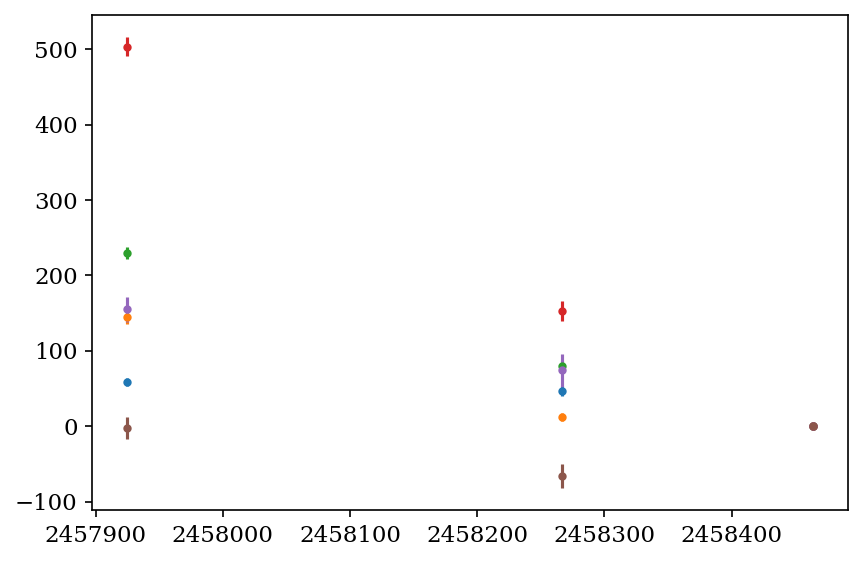

In [247]:
segment_size = [31943+1, 64034+1, len(t_combAT_hp)]
segment_borders = [0, segment_size[0], segment_size[1], segment_size[2]]

sort_idx = np.argsort(t_combAT)
times = t_combAT_hp[sort_idx]
magnitudes = m_combAT_hp[sort_idx]

time_slice, mag_slice, phase, phase_err = [], [], [], []
time_delays, time_delays_err, time_midpoints = [], [], []

iteration = 0

# Iterate over lightcurve
for t, y, idx in zip(times, magnitudes, range(len(times))):
    time_slice.append(t)
    mag_slice.append(y)

    # In each segment
    if idx == segment_borders[iteration+1]-1:
        print(iteration)
        print(idx)
        #print(time_slice)
        
#         fig1, ax1 = plt.subplots(1, 1, figsize=(6.5, 3.5*2.5/2))
#         ax1.scatter(time_slice, mag_slice)
#         ax1.axvline(min(time_slice))
#         ax1.axvline(max(time_slice))
        
#         print('Calc AS')
#         #AS################
#         freq, amp = AS(time_slice, mag_slice, 5)

#         fig, ax = plt.subplots(1, 1, figsize=(7, 4))
#         ax.plot(freq, amp)

#         freq=freq[5000:]
#         amp=amp[5000:]
#         ax.plot(freq, amp)

#         max_power = amp.max()

#         peaks, _ = find_peaks(amp, height=max_power*0.3, distance=300)
#         ax.plot(freq[peaks], amp[peaks], "x")


#         sort_idx = np.argsort(amp[peaks])[::-1]
#         f_TESS = freq[peaks][sort_idx]
#         a_TESS = amp[peaks][sort_idx]

#         print(f_TESS)
#         print(a_TESS)
#         print(len(f_TESS))
#         #####################
        
        # Append the time midpoint
        time_midpoints.append(np.mean(time_slice))

        # And the phases for each frequency
        
        print('Calc LS fit')
        sol = phases_simon(time_slice, mag_slice, f_gold3, a_gold3, [0.5]*6)
        
        print(sol)
        
        phase_i = sol[2]*2*np.pi
        phase.append(phase_i)
        phase_err_i = sol[3]*2*np.pi
        phase_err.append(phase_err_i)
        
        time_slice, mag_slice = [], []
        
        iteration += 1 

phase = np.array(phase).T
print(phase)
phase = np.unwrap(phase)
phase -= np.mean(phase)
print(phase)

phase_err = np.array(phase_err).T

print('Calc TD')
# Phase wrapping patch
for ph, ph_err, f in zip(phase, phase_err, f_gold3):
    td = ph / (2*np.pi*f)
    time_delays.append(td-np.mean(td))
    time_delays_err.append(ph_err / (2*np.pi*f))

print('Plot TD')
fig, ax = plt.subplots(1, 1, figsize=(6.5, 3.5*2.5/2))
for i in range(len(f_gold3)):
    #ax[0].scatter(time_midpoints, time_delays[i]*86400, s=5)
    ax.errorbar(time_midpoints, (time_delays[i]-time_delays[i][-1])*86400, yerr = time_delays_err[i]*86400, fmt='.')    
    #ax[0].set_ylim(-800, 800)
    #ax[1].set_ylim(-800, 800)
    
#plt.tight_layout()
#fig.savefig('f_TESS1.png', tight_layout=True)


t_td_AT = time_midpoints
tau_td_AT = []
for j in range(6):
    tau_td_AT.append(np.array([i*86400 for i in time_delays][j]-[i*86400 for i in time_delays][j][-1]))
tau_err_td_AT = time_delays_err

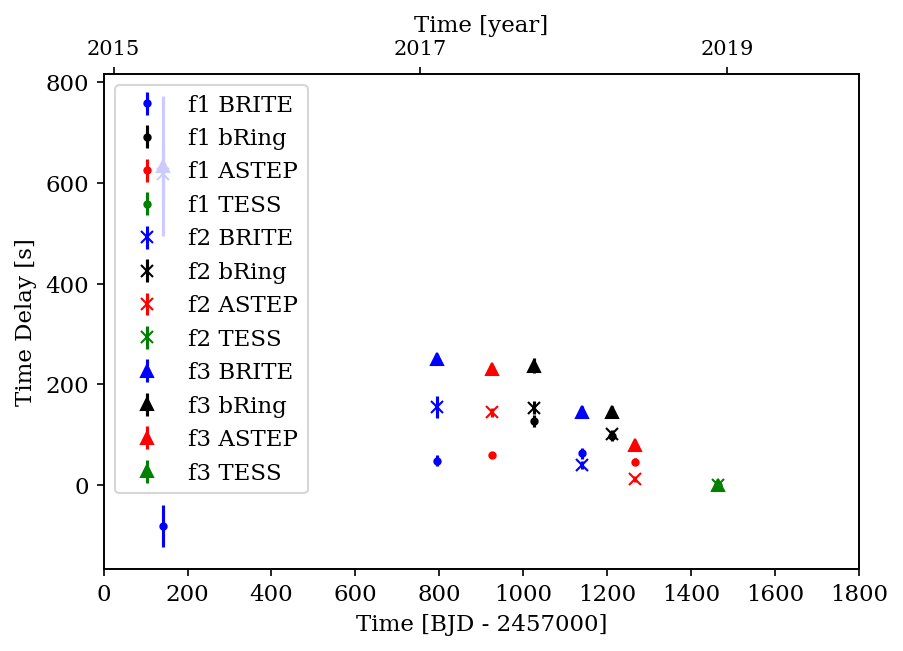

In [248]:
fig, ax = plt.subplots(1, 1, figsize=(6.5, 3.5*2.5/2))

i=0
ax.errorbar(np.array(t_td_BT)[:-1]-2457000, tau_td_BT[i][:-1], yerr = tau_err_td_BT[i][:-1]*86400, fmt='.', c='b', label='f1 BRITE')
ax.errorbar(np.array(t_td_RT)[:-1]-2457000, tau_td_RT[i][:-1], yerr = tau_err_td_RT[i][:-1]*86400, fmt='.', c='k', label='f1 bRing')
ax.errorbar(np.array(t_td_AT)[:-1]-2457000, tau_td_AT[i][:-1], yerr = tau_err_td_AT[i][:-1]*86400, fmt='.', c='r', label='f1 ASTEP')
ax.errorbar(np.array(t_td_AT)[-1]-2457000, tau_td_AT[i][-1], yerr = tau_err_td_AT[i][-1]*86400, fmt='.', c='g', label='f1 TESS')

i=1
ax.errorbar(np.array(t_td_BT)[:-1]-2457000, tau_td_BT[i][:-1], yerr = tau_err_td_BT[i][:-1]*86400, fmt='x', c='b', label='f2 BRITE')
ax.errorbar(np.array(t_td_RT)[:-1]-2457000, tau_td_RT[i][:-1], yerr = tau_err_td_RT[i][:-1]*86400, fmt='x', c='k', label='f2 bRing')
ax.errorbar(np.array(t_td_AT)[:-1]-2457000, tau_td_AT[i][:-1], yerr = tau_err_td_AT[i][:-1]*86400, fmt='x', c='r', label='f2 ASTEP')
ax.errorbar(np.array(t_td_AT)[-1]-2457000, tau_td_AT[i][-1], yerr = tau_err_td_AT[i][-1]*86400, fmt='x', c='g', label='f2 TESS')


i=2
ax.errorbar(np.array(t_td_BT)[:-1]-2457000, tau_td_BT[i][:-1], yerr = tau_err_td_BT[i][:-1]*86400, fmt='^', c='b', label='f3 BRITE')
ax.errorbar(np.array(t_td_RT)[:-1]-2457000, tau_td_RT[i][:-1], yerr = tau_err_td_RT[i][:-1]*86400, fmt='^', c='k', label='f3 bRing')
ax.errorbar(np.array(t_td_AT)[:-1]-2457000, tau_td_AT[i][:-1], yerr = tau_err_td_AT[i][:-1]*86400, fmt='^', c='r', label='f3 ASTEP')
ax.errorbar(np.array(t_td_AT)[-1]-2457000, tau_td_AT[i][-1], yerr = tau_err_td_AT[i][-1]*86400, fmt='^', c='g', label='f3 TESS')
    
    
ax.set_xlim(0, 1800)
#ax.set_ylim(100, -100)


ax.set_xlabel('Time [BJD - 2457000]')
ax.set_ylabel('Time Delay [s]')



ax2 = ax.twiny()
ax2.tick_params(axis='x', rotation=0)


ax2.set_xticks([t_2015,t_2016,t_2017,t_2018,t_2019])

xmin1, xmax1 = ax.get_xlim()
ax2.set_xlim(xmin1,xmax1)
ax2.set_xticklabels(['2015', '2016', '2017', '2018', '2019'],fontsize=10)
ax2.set_xlabel('Time [year]')

ax.legend()

#plt.savefig('final.png', dpi=300)

# TESS Model Comparison

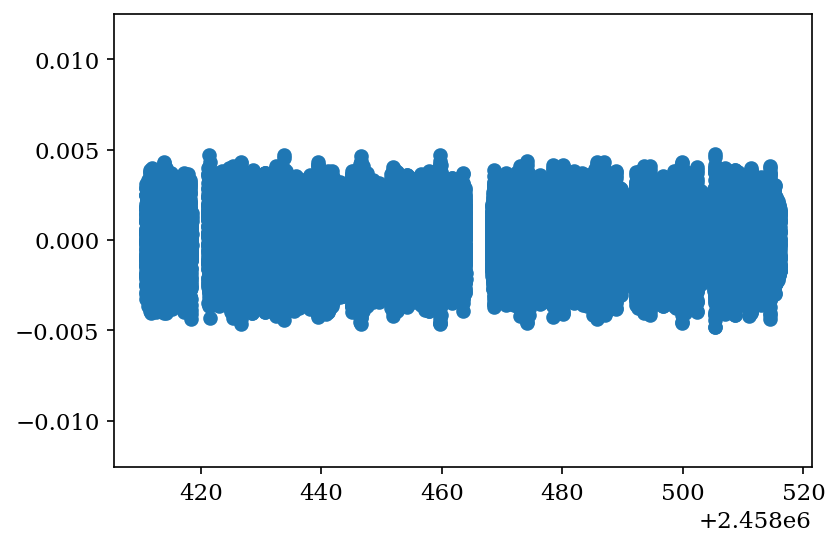

In [111]:
plt.scatter(t_TESS, highpass(m_TESS, 5, 50)[5])

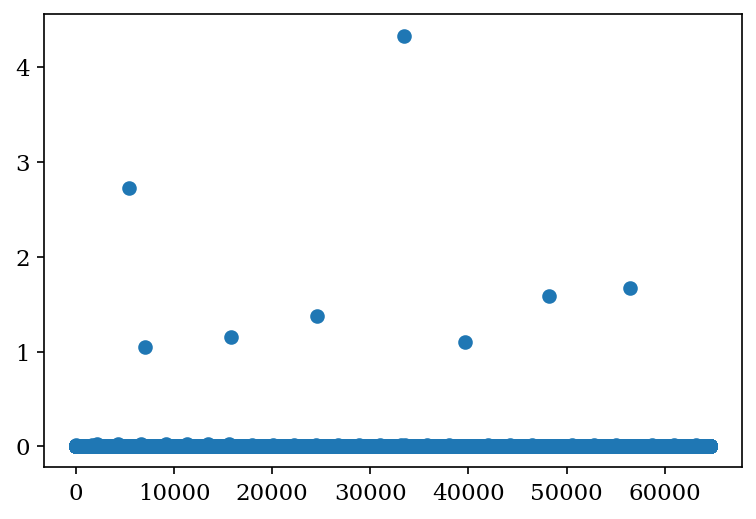

In [112]:
plt.scatter(range(len(t_TESS)-1), np.diff(t_TESS))

In [113]:
sort_idx = np.argsort(t_TESS)

In [114]:
np.argsort(np.diff(t_TESS[sort_idx]))[::-1][:10]

array([33420,  5368, 56436, 48246, 24531, 15785, 39685,  7001,  2146,
        4287])

In [115]:
segment_size = [15785+1, 33420+1, 48246+1, len(t_TESS)+1]
segment_borders = [0, segment_size[0], segment_size[1], segment_size[2], segment_size[3]]

0
1
2
3


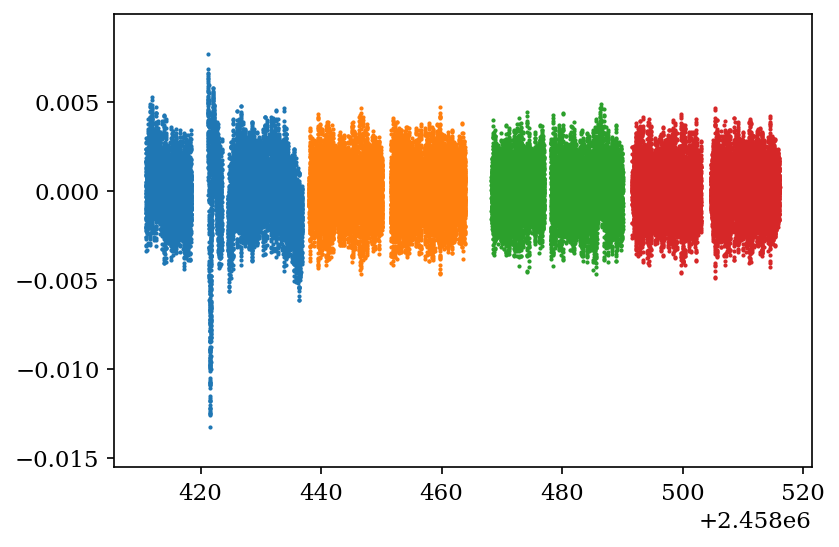

In [116]:
iterr = 0
#sort_idx = np.argsort(t_combRT)
for i in range(0,4):
    print(iterr)
    plt.scatter(t_TESS[sort_idx][segment_borders[i]:segment_borders[i+1]], m_TESS[sort_idx][segment_borders[i]:segment_borders[i+1]], s=1)
    iterr += 1

[47.43903298 53.69160236 50.49211222]
[0.00104348 0.00096971 0.0009324 ]
3


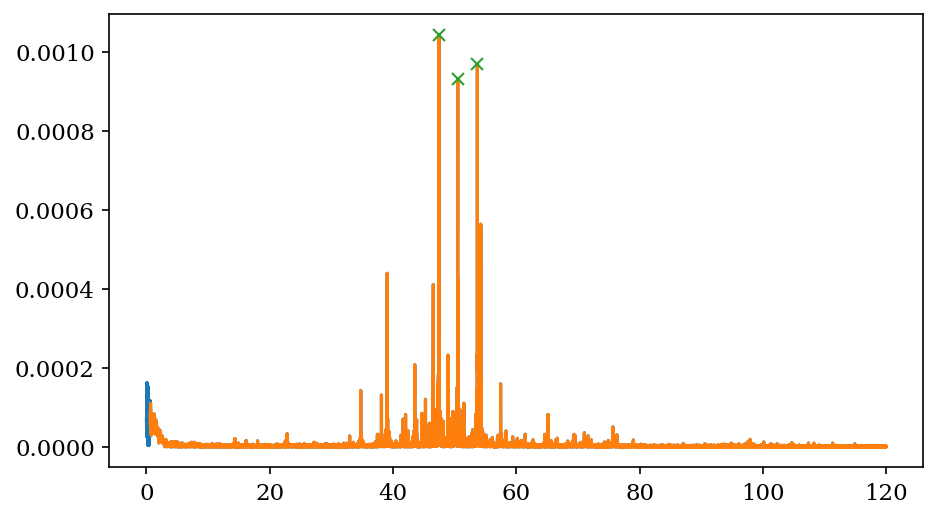

In [117]:
#AS
#freq, amp = AS(t_TESS, highpass(m_TESS, 5, 50)[5], 15)
freq, amp = AS(t_TESS, m_TESS, 15)
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.plot(freq, amp)
freq=freq[1000:]
amp=amp[1000:]
ax.plot(freq, amp)
max_power = amp.max()
peaks, _ = find_peaks(amp, height=max_power*0.6, distance=250)
ax.plot(freq[peaks], amp[peaks], "x")
sort_idx = np.argsort(amp[peaks])[::-1]
f_TESS = freq[peaks][sort_idx]
a_TESS = amp[peaks][sort_idx]
print(f_TESS)
print(a_TESS)
print(len(f_TESS))

0
15785
Calc AS
[47.4413324  53.69538321 50.49509827 39.06661085]
[0.00105027 0.00104226 0.00093148 0.00043096]
4
Calc LS fit
(array([47.43903298, 53.69160236, 50.49211222]), array([0.00106314, 0.00105978, 0.00094102]), array([0.74990522, 0.36034812, 0.20237418]), array([0.00187686, 0.00188236, 0.00219498]))
1
33420
Calc AS
[47.44211303 53.69321842 50.49444069 39.06362775]
[0.00103149 0.00098324 0.00093654 0.00044739]
4
Calc LS fit
(array([47.43903298, 53.69160236, 50.49211222]), array([0.00104801, 0.00098525, 0.00094334]), array([0.74973715, 0.36179634, 0.19471977]), array([0.00173027, 0.00187131, 0.00199633]))
2
48246
Calc AS
[47.43688073 53.69259641 50.49584302 39.0591822 ]
[0.00103121 0.00094287 0.00092015 0.00043456]
4
Calc LS fit
(array([47.43903298, 53.69160236, 50.49211222]), array([0.00103327, 0.0009402 , 0.00093036]), array([0.75026446, 0.36983969, 0.18444342]), array([0.00186474, 0.00213178, 0.00215346]))
3
64608
Calc AS
[47.43646031 50.49529413 53.69316585 39.06147146]
[0.0

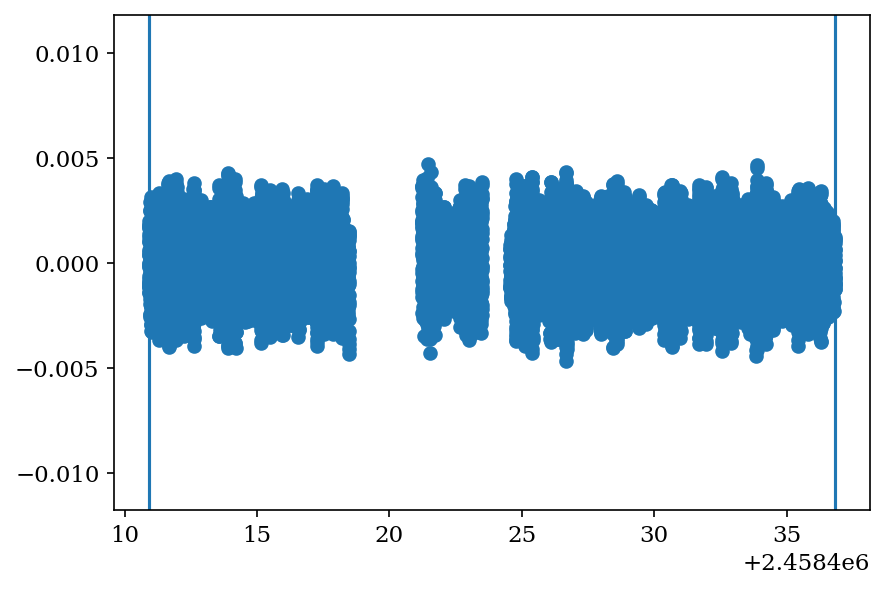

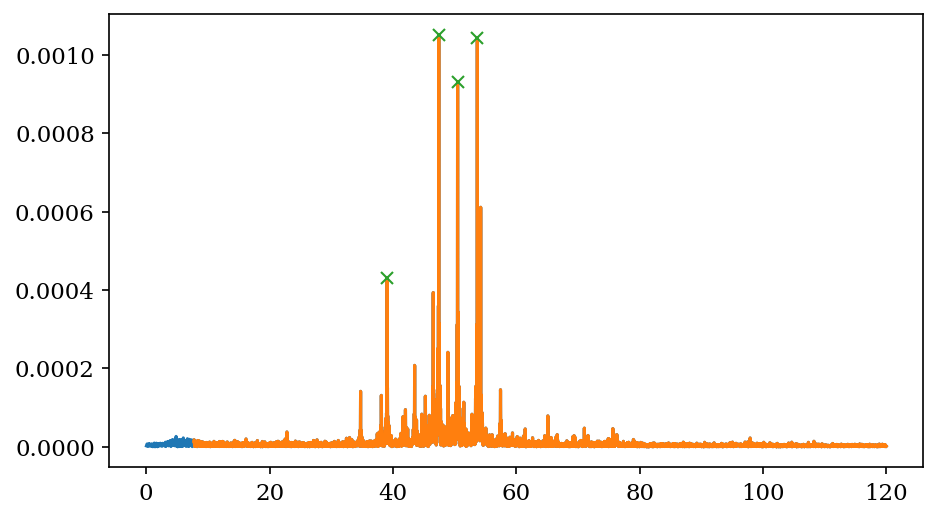

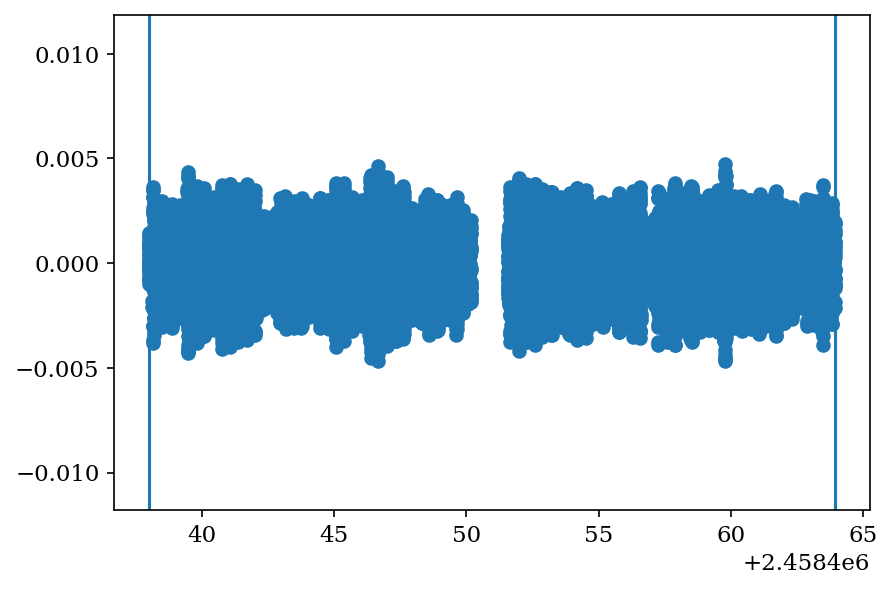

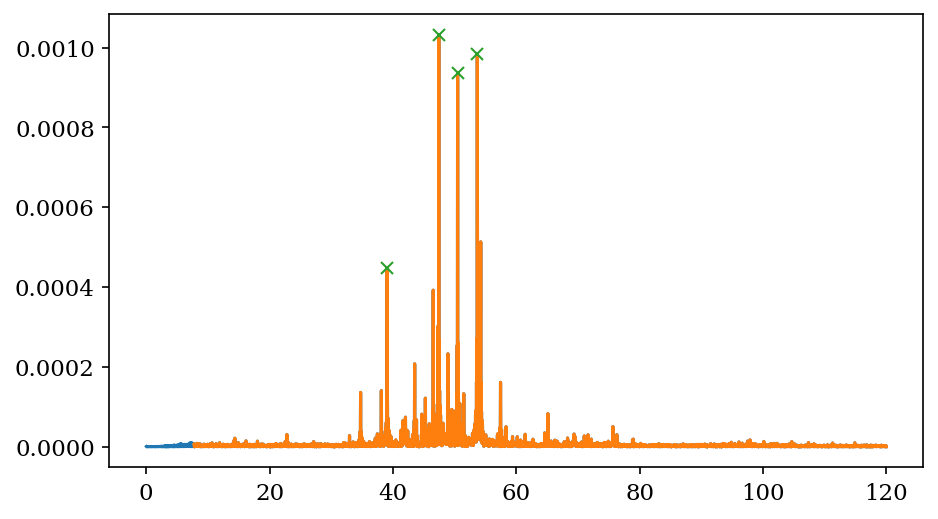

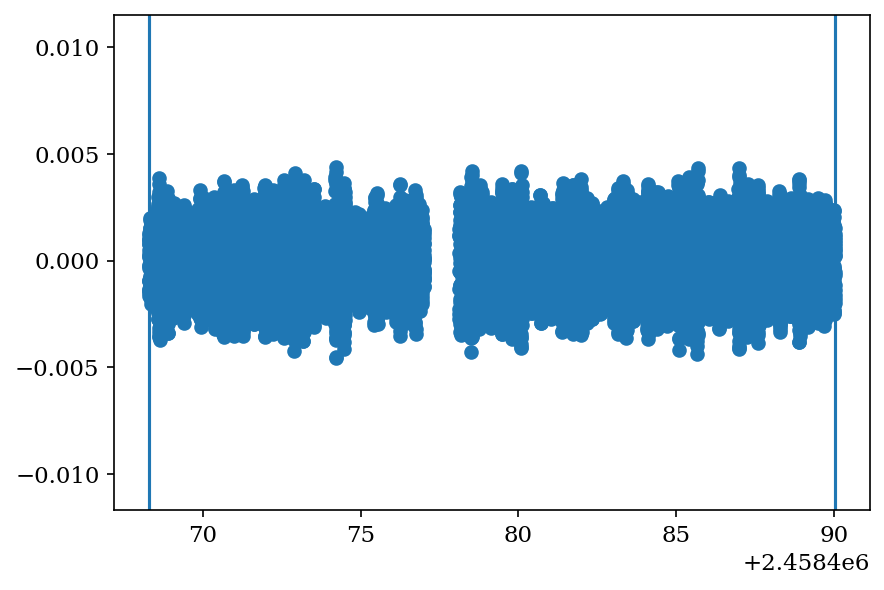

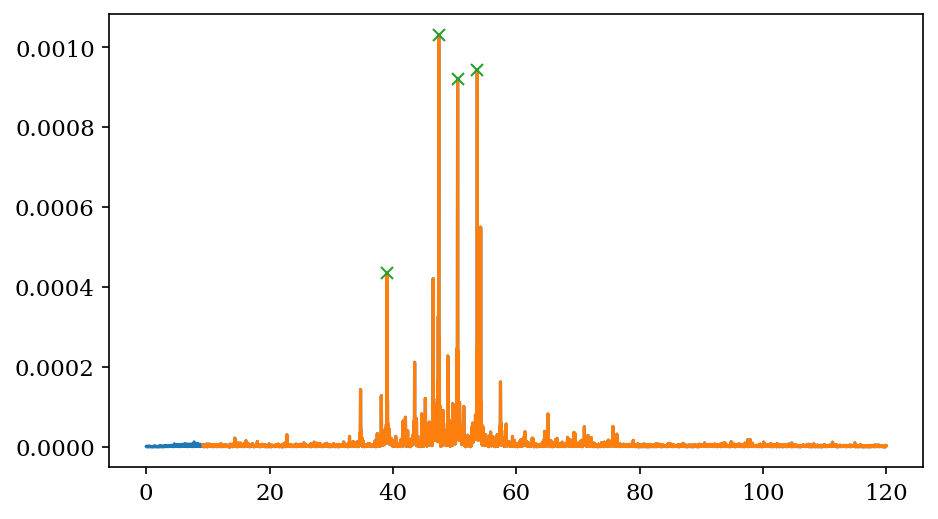

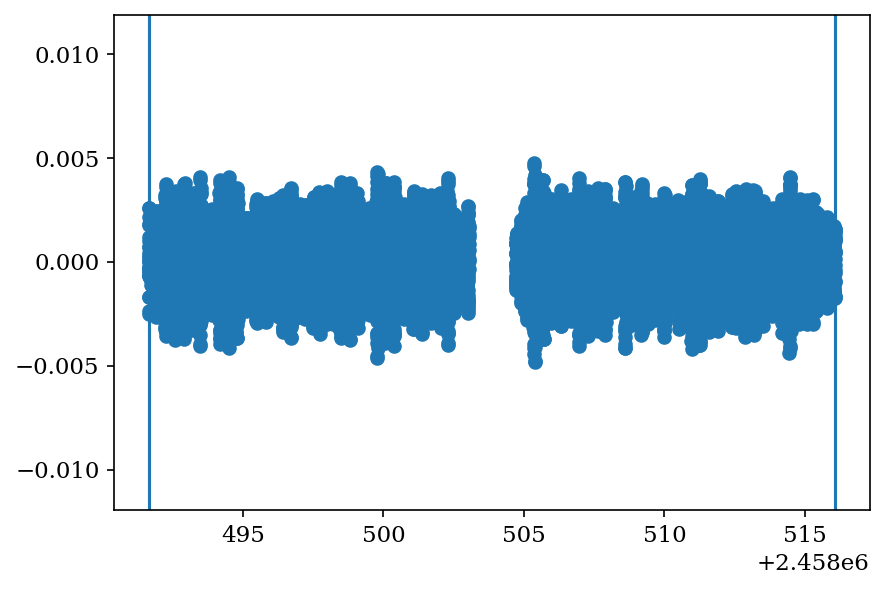

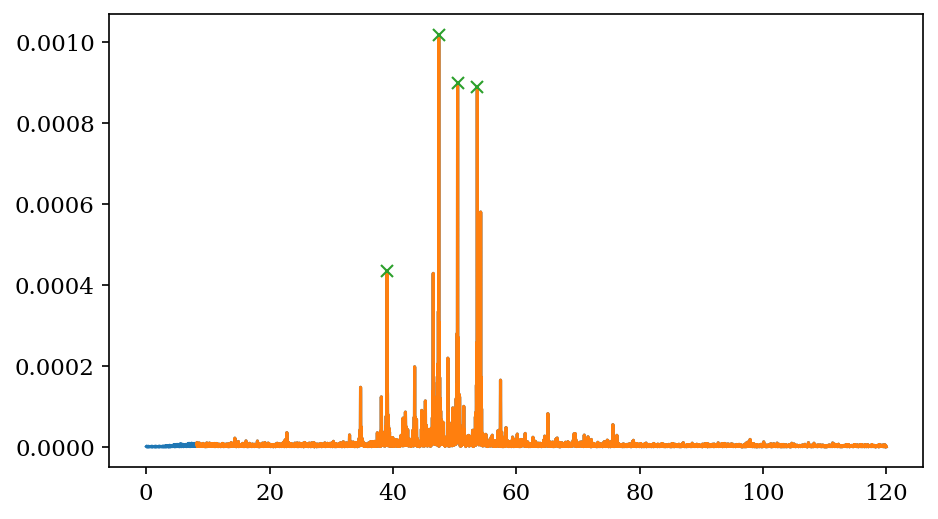

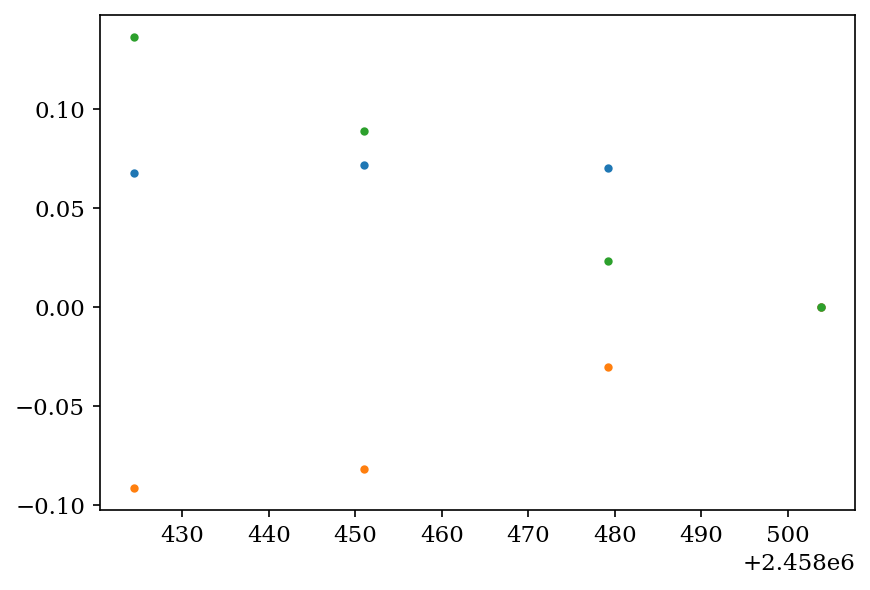

In [118]:
f_TESS_list = [47.43903298, 53.69160236, 50.49211222]
a_TESS_list = [0.00104271, 0.00096951, 0.00093177]


segment_size = [15785+1, 33420+1, 48246+1, len(t_TESS)]
segment_borders = [0, segment_size[0], segment_size[1], segment_size[2], segment_size[3]]

times = t_TESS
magnitudes = highpass(m_TESS, 5, 50)[5]

time_slice, mag_slice, phase, phase_err = [], [], [], []
time_delays, time_delays_err, time_midpoints = [], [], []

iteration = 0

# Iterate over lightcurve
for t, y, idx in zip(times, magnitudes, range(len(times))):
    time_slice.append(t)
    mag_slice.append(y)

    # In each segment
    if idx == segment_borders[iteration+1]-1:
        print(iteration)
        print(idx)
        
        fig1, ax1 = plt.subplots(1, 1, figsize=(6.5, 3.5*2.5/2))
        ax1.scatter(time_slice, mag_slice)
        ax1.axvline(min(time_slice))
        ax1.axvline(max(time_slice))
        
        print('Calc AS')
        #AS################
        freq, amp = AS(time_slice, mag_slice, 5)

        fig, ax = plt.subplots(1, 1, figsize=(7, 4))
        ax.plot(freq, amp)

        freq=freq[1000:]
        amp=amp[1000:]
        ax.plot(freq, amp)

        max_power = amp.max()

        peaks, _ = find_peaks(amp, height=max_power*0.3, distance=300)
        ax.plot(freq[peaks], amp[peaks], "x")


        sort_idx = np.argsort(amp[peaks])[::-1]
        f_TESS = freq[peaks][sort_idx]
        a_TESS = amp[peaks][sort_idx]

        print(f_TESS)
        print(a_TESS)
        print(len(f_TESS))
        #####################
        
        # Append the time midpoint
        time_midpoints.append(np.mean(time_slice))

        # And the phases for each frequency
        
        print('Calc LS fit')
        sol = phases_simon(time_slice, mag_slice, f_TESS_list, a_TESS_list, [0.5]*6)
        
        print(sol)
        
        phase_i = sol[2]*2*np.pi
        phase.append(dft_phase(time_slice, mag_slice, f_TESS_list))
        #phase.append(phase_i)
        phase_err_i = sol[3]*2*np.pi
        phase_err.append(phase_err_i)
        
        time_slice, mag_slice = [], []
        
        iteration += 1 

phase = np.array(phase).T
print(phase)
phase = np.unwrap(phase)
phase -= np.mean(phase)
print(phase)

phase_err = np.array(phase_err).T

print('Calc TD')
# Phase wrapping patch
for ph, ph_err, f in zip(phase, phase_err, f_TESS_list):
    td = ph #/ (2*np.pi*f)
    time_delays.append(td-np.mean(td))
    time_delays_err.append(ph_err / (2*np.pi*f))

print('Plot TD')
fig, ax = plt.subplots(1, 1, figsize=(6.5, 3.5*2.5/2))
for i in range(len(f_TESS_list)):
    #ax[0].scatter(time_midpoints, time_delays[i]*86400, s=5)
    ax.errorbar(time_midpoints, (time_delays[i]-time_delays[i][-1]), yerr = time_delays_err[i], fmt='.')    
    #ax[0].set_ylim(-800, 800)
    #ax[1].set_ylim(-800, 800)
    
#plt.tight_layout()
#fig.savefig('f_TESS1.png', tight_layout=True)


t_td_AT = time_midpoints
tau_td_AT = []
for j in range(len(f_TESS_list)):
    tau_td_AT.append(np.array([i*86400 for i in time_delays][j]-[i*86400 for i in time_delays][j][-1]))
tau_err_td_AT = time_delays_err

SearchResult containing 12 data products.

target_name                     productFilename                     description  distance
----------- ------------------------------------------------------- ------------ --------
  260353074 tess2018234235059-s0002-0000000260353074-0121-s_lc.fits Light curves      0.0
  260353074 tess2018263035959-s0003-0000000260353074-0123-s_lc.fits Light curves      0.0
  260353074 tess2018292075959-s0004-0000000260353074-0124-s_lc.fits Light curves      0.0
  260353074 tess2018319095959-s0005-0000000260353074-0125-s_lc.fits Light curves      0.0
  260353074 tess2018349182459-s0006-0000000260353074-0126-s_lc.fits Light curves      0.0
  260353074 tess2019006130736-s0007-0000000260353074-0131-s_lc.fits Light curves      0.0
  260353074 tess2019032160000-s0008-0000000260353074-0136-s_lc.fits Light curves      0.0
  260353074 tess2019058134432-s0009-0000000260353074-0139-s_lc.fits Light curves      0.0
  260353074 tess2019085135100-s0010-0000000260353074-0140

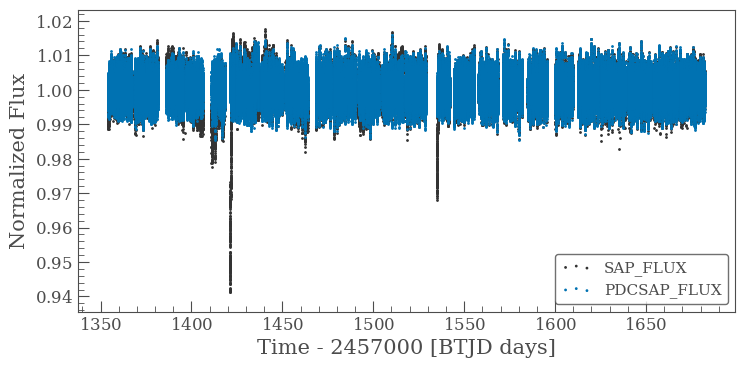

In [119]:
sr = lk.search_lightcurvefile('TIC 260353074')
print(sr)

#Download data
lcfs = sr.download_all()

# Use the normalized PDCSAP_FLUX
lc0 = lcfs[0].SAP_FLUX.normalize()
lc1 = lcfs[0].PDCSAP_FLUX.normalize()

# Loop through the rest of the LCFS, appending to the first light curve
for lcf in lcfs[1:]:
    lc0 = lc0.append(lcf.SAP_FLUX.normalize())
    lc1 = lc1.append(lcf.PDCSAP_FLUX.normalize())

#Remove bad quality and nans
q0 = lc0.quality == 0
lc0 = lc0[q0].remove_nans()
q1 = lc1.quality == 0
lc1 = lc1[q1].remove_nans()
#Plot data
ax = lc0.scatter(label = 'SAP_FLUX')
lc1.scatter(ax=ax, label = 'PDCSAP_FLUX')


#Times & Mags
times = lc1.time
flux = lc1.flux - np.mean(lc1.flux) + 1
mags = -2.5 * np.log10(flux)
mags = mags - np.mean(mags)

x_TIC = times
y_TIC = mags

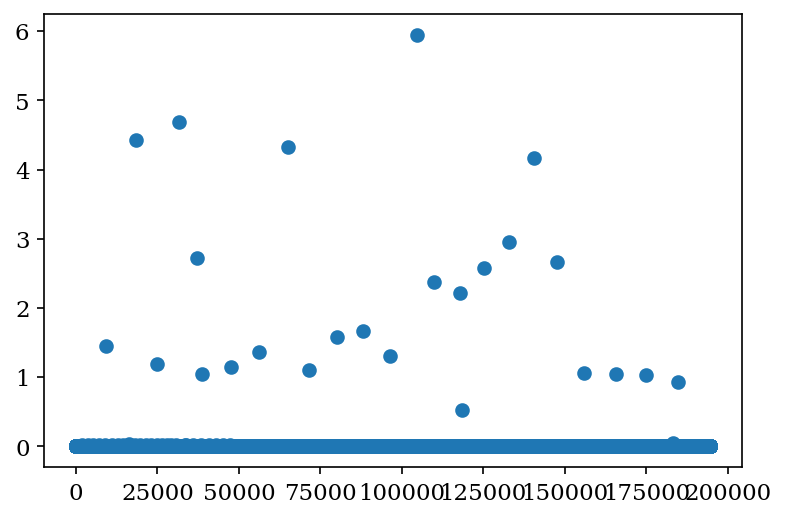

In [120]:
plt.scatter(range(len(x_TIC)-1), np.diff(x_TIC))

In [121]:
sort_idx = np.argsort(x_TIC)

In [122]:
[i+1 for i in sorted(np.argsort(np.diff(x_TIC[sort_idx]))[::-1][:25])]

[9219,
 18308,
 24988,
 31757,
 37132,
 38766,
 47550,
 56297,
 65184,
 71446,
 80005,
 88194,
 96365,
 104739,
 109759,
 117773,
 118349,
 125086,
 132777,
 140626,
 147616,
 155884,
 165778,
 174983,
 184749]

In [123]:
np.diff(x_TIC)[np.argsort(np.diff(x_TIC[sort_idx]))[::-1][:25]]

array([5.93880633, 4.68897078, 4.43481386, 4.33337036, 4.16936597,
       2.95132731, 2.72643815, 2.67217411, 2.58466961, 2.38190174,
       2.21940245, 1.66943068, 1.58747279, 1.45002298, 1.36945731,
       1.31109339, 1.19446611, 1.15418106, 1.09861184, 1.06803614,
       1.0458511 , 1.04304383, 1.0291565 , 0.93610842, 0.52499071])

In [124]:
sort_idx = np.argsort(x_TIC)

In [125]:
n=25

In [126]:
segment_size = [0]+sorted(np.argsort(np.diff(x_TIC[sort_idx]))[::-1][:25])
segment_borders = [0]+[i+1 for i in sorted(np.argsort(np.diff(x_TIC[sort_idx]))[::-1][:n])]+[len(x_TIC)]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


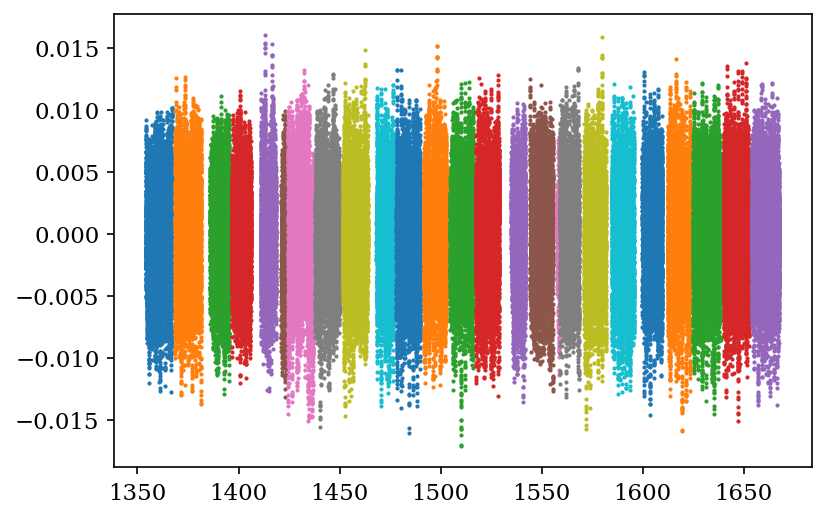

In [127]:
iterr = 0
#sort_idx = np.argsort(t_combRT)
for i in range(0,n):
    print(iterr)
    plt.scatter(x_TIC[sort_idx][segment_borders[i]:segment_borders[i+1]], y_TIC[sort_idx][segment_borders[i]:segment_borders[i+1]], s=1)
    iterr += 1

[11.99158946 14.63919138 20.87840057 13.00383616 12.49446322 14.01831695
 11.487294  ]
[0.00246508 0.00197533 0.00191925 0.00184786 0.00144314 0.00106235
 0.00103356]
7


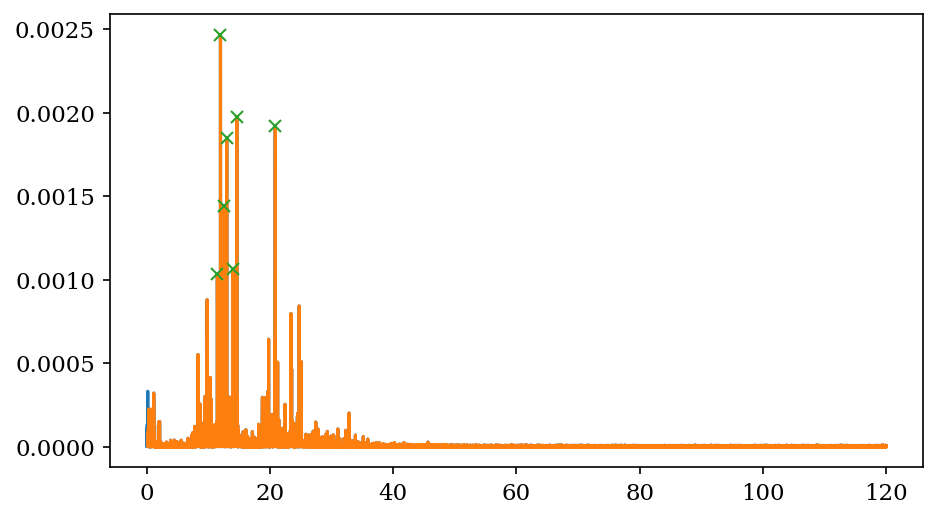

In [128]:
#AS
#freq, amp = AS(t_TESS, highpass(m_TESS, 5, 50)[5], 15)
freq, amp = AS(x_TIC, y_TIC, 15)
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.plot(freq, amp)
freq=freq[1000:]
amp=amp[1000:]
ax.plot(freq, amp)
max_power = amp.max()
peaks, _ = find_peaks(amp, height=max_power*0.4, distance=200)
ax.plot(freq[peaks], amp[peaks], "x")
sort_idx = np.argsort(amp[peaks])[::-1]
f_TESS = freq[peaks][sort_idx]
a_TESS = amp[peaks][sort_idx]
print(f_TESS)
print(a_TESS)
print(len(f_TESS))

0
9218
Calc AS
[11.99086003 14.64356947 13.00287635 20.88433678]
[0.00249718 0.00199327 0.00180179 0.00173505]
4
Calc LS fit
(array([11.99158946, 14.63919138, 20.87840057, 13.00383616, 12.49446322,
       14.01831695, 11.487294  ]), array([0.00249901, 0.00198832, 0.00174754, 0.00179366, 0.00140625,
       0.00108151, 0.00086126]), array([0.38718754, 0.33002485, 0.42249962, 0.07739394, 0.90195089,
       0.13527036, 0.85672994]), array([0.00321232, 0.0042273 , 0.00489614, 0.0047613 , 0.00620298,
       0.00820031, 0.01034833]))
1
18307
Calc AS
[11.98944774 14.63827922 20.88084697 13.01180375]
[0.00251553 0.00199707 0.00196946 0.00184575]
4
Calc LS fit
(array([11.99158946, 14.63919138, 20.87840057, 13.00383616, 12.49446322,
       14.01831695, 11.487294  ]), array([0.00251418, 0.00199894, 0.00196843, 0.00181042, 0.00172076,
       0.00110794, 0.00119018]), array([0.40459873, 0.34079886, 0.43797868, 0.10183171, 0.92700452,
       0.14292689, 0.89859655]), array([0.00336942, 0.00442312, 0.

/home/sebastian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/sebastian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(array([11.99158946, 14.63919138, 20.87840057, 13.00383616, 12.49446322,
       14.01831695, 11.487294  ]), array([0.00241352, 0.00199463, 0.00188588, 0.00186788, 0.00172728,
       0.00113915, 0.00099514]), array([0.41413859, 0.3628372 , 0.46224726, 0.09170367, 0.95406695,
       0.17700151, 0.9026856 ]), array([0.00367446, 0.00460239, 0.00490284, 0.00495758, 0.00540179,
       0.00842414, 0.00969056]))
11
88193
Calc AS
[11.99419673 20.86709665 14.6420384  12.99371312 24.75994997]
[0.00258521 0.00204167 0.00194043 0.00178327 0.0013108 ]
5
Calc LS fit
(array([11.99158946, 14.63919138, 20.87840057, 13.00383616, 12.49446322,
       14.01831695, 11.487294  ]), array([0.00258829, 0.00194669, 0.00202567, 0.00180611, 0.00151726,
       0.00097496, 0.00109411]), array([0.3913692 , 0.33559798, 0.4212721 , 0.08014791, 0.9543296 ,
       0.14349009, 0.91081375]), array([0.00344075, 0.00483002, 0.00461501, 0.00525329, 0.00634937,
       0.01010325, 0.00897904]))
12
96364
Calc AS
[11.98691435 14.6

/home/sebastian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


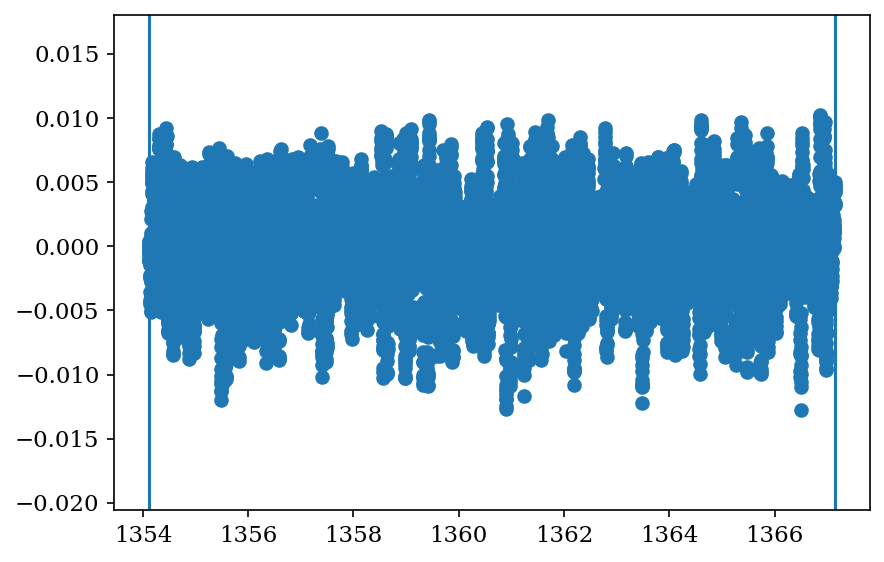

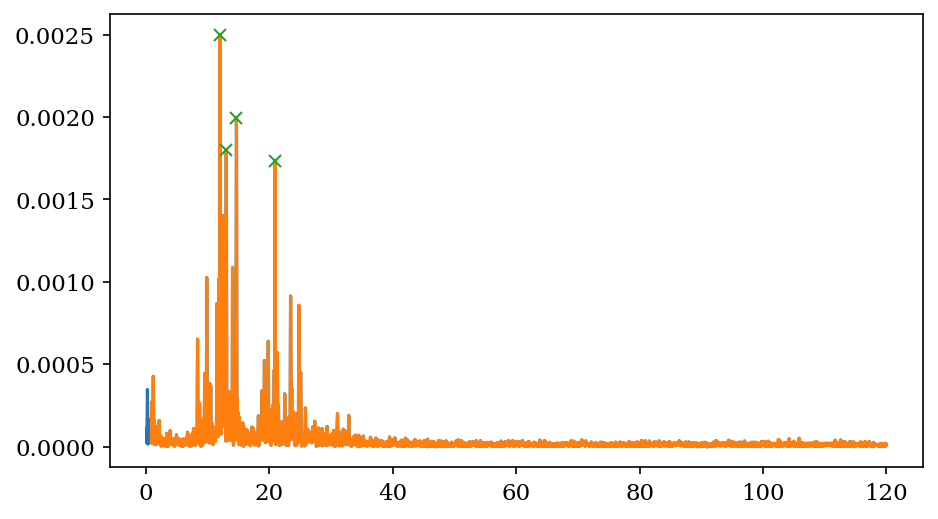

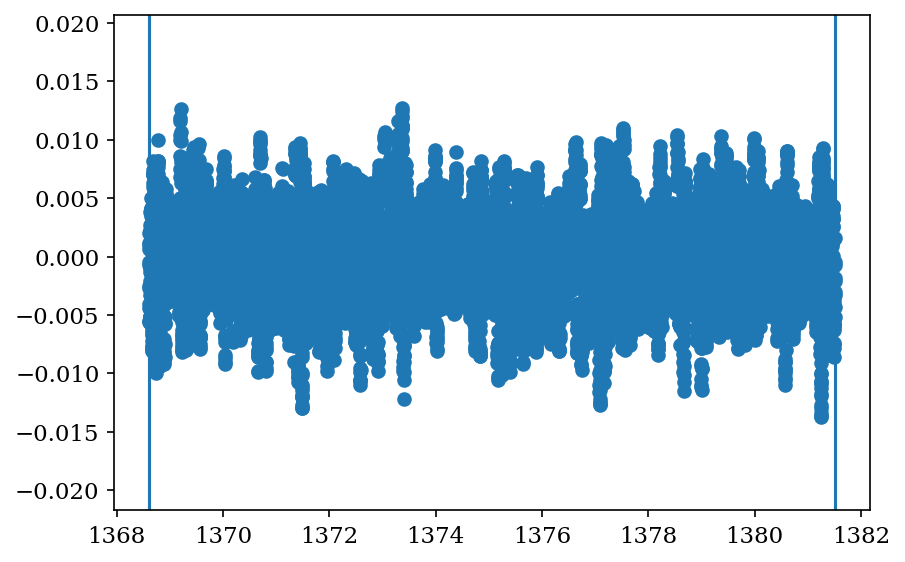

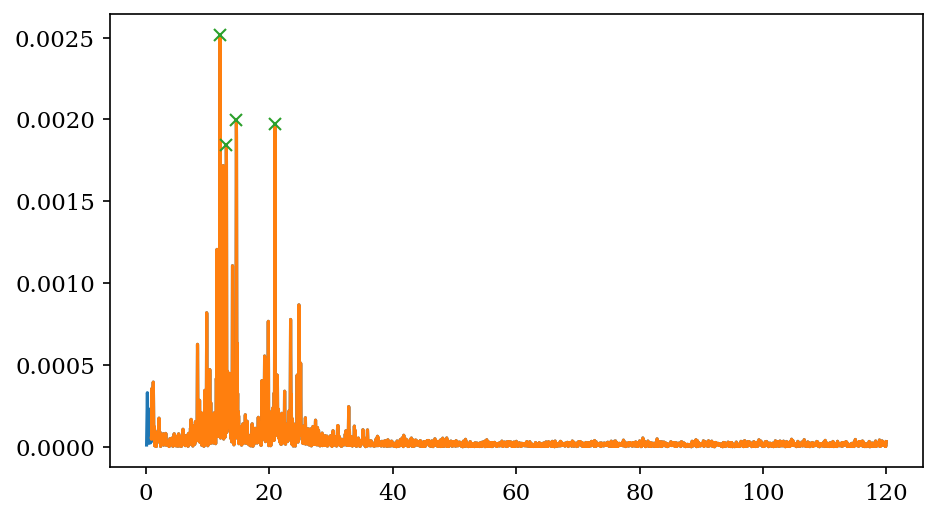

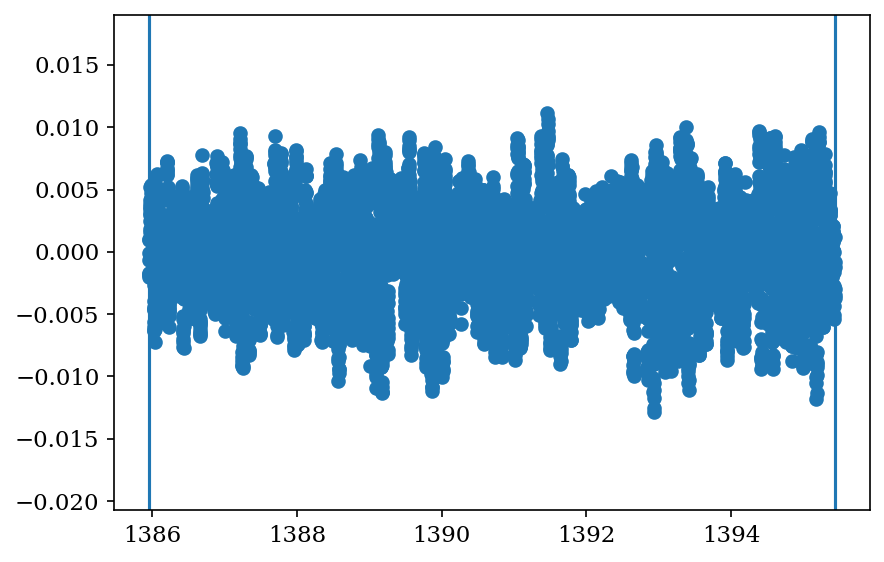

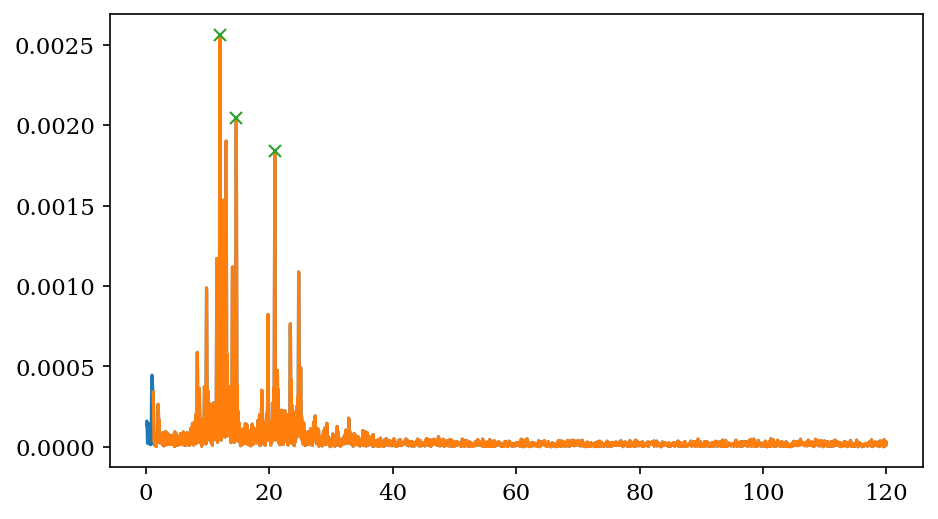

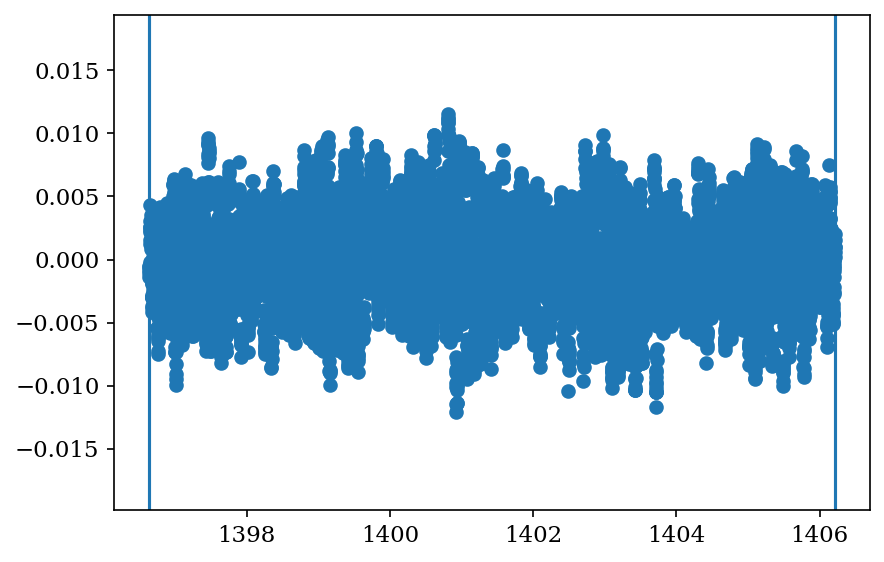

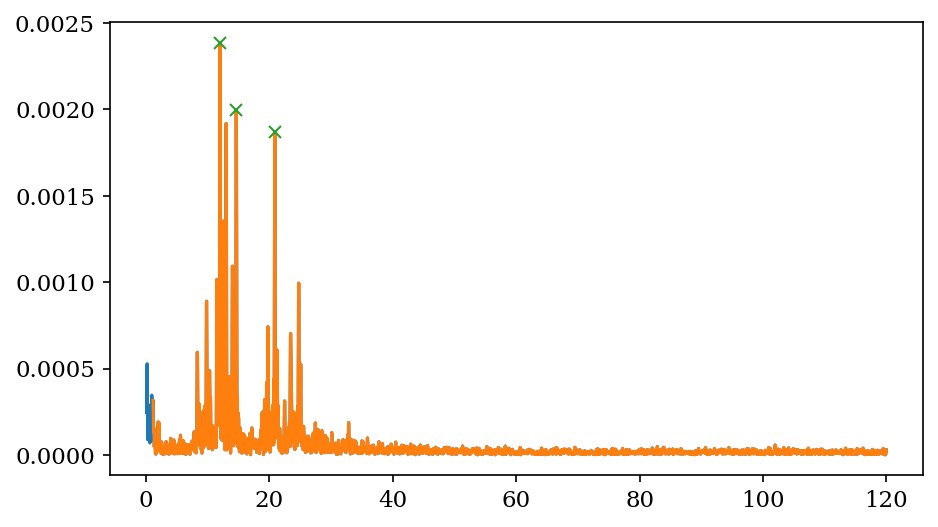

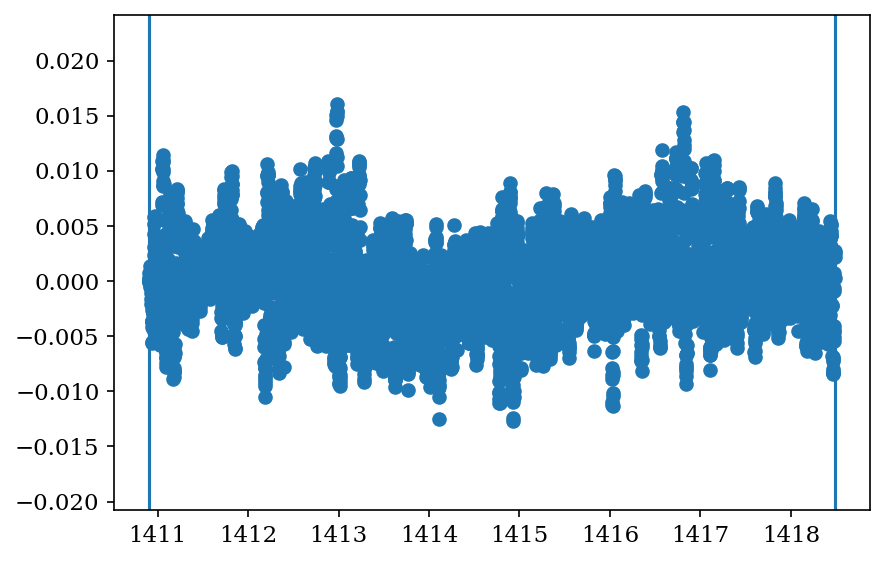

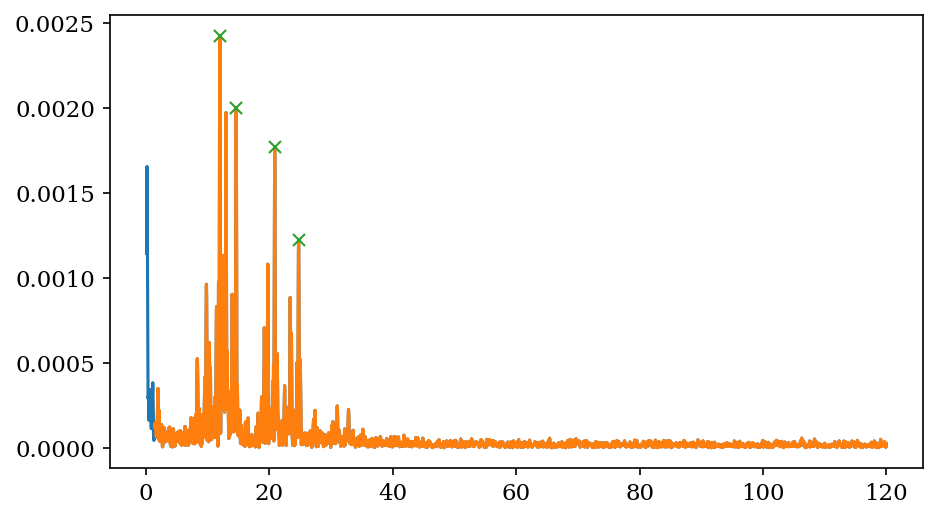

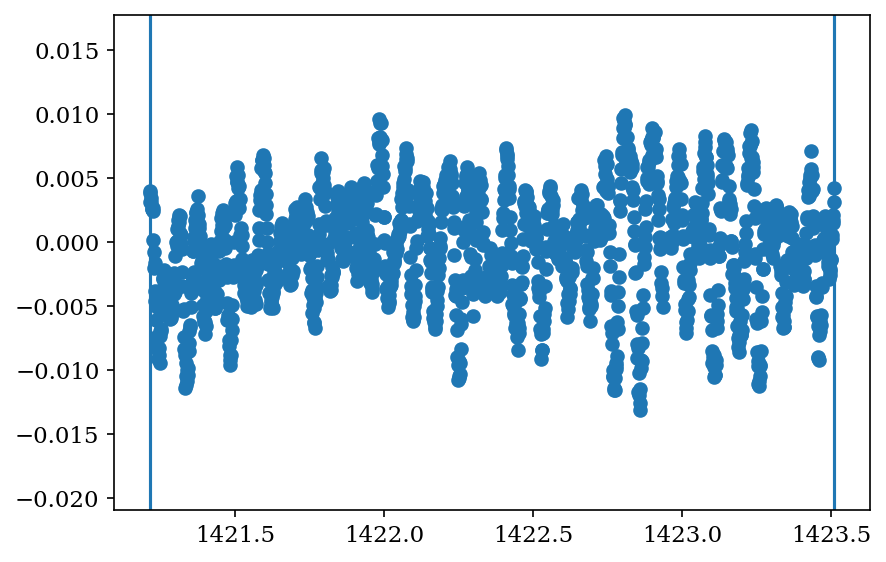

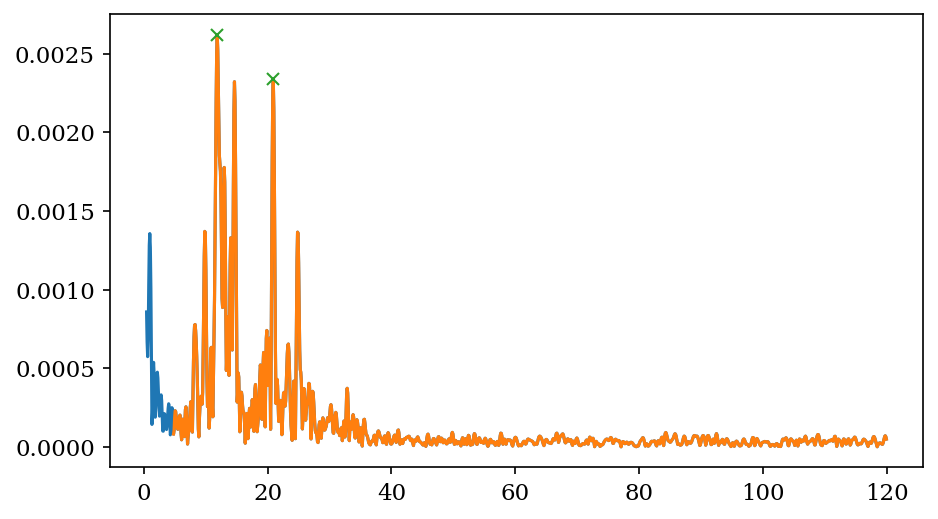

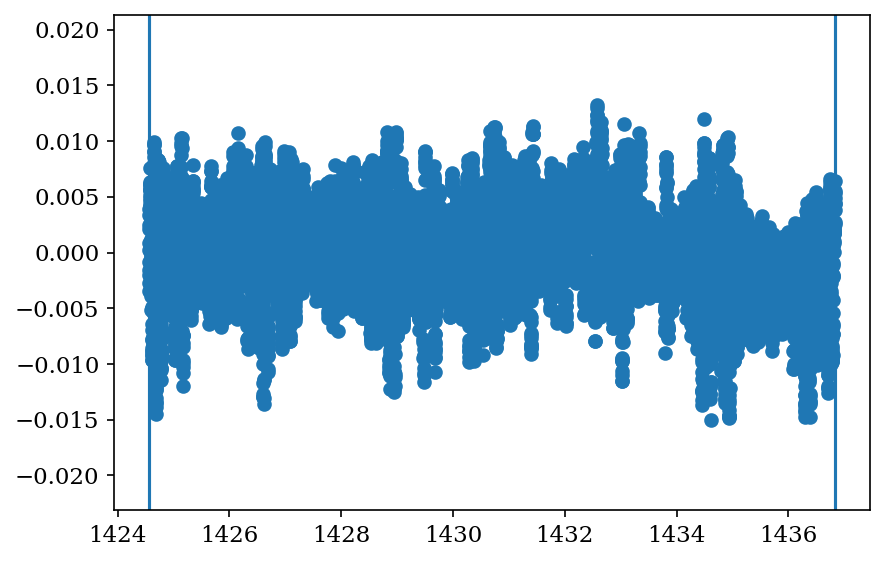

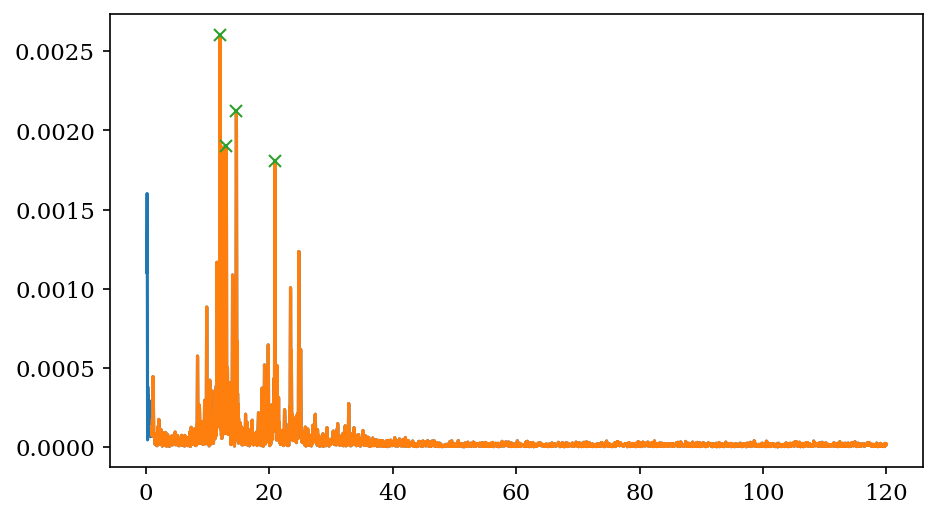

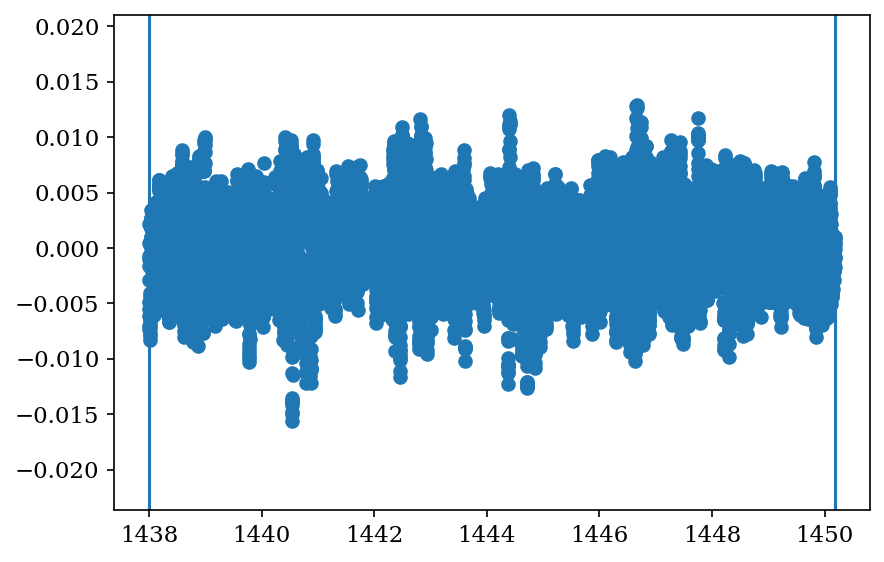

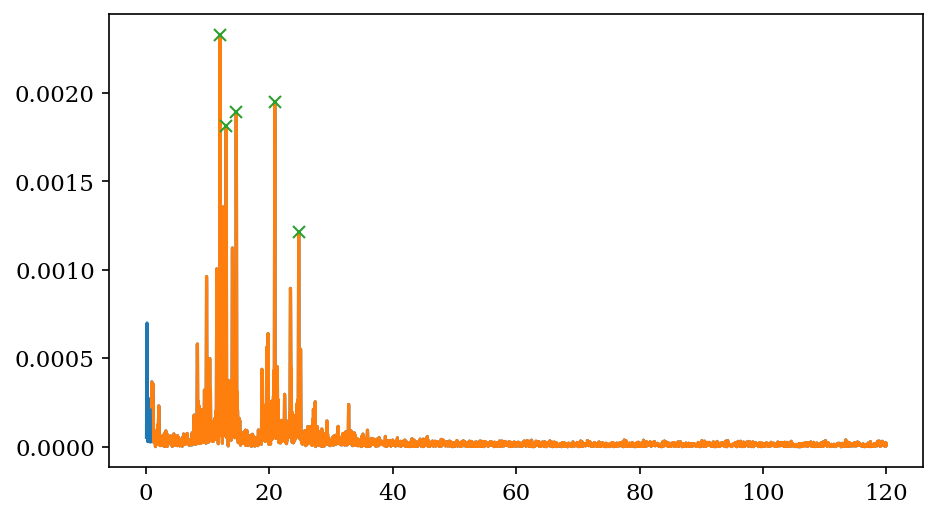

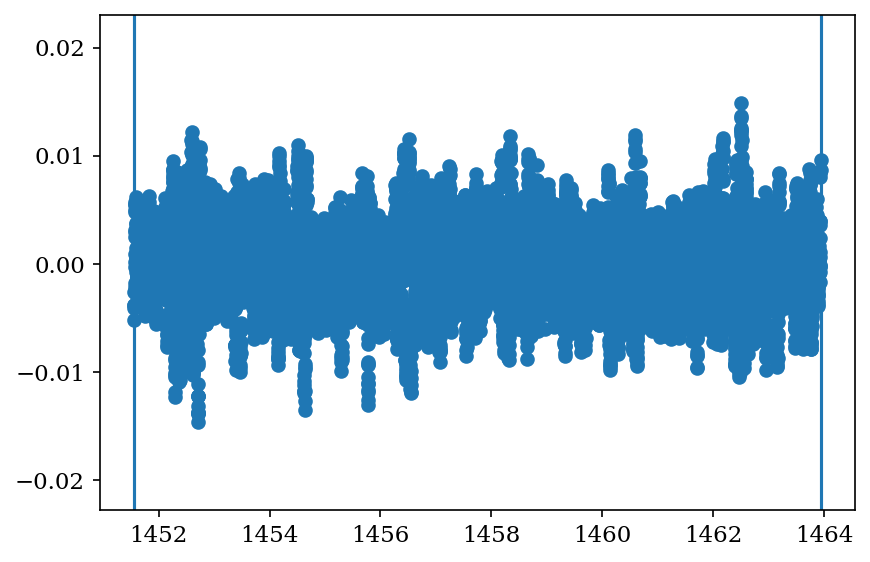

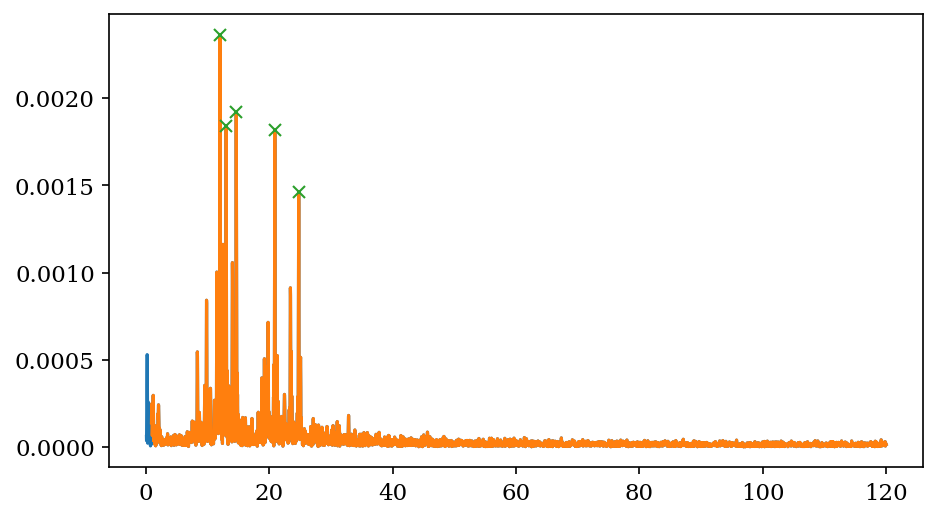

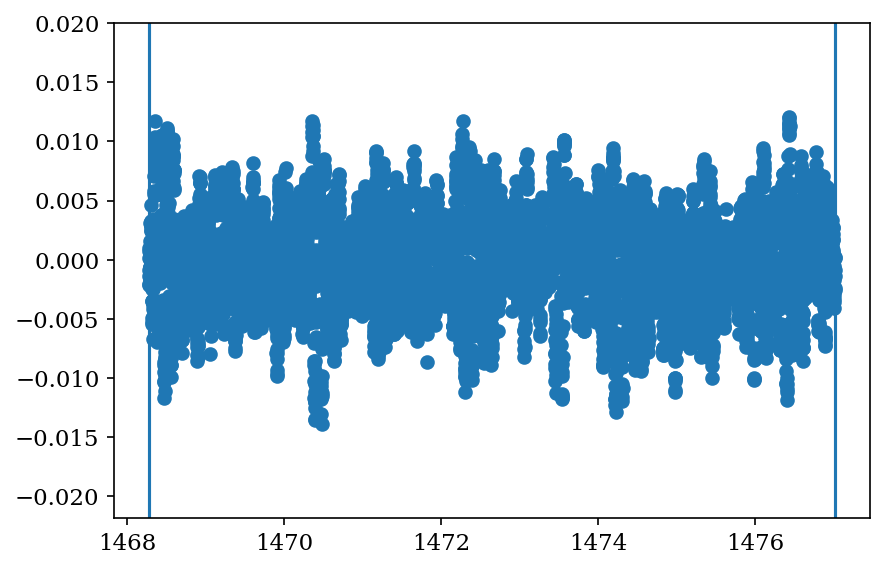

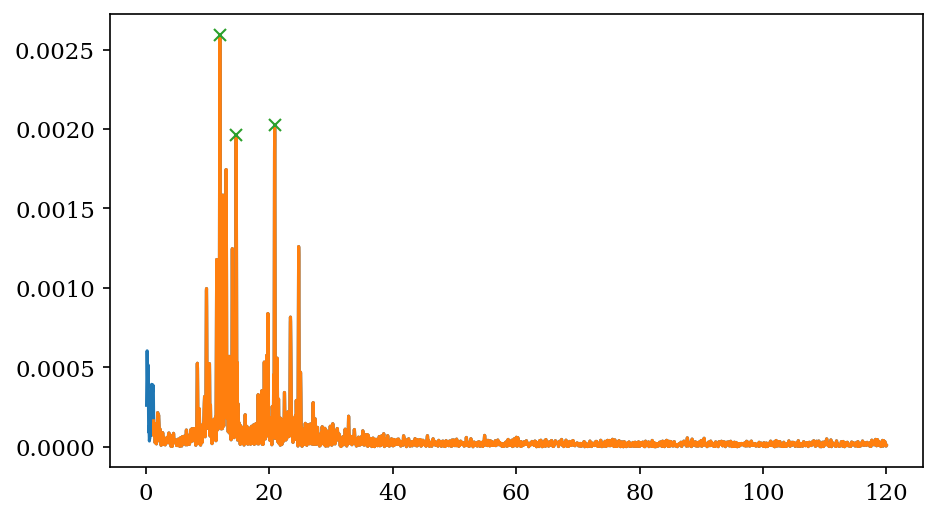

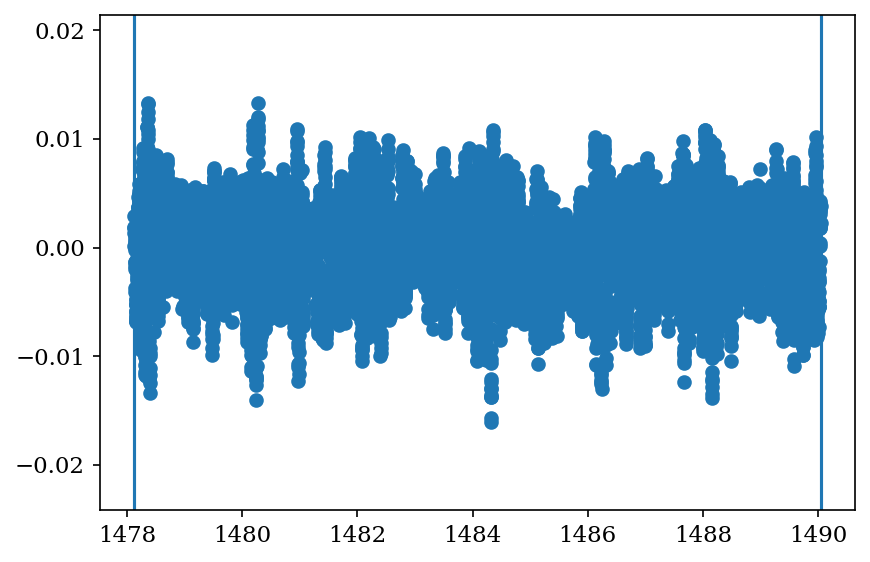

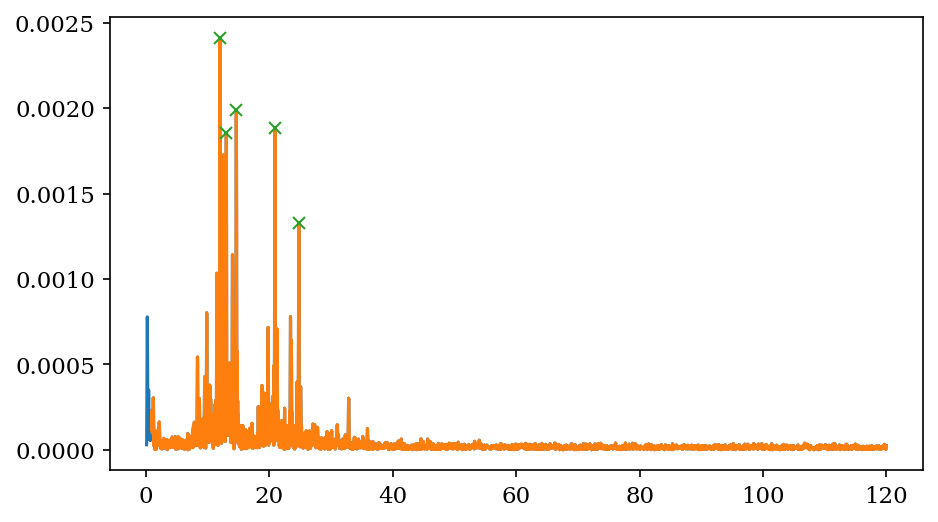

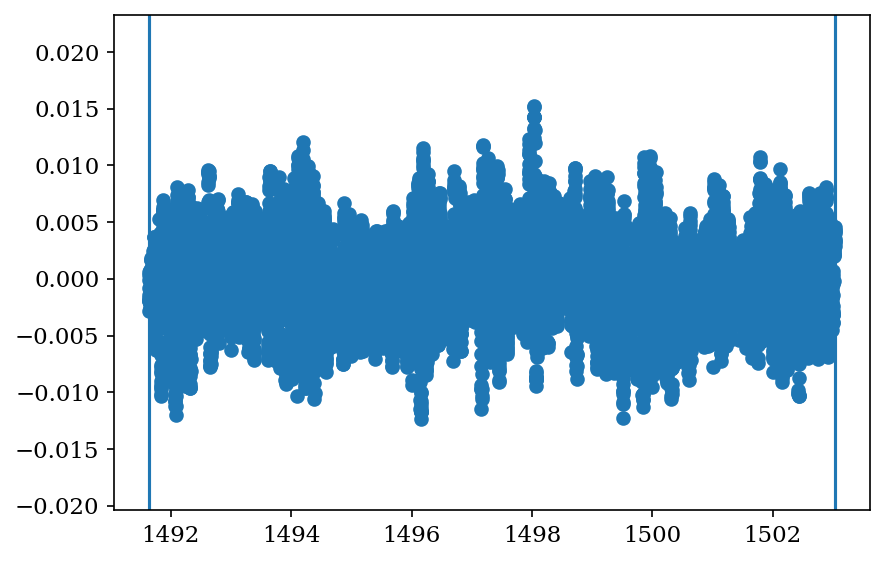

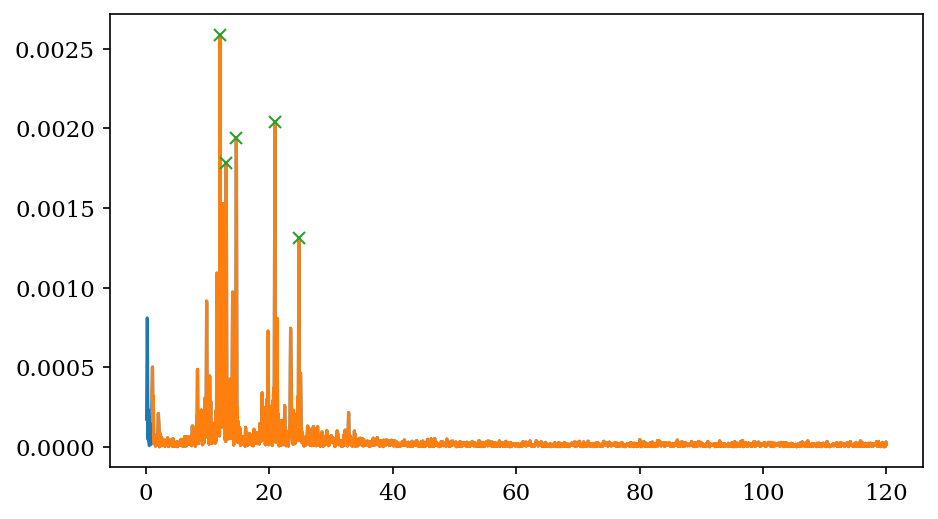

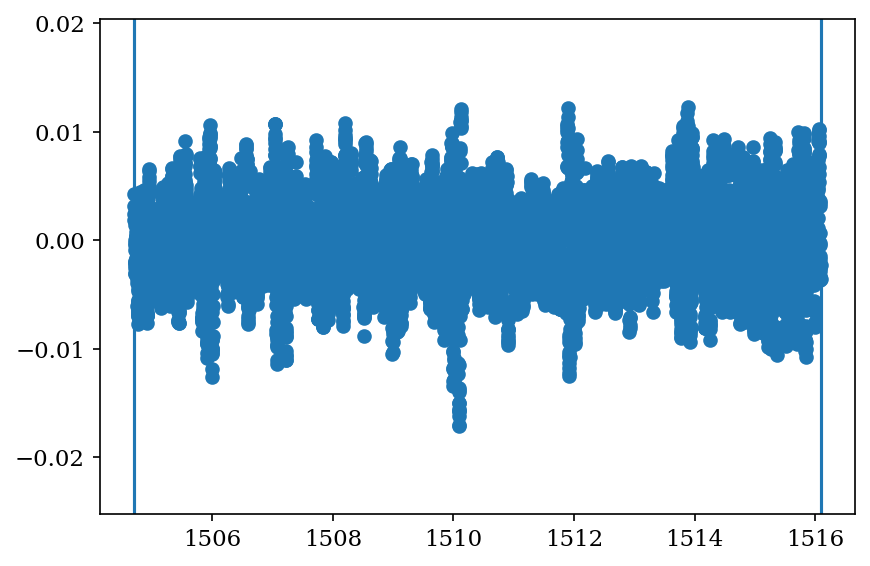

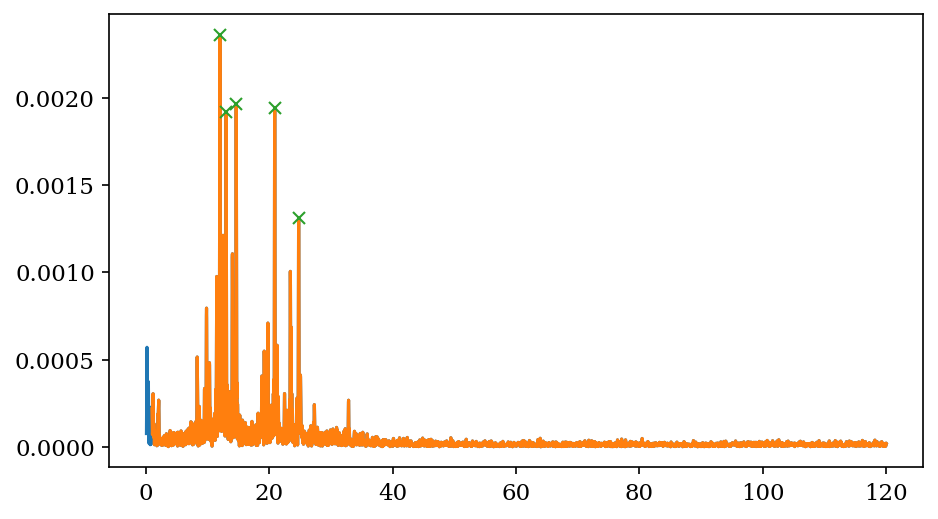

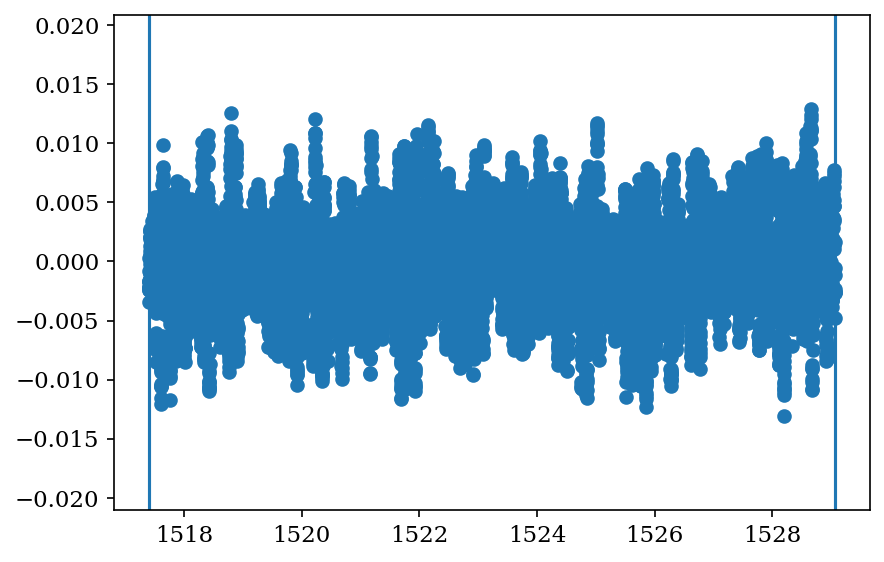

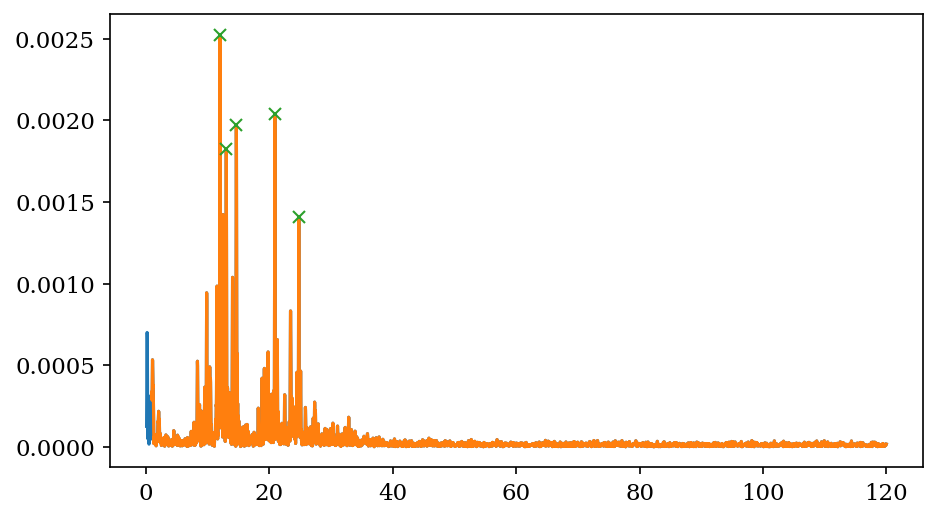

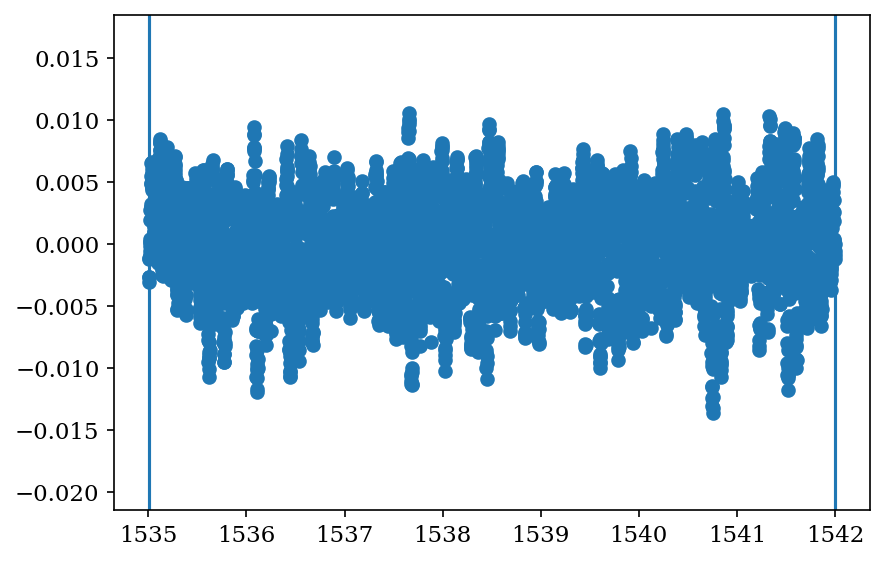

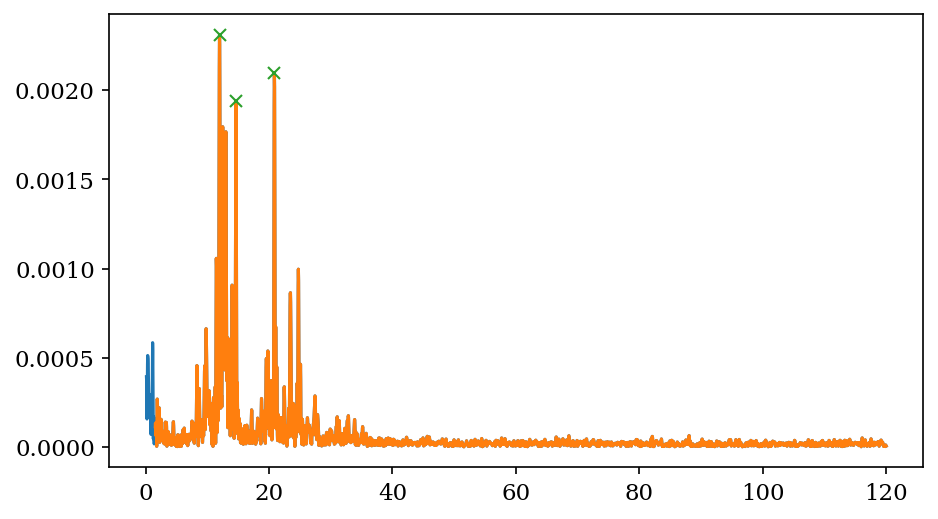

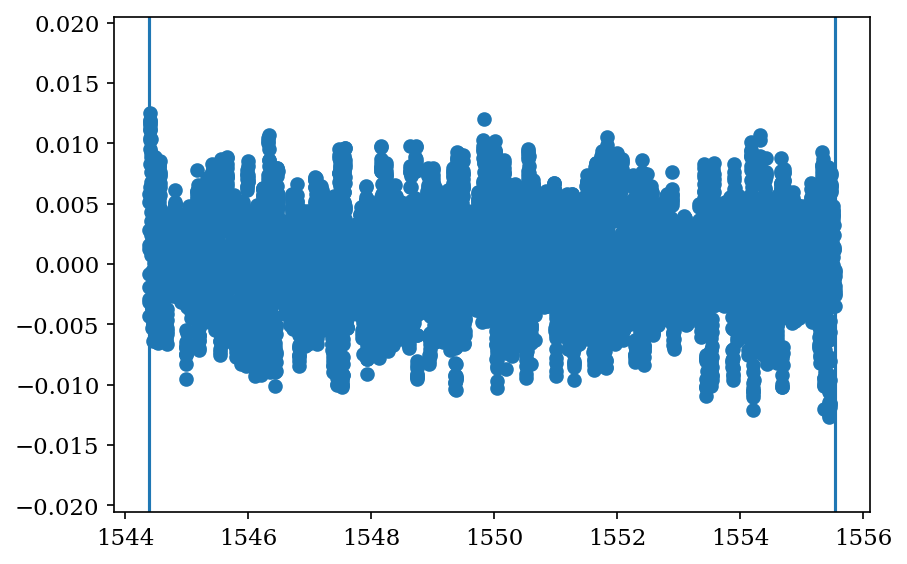

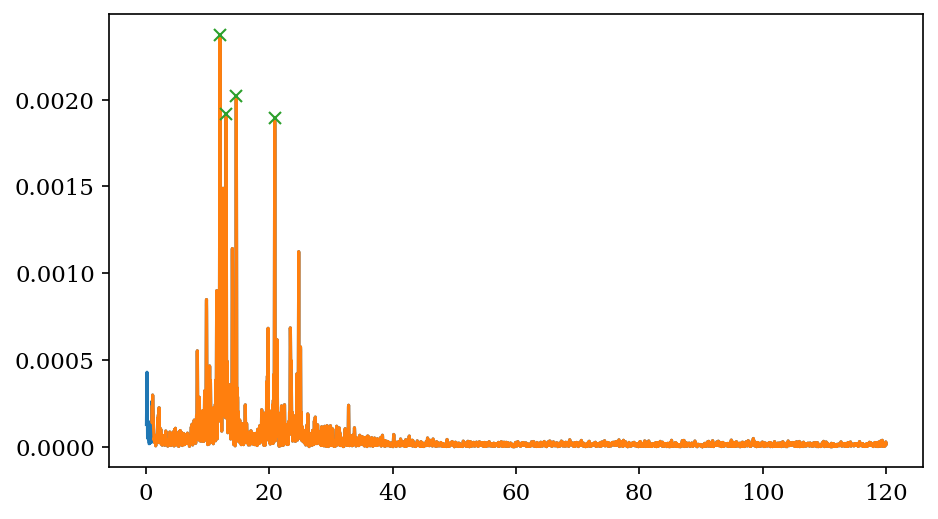

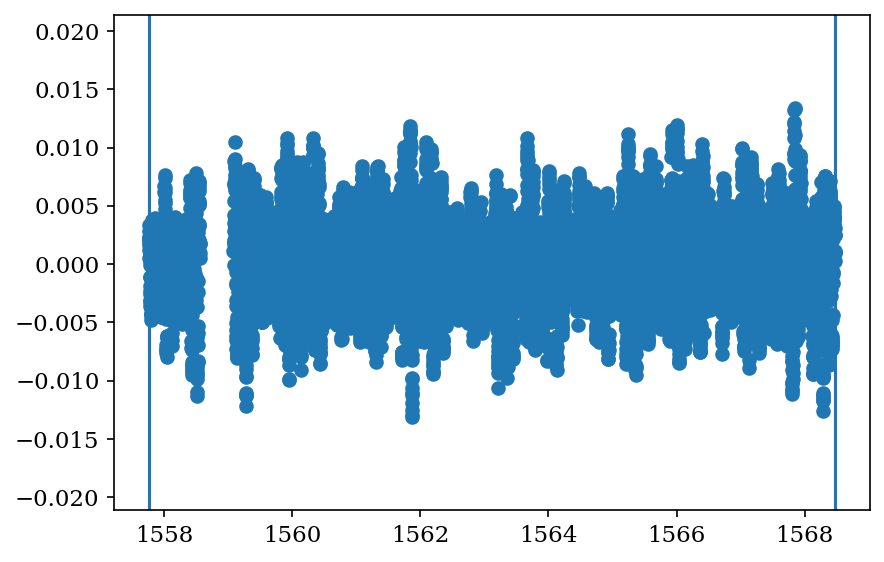

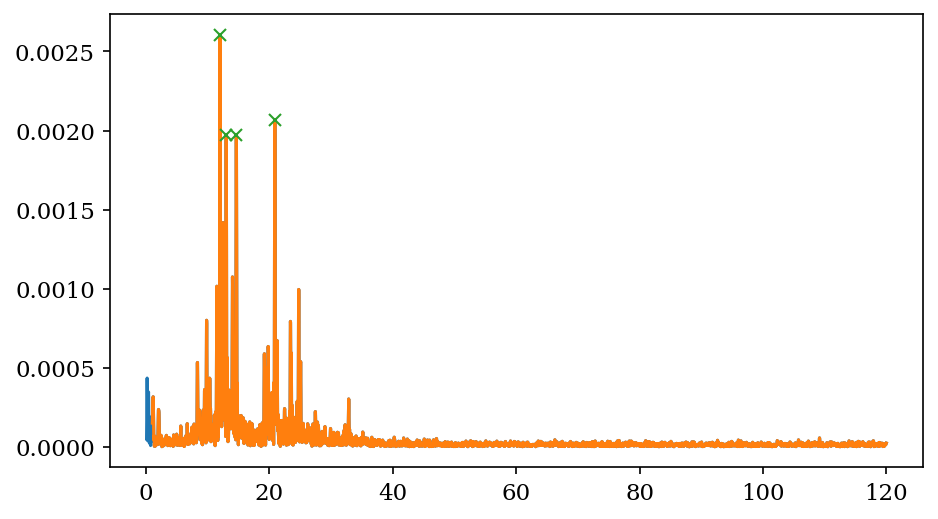

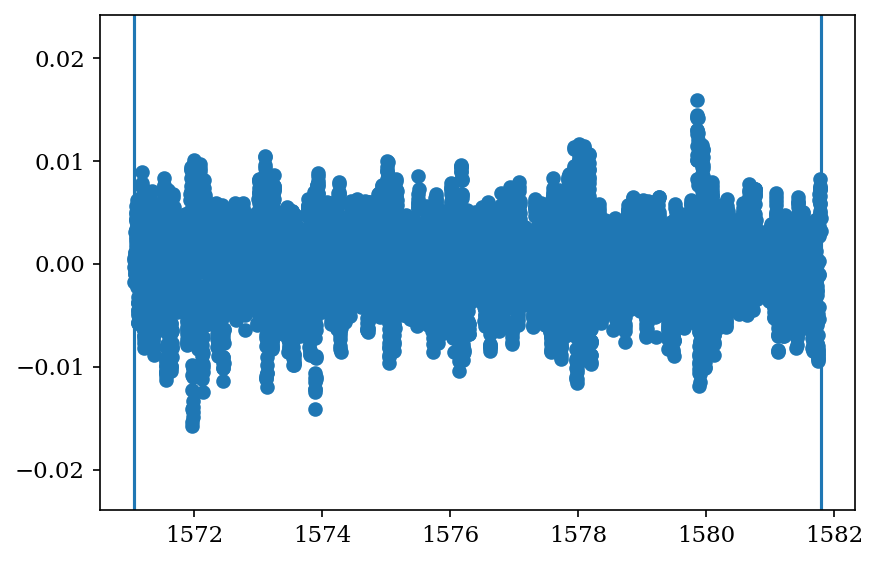

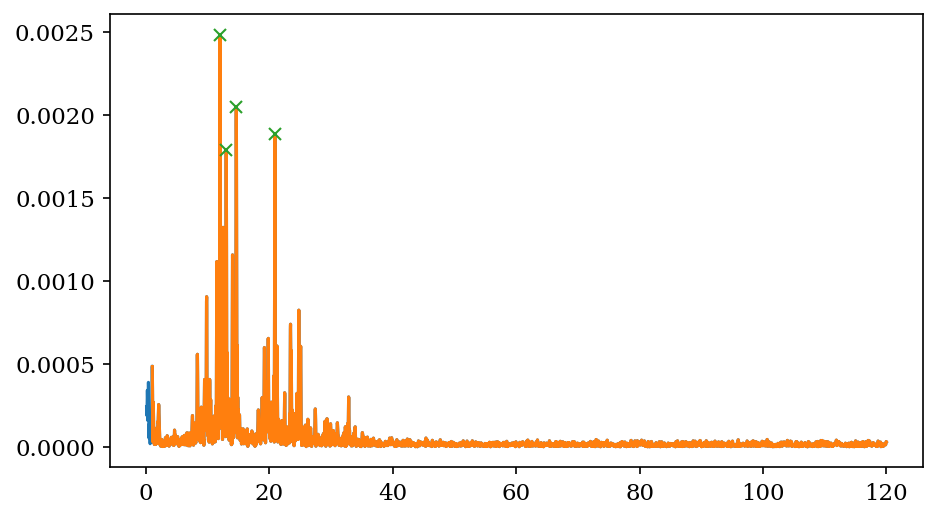

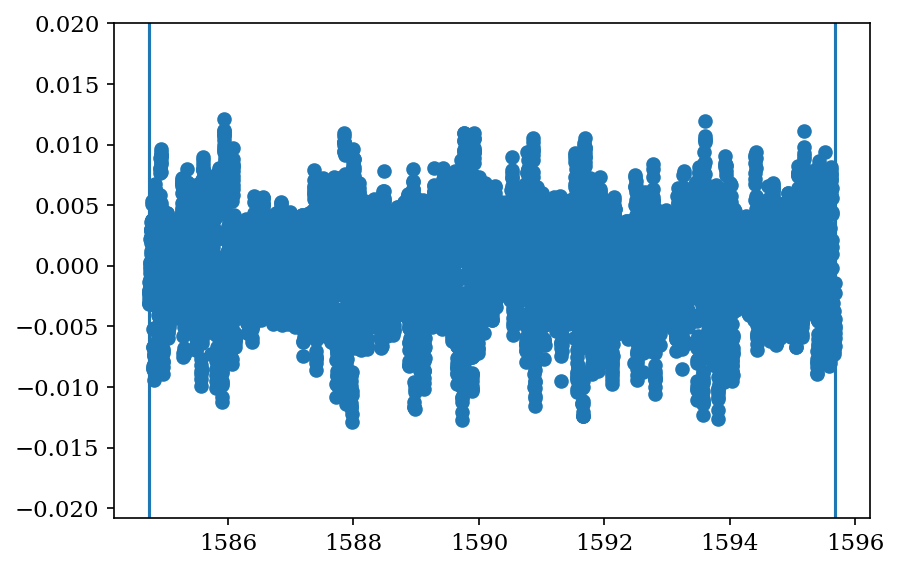

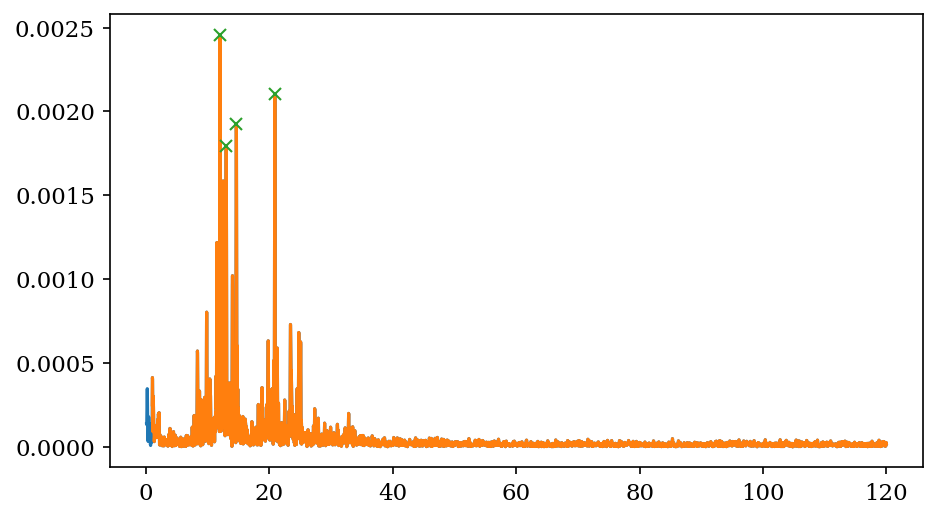

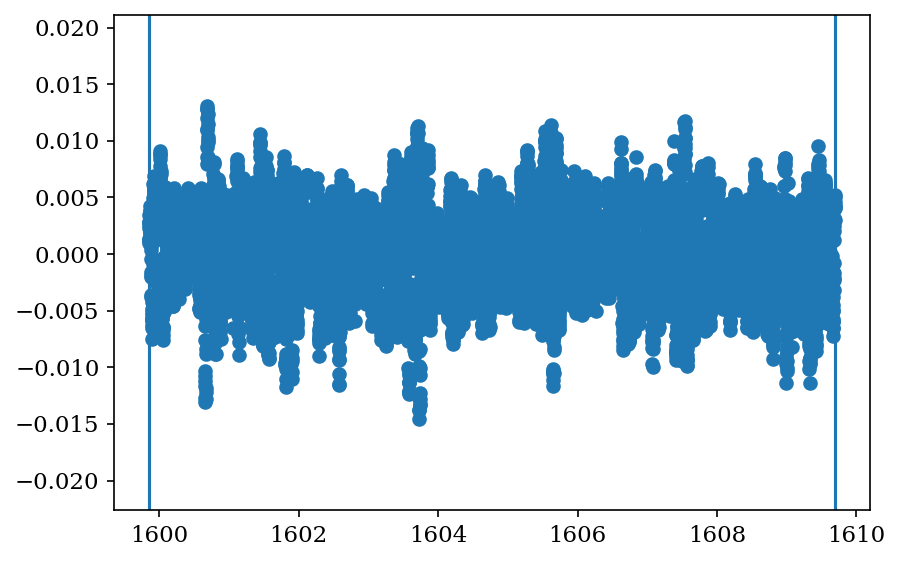

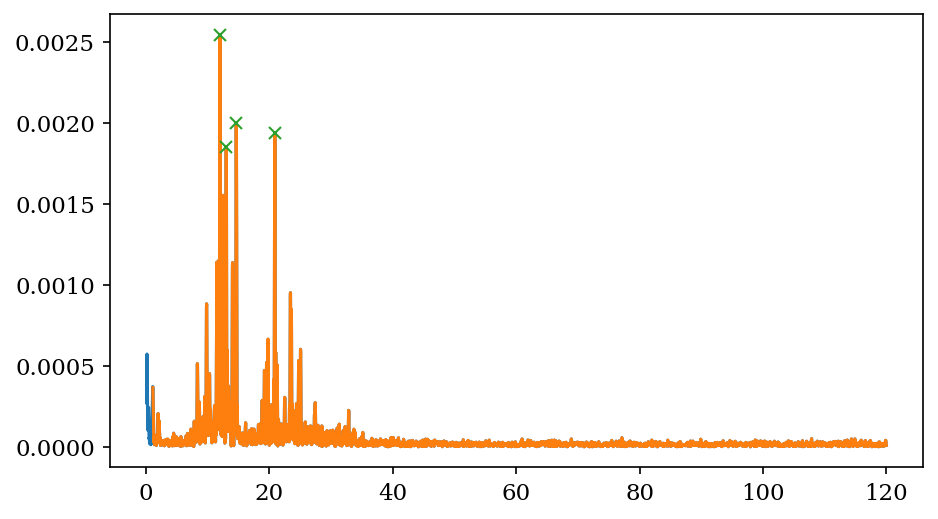

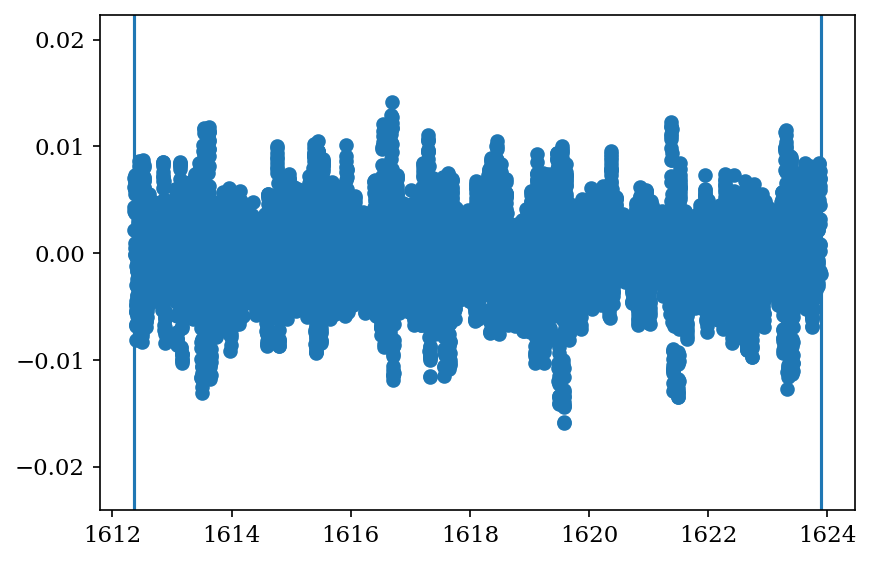

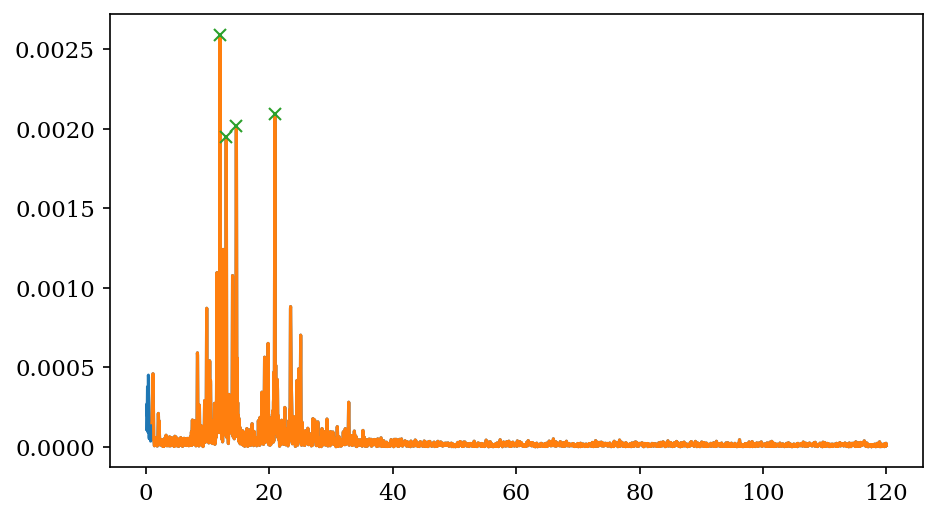

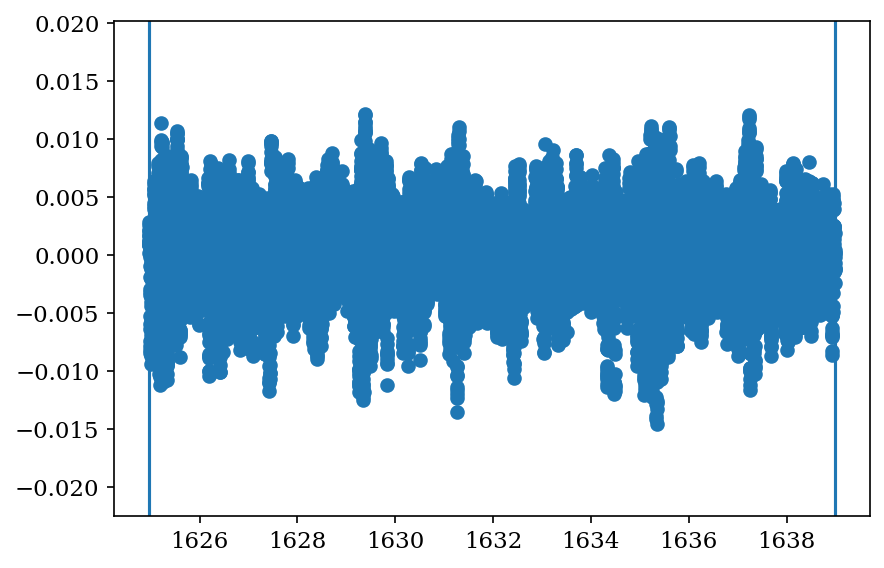

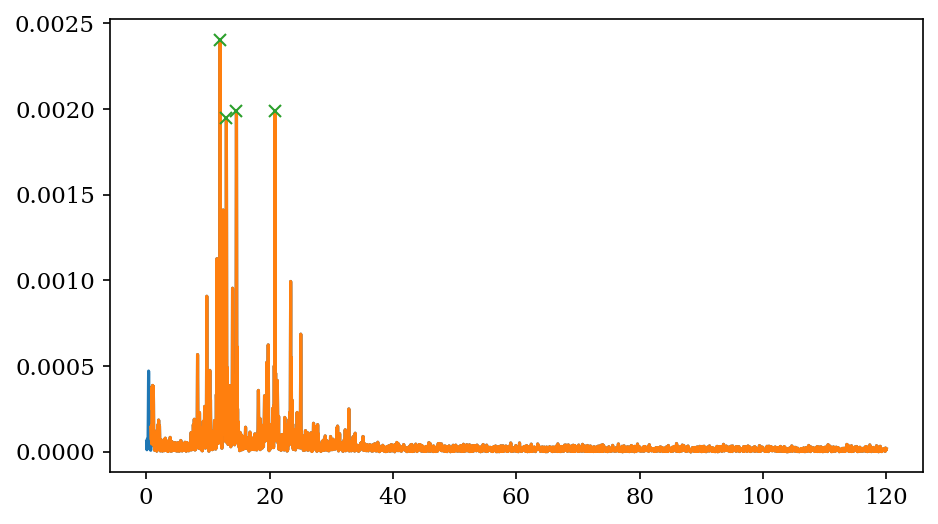

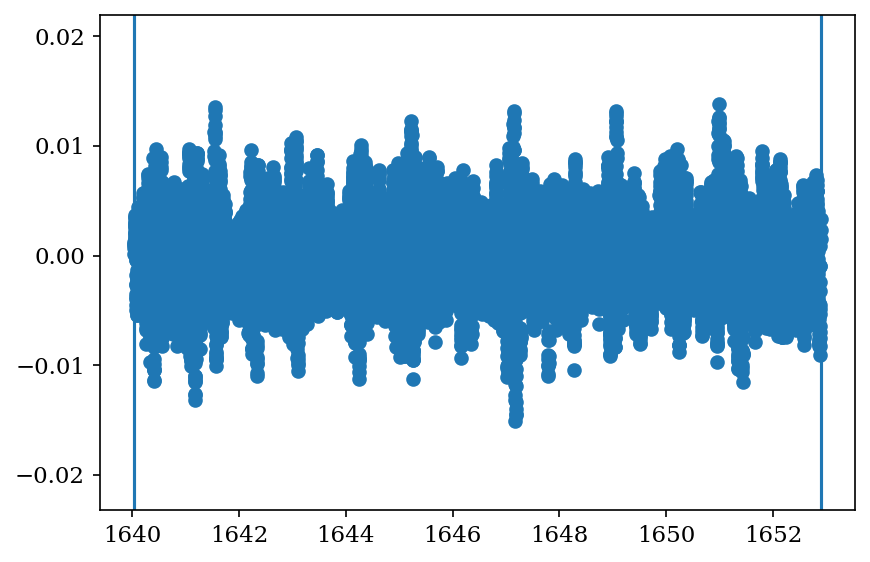

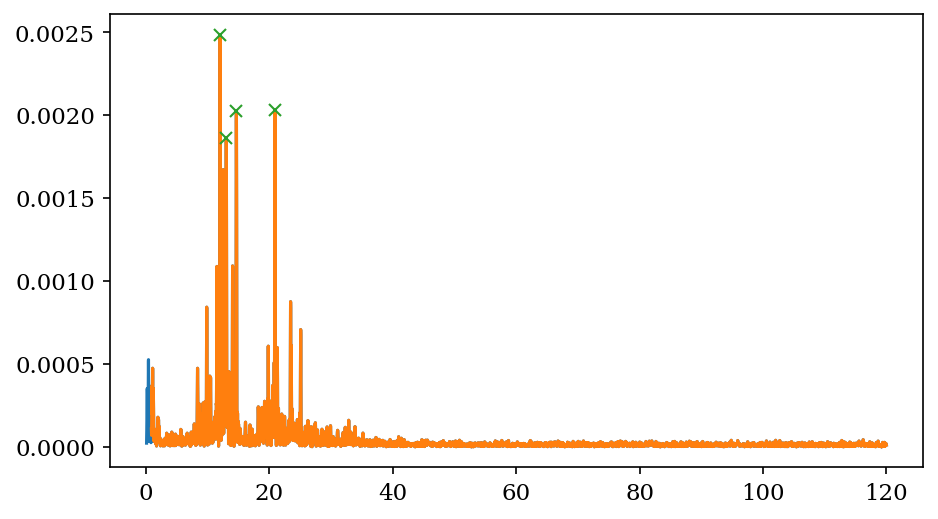

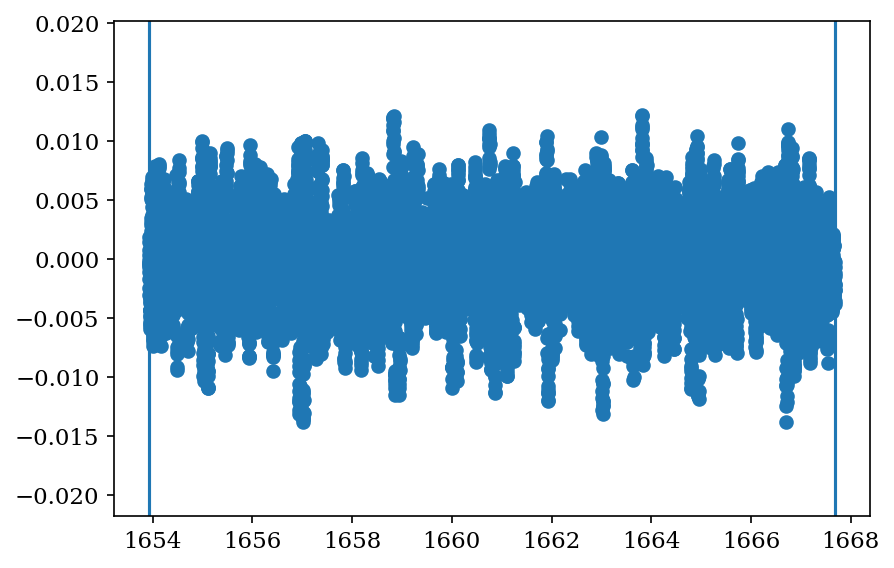

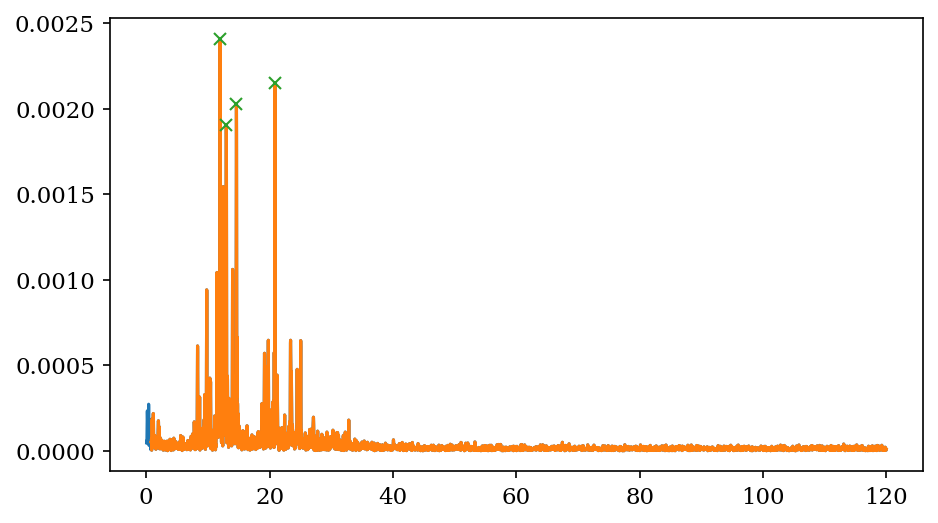

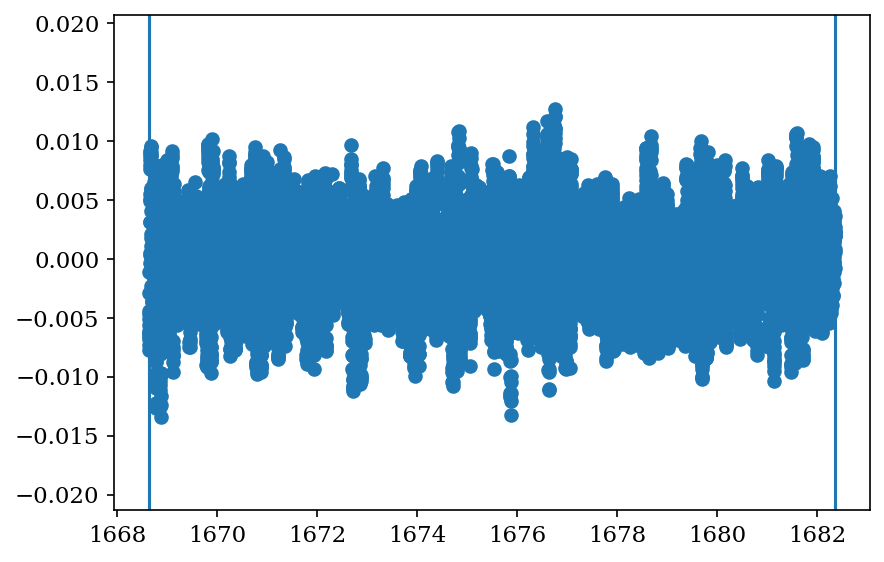

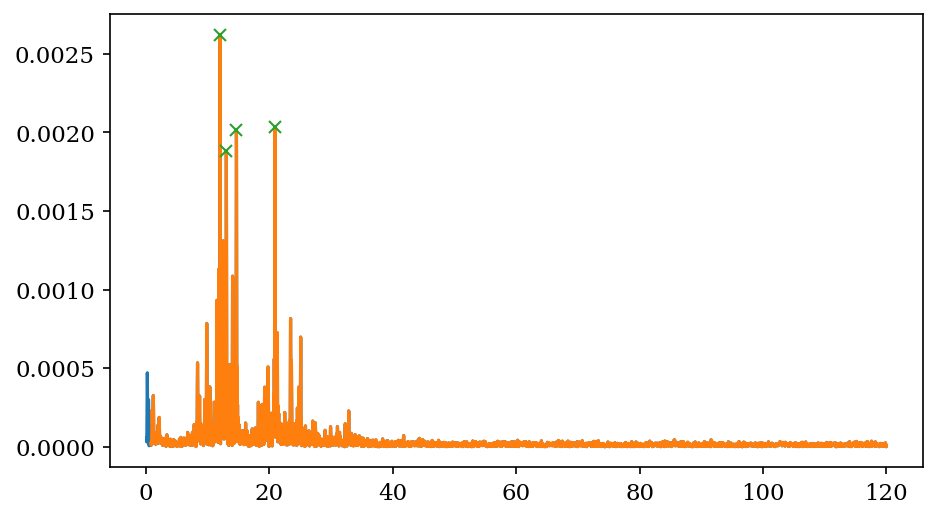

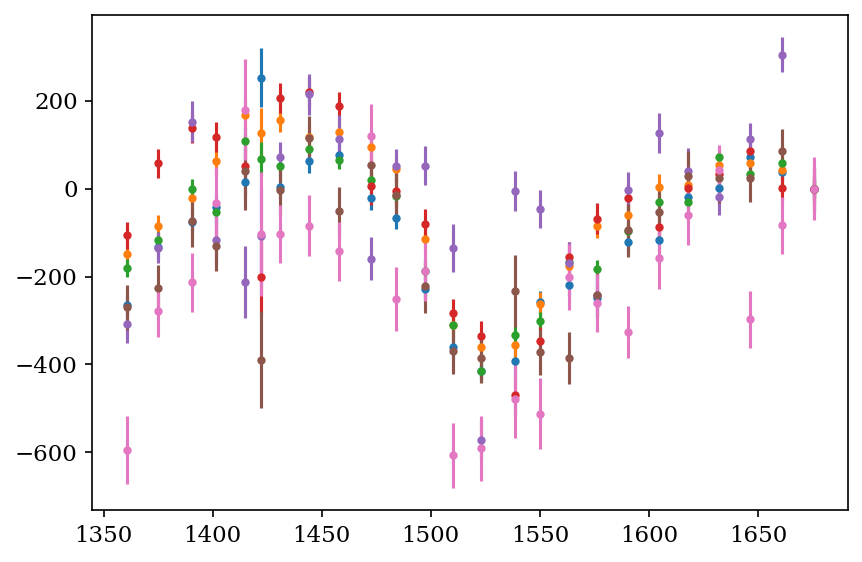

In [129]:
f_TESS_list = [11.99158946, 14.63919138, 20.87840057, 13.00383616]
a_TESS_list = [0.00246508, 0.00197533, 0.00191925, 0.00184786]

f_TESS_list = [11.99158946, 14.63919138, 20.87840057, 13.00383616, 12.49446322, 14.01831695,
 11.487294  ]
a_TESS_list = [0.00246508, 0.00197533, 0.00191925, 0.00184786, 0.00144314, 0.00106235,
 0.00103356]


sort_idx = np.argsort(x_TIC)
segment_borders = [0]+[i+1 for i in sorted(np.argsort(np.diff(x_TIC[sort_idx]))[::-1][:24])]+[len(x_TIC)]

times = x_TIC
magnitudes = y_TIC

time_slice, mag_slice, phase, phase_err = [], [], [], []
time_delays, time_delays_err, time_midpoints = [], [], []

iteration = 0

# Iterate over lightcurve
for t, y, idx in zip(times, magnitudes, range(len(times))):
    time_slice.append(t)
    mag_slice.append(y)

    # In each segment
    if idx == segment_borders[iteration+1]-1:
        print(iteration)
        print(idx)
        
        fig1, ax1 = plt.subplots(1, 1, figsize=(6.5, 3.5*2.5/2))
        ax1.scatter(time_slice, mag_slice)
        ax1.axvline(min(time_slice))
        ax1.axvline(max(time_slice))
        
        print('Calc AS')
        #AS################
        freq, amp = AS(time_slice, mag_slice, 5)

        fig, ax = plt.subplots(1, 1, figsize=(7, 4))
        ax.plot(freq, amp)

        freq=freq[50:]
        amp=amp[50:]
        ax.plot(freq, amp)

        max_power = amp.max()

        peaks, _ = find_peaks(amp, height=max_power*0.5, distance=50)
        ax.plot(freq[peaks], amp[peaks], "x")


        sort_idx = np.argsort(amp[peaks])[::-1]
        f_TESS = freq[peaks][sort_idx]
        a_TESS = amp[peaks][sort_idx]

        print(f_TESS)
        print(a_TESS)
        print(len(f_TESS))
        #####################
        
        # Append the time midpoint
        time_midpoints.append(np.mean(time_slice))

        # And the phases for each frequency
        
        print('Calc LS fit')
        sol = phases_simon(time_slice, mag_slice, f_TESS_list, a_TESS_list, [0.5]*len(f_TESS_list))
        
        print(sol)
        
        phase_i = sol[2]*2*np.pi
        phase.append(dft_phase(time_slice, mag_slice, f_TESS_list))
        #phase.append(phase_i)
        phase_err_i = sol[3]*2*np.pi
        phase_err.append(phase_err_i)
        
        time_slice, mag_slice = [], []
        
        iteration += 1 

phase = np.array(phase).T
print(phase)
phase = np.unwrap(phase)
phase -= np.mean(phase)
print(phase)

phase_err = np.array(phase_err).T

print('Calc TD')
# Phase wrapping patch
for ph, ph_err, f in zip(phase, phase_err, f_TESS_list):
    td = ph / (2*np.pi*f)
    time_delays.append(td-np.mean(td))
    time_delays_err.append(ph_err / (2*np.pi*f))

print('Plot TD')
fig, ax = plt.subplots(1, 1, figsize=(6.5, 3.5*2.5/2))
for i in range(len(f_TESS_list)):
    #ax[0].scatter(time_midpoints, time_delays[i]*86400, s=5)
    ax.errorbar(time_midpoints, (time_delays[i]-time_delays[i][-1])*86400, yerr = time_delays_err[i]*86400, fmt='.')    
    #ax[0].set_ylim(-800, 800)
    #ax[1].set_ylim(-800, 800)
    
#plt.tight_layout()
#fig.savefig('f_TESS1.png', tight_layout=True)


t_td_AT = time_midpoints
tau_td_AT = []
for j in range(len(f_TESS_list)):
    tau_td_AT.append(np.array([i*86400 for i in time_delays][j]-[i*86400 for i in time_delays][j][-1]))
tau_err_td_AT = time_delays_err

In [130]:
len(f_TESS_list)

7

In [131]:
td_weighted = []
for i in range(len(time_midpoints)):
    #print(i)
    tds, tds_err = [], []
    for j in range(len(time_delays)):
        #print(j)
        tds.append(time_delays[j][i])
        tds_err.append(time_delays_err[j][i])
    tds = np.array(tds)
    tds_err = np.array(tds_err)
    td_weighted.append(sum(tds/tds_err**2)/sum(1/tds_err**2))
td_weighted = np.array(td_weighted)

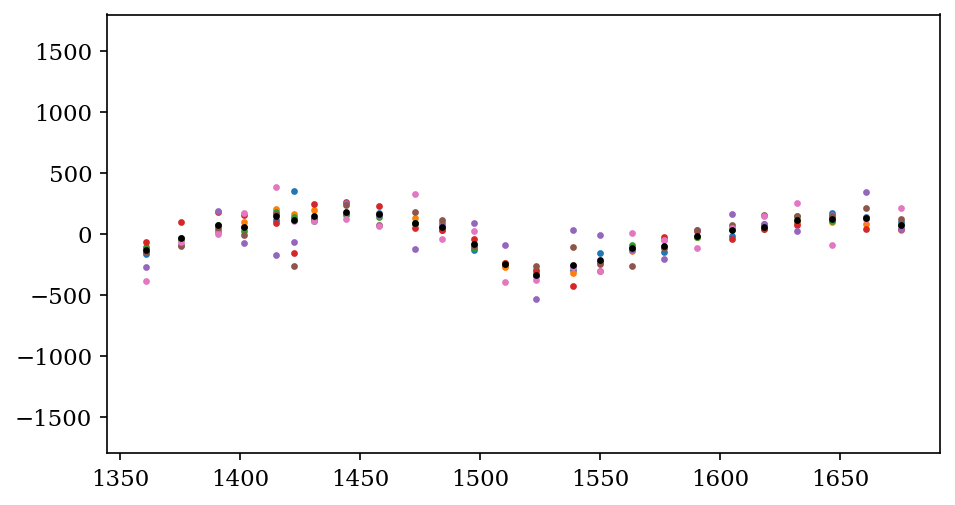

In [132]:
fig, ax = plt.subplots(1, 1, figsize=(6.5, 3.5))
for i in range(7):
    ax.scatter(time_midpoints, time_delays[i]*86400, s=5)
    
ax.scatter(time_midpoints, td_weighted*86400, s=5, c='k')
ax.set_ylim(-1800, 1800)


plt.tight_layout()
#fig.savefig('TDf_TESS1.png', tight_layout=True)

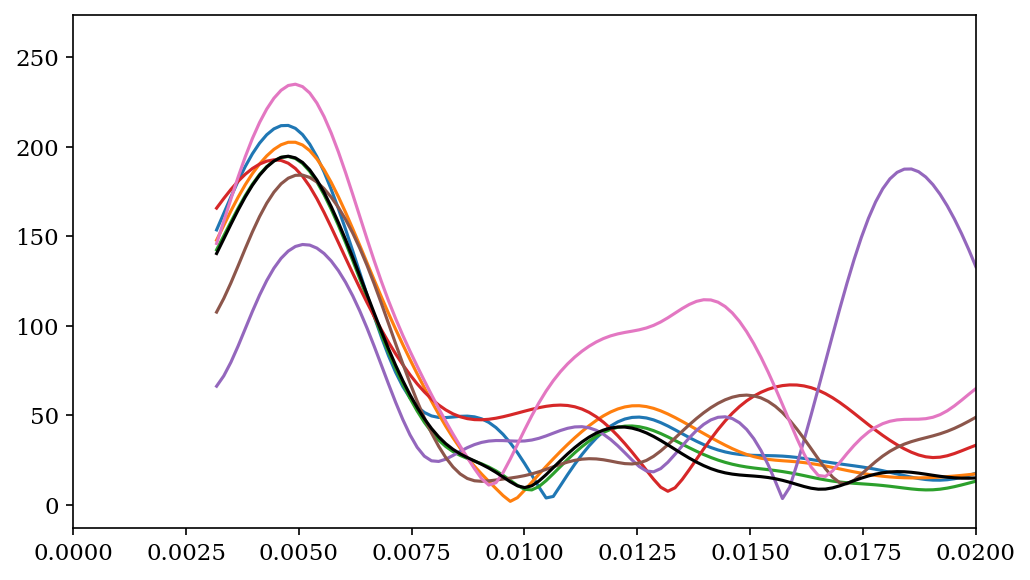

In [133]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

for i in range(7):
    AS_data = AS(np.array(time_midpoints), np.array(time_delays[i])*86400, 20)
    freq = AS_data[0]
    amp = AS_data[1]
    ax.plot(freq, amp)
    
        
        
AS_data = AS(np.array(time_midpoints), np.array(td_weighted)*86400, 20)
freq = AS_data[0]
amp = AS_data[1]
ax.plot(freq, amp, c='k')
ax.set_xlim(0,0.02)

plt.tight_layout()
#fig.savefig('ASf_TESS1.png', tight_layout=True)

Plot TD


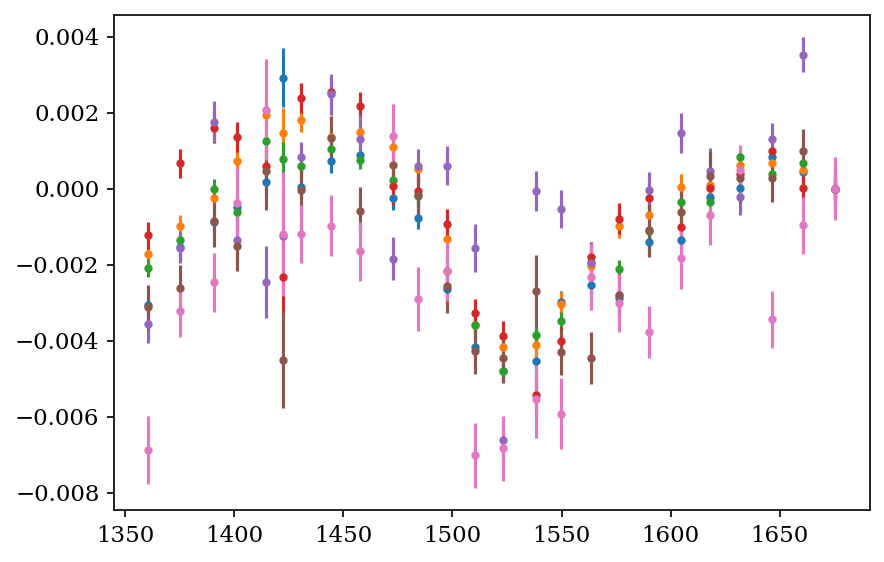

In [134]:
print('Plot TD')
fig, ax = plt.subplots(1, 1, figsize=(6.5, 3.5*2.5/2))
for i in range(len(f_TESS_list)):
    #ax[0].scatter(time_midpoints, time_delays[i]*86400, s=5)
    ax.errorbar(time_midpoints, (time_delays[i]-time_delays[i][-1]), yerr = time_delays_err[i], fmt='.')    
    #ax[0].set_ylim(-800, 800)
    #ax[1].set_ylim(-800, 800)
    
#plt.tight_layout()
#fig.savefig('f_TESS1.png', tight_layout=True)


t_td_AT = time_midpoints
tau_td_AT = []
for j in range(len(f_TESS_list)):
    tau_td_AT.append(np.array([i*86400 for i in time_delays][j]-[i*86400 for i in time_delays][j][-1]))
tau_err_td_AT = time_delays_err

td_weighted = []
for i in range(len(time_midpoints)):
    #print(i)
    tds, tds_err = [], []
    for j in range(len(time_delays)):
        #print(j)
        tds.append(time_delays[j][i])
        tds_err.append(time_delays_err[j][i])
    tds = np.array(tds)
    tds_err = np.array(tds_err)
    td_weighted.append(sum(tds/tds_err**2)/sum(1/tds_err**2))
td_weighted = np.array(td_weighted)

fig, ax = plt.subplots(1, 1, figsize=(6.5, 3.5))
for i in range(9):
    ax.scatter(time_midpoints, time_delays[i]*86400, s=5)
    
ax.scatter(time_midpoints, td_weighted*86400, s=5, c='k')
ax.set_ylim(-800, 800)


plt.tight_layout()
fig.savefig('TDf_TESS1.png', tight_layout=True)

fig, ax = plt.subplots(1, 1, figsize=(7, 4))

for i in range(8):
    AS_data = AS(np.array(time_midpoints), np.array(time_delays[i])*86400, 20)
    freq = AS_data[0]
    amp = AS_data[1]
    ax.plot(freq, amp)
    
        
        
AS_data = AS(np.array(time_midpoints), np.array(td_weighted)*86400, 20)
freq = AS_data[0]
amp = AS_data[1]
ax.plot(freq, amp, c='k')
ax.set_ylim(0,140)

plt.tight_layout()
fig.savefig('ASf_TESS1.png', tight_layout=True)